## Bosquejo de *approach* fuera de la API de keras
#### Autor: Francisco Mena

In [1]:
#imports
import keras, time,os,sys,gc
from keras.layers import *
from keras.models import Sequential,Model
from keras.models import clone_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from sklearn.cluster import AffinityPropagation, SpectralClustering,AgglomerativeClustering,DBSCAN,KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from code.utils import *
from code.representation import *

In [3]:
DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

### Load Data

In [4]:
""" WINE
#df_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",sep=';')
df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",sep=';')

df_red["normal"] = df_red["quality"]==5
df_red["good"] = df_red["quality"]>5
df_red["bad"] = df_red["quality"]<5
df_red["qualities"] = 0*df_red["bad"]+df_red["normal"]+2*df_red["good"]
df_red.drop(['quality','normal','good','bad'],axis=1,inplace=True)

y_train = df_red.pop("qualities").values*1
X_train = df_red.values

y_obs = np.loadtxt("annotations_wine.csv",delimiter=',',dtype='int')
"""

#from keras.datasets import cifar10
#(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
#y_obs = np.loadtxt("../syntetic/annotations_cifar.csv",delimiter=',',dtype='int')

#""" Syntetic data
X_train = np.loadtxt("./synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt("./synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth
y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal.csv",delimiter=',',dtype='int')
#y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal_soft.csv",delimiter=',',dtype='int')


X_test = np.loadtxt("./synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt("./synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
#"""

groups_annot = np.loadtxt("../syntetic/simple/annotgroups_datasim_normal.csv",delimiter=',',dtype='int')
load_matrix = np.loadtxt('./synthetic/simple/matrix_datasim_normal.csv',delimiter=',')
rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
confe_matrix = real_conf_matrix[groups_annot]


N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Shape (data,annotators):  (2292, 100)
Classes:  3


In [4]:
path = "."
scenario = 2

In [5]:
from code.generate_data import SinteticData

X_train = np.loadtxt(path+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(path+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(path+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(path+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth


from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.6121286121286121
Shape (data,annotators):  (2457, 100)
Classes:  3


In [84]:
aux2 = [0.15,0.4,0.45]
aux1 = GenerateData.conf_matrix.copy()

In [6]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation in params 3 is between --1 is for good fit (maybe overfitting)

#number of groups is needed

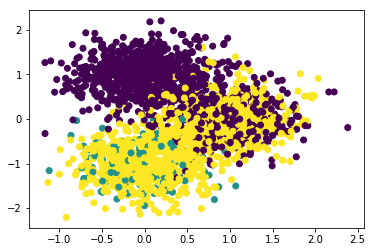

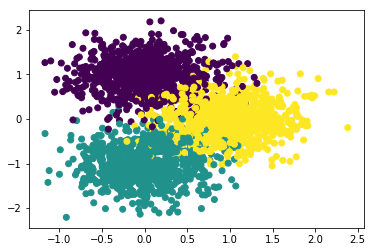

In [15]:
mv = majority_voting(y_obs,onehot=False,probas=False,repeats=False)
plt.scatter(X_train[:,0],X_train[:,1],c=mv)
plt.show()
plt.scatter(X_train[:,0],X_train[:,1],c=Z_train)

In [7]:
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

In [6]:
X_train = X_train.astype(DTYPE_OP)
X_test = X_test.astype(DTYPE_OP)
Xstd_train = X_train/255
Xstd_test = X_test/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

In [8]:
from code.representation import *
##transformar a repeat
r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)

vector of repeats:
 [[3 0 8]
 [1 3 4]
 [8 0 2]
 ...
 [6 1 5]
 [8 1 3]
 [8 1 2]]


In [9]:
import numpy as np
from scipy.stats import entropy
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import DBSCAN,AffinityPropagation, MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
import gc, keras, time, sys

from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple #deep learning
from code.representation import *
from code.utils import softmax


def aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP='float32',option="hard",l=0.005):
    # Get p(g=m|t)  based on a proyection of the annotator "t" 
    std = StandardScaler()
    data_to_cluster = std.fit_transform(data_to_cluster) 
        
    kmeans = MiniBatchKMeans(n_clusters=M, random_state=0,init='k-means++',batch_size=128)
    #KMeans(M,init='k-means++', n_jobs=-1,random_state=0)
    kmeans.fit(data_to_cluster)
    distances = kmeans.transform(data_to_cluster)

    if option=="fuzzy":
        probas_t = np.zeros_like(distances,dtype=DTYPE_OP)
        for t in range(probas_t.shape[0]):
            for m in range(probas_t.shape[1]):
                m_fuzzy = 1.2
                probas_t[t,m] = 1/(np.sum( np.power((distances[t,m]/(distances[t,:]+keras.backend.epsilon())), 2/(m_fuzzy-1)) ) + keras.backend.epsilon())
    elif option == "softmax":
        probas_t = softmax(-(distances+keras.backend.epsilon())/l).astype(DTYPE_OP)
    elif option == "softmax inv":
        probas_t = softmax(1/(l*distances+keras.backend.epsilon())).astype(DTYPE_OP)
    elif option == 'hard':
        probas_t = keras.utils.to_categorical(kmeans.labels_)
    #another option??
        #model = GaussianMixture(n_components=M)
        #model.fit(data_to_cluster)
        #probas_t = model.predict_proba(data_to_cluster).astype(DTYPE_OP)
    return probas_t
            


def project_and_cluster(y_o,M_to_try=20,anothers_visions=True,DTYPE_OP='float32',printed=True,mode_project="pca"):
    ###another way to cluster..
    if len(y_o.shape) == 2:
        M_itj = categorical_representation(y_o,no_label =-1)
    else:
        M_itj = y_o.copy()
    data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
    data_to_cluster = data_to_cluster.astype(DTYPE_OP)
    
    if mode_project.lower() == "pca":
        model = PCA(n_components=4)
    elif mode_project.lower() == "tpca":
        model = TruncatedSVD(n_components=4)
    elif mode_project.lower() == "kpca":
        model = KernelPCA(n_components=4, kernel='rbf', n_jobs=-1)

    plot_data = model.fit_transform(data_to_cluster)
    to_return = [plot_data]
    
    if printed:
        model = BayesianGaussianMixture(n_components=M_to_try)
        model.fit(plot_data)
        M_founded = len(set(np.argmax(model.predict_proba(plot_data),axis=1))) 
        print("Bayesian gaussian mixture say is %d clusters "%M_founded)

        if anothers_visions:
            X_sim = metrics.pairwise_distances(plot_data,metric='euclidean',n_jobs=-1)
            #dos indicadores de numero de cluster
            model = DBSCAN(eps=np.mean(X_sim), min_samples=5, metric='precomputed', n_jobs=-1)
            model.fit(X_sim)
            print("DBSCAN say is %d clusters"%len(set(model.labels_)))
            model = AffinityPropagation(affinity='precomputed')
            model.fit(X_sim)
            print("Affinity Propagation say is %d clusters"%len(set(model.labels_)))

        to_return.append( M_founded )
    return to_return


class GroupMixtureOpt(object): #optimized version
    def __init__(self,input_dim,Kl,M=2,epochs=1,optimizer='adam',pre_init=10,dtype_op='float32'): 
        if type(input_dim) != tuple:
            input_dim = (input_dim,)
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        #params
        self.M = M #groups of annotators
        self.epochs = epochs
        self.optimizer = optimizer
        self.pre_init = pre_init
        self.DTYPE_OP = dtype_op
        
        self.Keps = keras.backend.epsilon() 
        self.priors=False #boolean of priors
        self.compile=False
        self.seted_alphainit = False
        self.lambda_random = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas.copy()
    def get_alpha(self):
        """Get alpha param, p(g) globally"""
        return self.alphas.copy()
    def set_alpha(self,alpha_init):
        """set alpha param with a previosuly method"""
        self.alpha_init = alpha_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        """Get Q estimation param, this is Q_ij(g,z) = p(g,z|xi,y=j)"""
        return self.Qij_mgamma.copy()
        
    def define_model(self,tipo,start_units=1,deep=1,double=False,drop=0.0,embed=True,BatchN=True):
        """Define the base model and other structures"""
        self.type = tipo.lower()     
        if self.type == "keras_shallow" or 'perceptron' in self.type: 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        elif self.type=='defaultcnn' or self.type=='default cnn':
            self.base_model = default_CNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnn' or self.type=='default rnn':
            self.base_model = default_RNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnnE' or self.type=='default rnn E': #with embedding
            self.base_mode = default_RNNw_emb(self.input_dim,self.Kl,len) #len is the length of the vocabulary
            #podria ser el maximo

        elif self.type == "ff" or self.type == "mlp" or self.type=='dense': #classic feed forward
            print("Needed params (units,deep,drop,BatchN?)") #default activation is relu
            self.base_model = MLP_Keras(self.input_dim,self.Kl,start_units,deep,BN=BatchN,drop=drop)

        elif self.type=='simplecnn' or self.type=='simple cnn' or 'cnn' in self.type:
            print("Needed params (units,deep,drop,double?,BatchN?)") #default activation is relu
            self.base_model = CNN_simple(self.input_dim,self.Kl,start_units,deep,double=double,BN=BatchN,drop=drop)
        
        elif self.type=='simplernn' or self.type=='simple rnn' or 'rnn' in self.type:
            print("Needed params (units,deep,drop,embed?)")
            self.base_model = RNN_simple(self.input_dim,self.Kl,start_units,deep,drop=drop,embed=embed,len=0,out=start_units*2)
            #and what is with embedd

        #if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
        #    self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        #     future..
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X):
        """Return the predictions of the model if is from sklearn or keras"""
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=self.batch_size)
    
    def init_E(self,X,r):
        """Realize the initialziation of the E step on the EM algorithm"""
        #-------> init alpha
        if not self.seted_alphainit: #random is the worst option
            self.alpha_init = np.random.dirichlet(np.ones(self.M)/50,size=(self.N,self.Kl))
        
        #-------> init Majority voting        
        self.mv_probs_j = majority_voting(r,repeats=True,probas=True) # soft -- p(y=j|xi)
        
        print("Pre-train network on %d epochs..."%(self.pre_init),end='',flush=True)
        self.base_model.fit(X,self.mv_probs_j,batch_size=self.batch_size,epochs=self.pre_init,verbose=0)
        print(" Done!")
        #reset optimizer but hold weights--necessary for stability 
        self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

        #-------> Initialize p(z=gamma|xi,y=j,g): Combination of mv and belive observable
        lambda_group = np.ones((self.M),dtype=self.DTYPE_OP) 
        if self.lambda_random:
            for m in range(self.M):
                lambda_group[m] = np.random.beta(1,1)
        print("Lambda by group: ",lambda_group)
        Zijm = np.zeros((self.N,self.Kl,self.M,self.Kl),dtype=self.DTYPE_OP)
        for j_ob in range(self.Kl):
            onehot = np.tile(self.Keps, self.Kl)
            onehot[j_ob] = 1. #all belive in the observable
            for m in range(self.M):                
                Zijm[:,j_ob,m,:] = lambda_group[m]*self.mv_probs_j + (1-lambda_group[m])*onehot 
          
        #-------> init q_ij      
        self.Qij_mgamma = self.alpha_init[:,:,:,None]*Zijm
        
        #-------> init betas
        self.betas = np.zeros((self.M,self.Kl,self.Kl),dtype=self.DTYPE_OP) 

        #-------> init alphas
        self.alphas = np.zeros((self.M),dtype=self.DTYPE_OP)
     
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",self.mv_probs_j.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qij_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if type(priors) == str:
            if priors == "laplace":
                priors = 1
            else:
                print("Prior string do not understand")
                return
        else:
            if len(priors.shape)==2:
                priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions):
        """ Realize the E step in matrix version"""       
        p_new = np.clip(predictions[:,None,None,:] , self.Keps,1.) #safe logarithmn
        a_new = np.clip(self.alphas[None,None,:,None] , self.Keps,1.) #safe logarithmn
        b_new = np.clip((self.betas[None,:,:,:]).transpose(0,3,1,2) , self.Keps,1.) #safe logarithmn
        
        self.Qij_mgamma = np.exp(np.log(p_new) + np.log(a_new) + np.log(b_new)) 
        self.aux_for_like = (self.Qij_mgamma.sum(axis=-1)).sum(axis=-1) #p(y=j|x) --marginalized
        self.Qij_mgamma = self.Qij_mgamma/self.aux_for_like[:,:,None,None] #normalize
        
    def M_step(self,X,r): 
        """ Realize the M step"""
        #-------> base model
        Qij_gamma = self.Qij_mgamma.sum(axis=-2) #qij(gamma)
        r_estimate = np.zeros((self.N,self.Kl),dtype=self.DTYPE_OP) #create the repeat "estimate"/"ground truth"
        for i in range(self.N):
            r_estimate[i] = np.tensordot(Qij_gamma[i],r[i],axes=[[0],[0]])
        if "sklearn" in self.type:#train to learn p(z|x)
            self.base_model.fit(X, np.argmax(r_estimate,axis=1) ) 
        else:
            self.base_model.fit(X,r_estimate,batch_size=self.batch_size,epochs=self.epochs,verbose=0) 
    
        #-------> alpha 
        Qij_m = self.Qij_mgamma.sum(axis=-1) #qij(m)
        self.alphas = np.tensordot(Qij_m, r , axes=[[0,1],[0,1]]) # sum_ij r_ij(g) = Qij_m[i]*r[i] 
        self.alphas = self.alphas.astype(self.DTYPE_OP) #necessary
        self.alphas = self.alphas/self.alphas.sum(axis=-1,keepdims=True) #p(g) -- normalize
        
        #-------> beta
        for j_ob in range(self.Kl):
            self.betas[:,:,j_ob] = np.tensordot(self.Qij_mgamma[:,j_ob,:,:],r[:,j_ob], axes=[[0],[0]]) # ~p(yo=j|g,z)              
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior functio
        self.betas = self.betas/self.betas.sum(axis=-1,keepdims=True) #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        """ Compute the log-likelihood of the optimization schedule"""
        return np.tensordot(r , np.log(self.aux_for_like+self.Keps))+0. #safe logarithm
                                                  
    def train(self,X_train,r_train,batch_size=64,max_iter=500,relative=True,val=False,tolerance=1e-2):
        if not self.compile:
            print("You need to create the model first, set .define_model")
            return
        print("Initializing new EM...")
        self.batch_size = batch_size
        self.N = X_train.shape[0]
        self.init_E(X_train,r_train)
        
        logL = []
        stop_c = False
        tol,old_model,old_betas,old_alphas = np.inf,np.inf,np.inf,np.inf
        self.current_iter = 1
        while(not stop_c):
            print("Iter %d/%d\nM step:"%(self.current_iter,max_iter),end='',flush=True)
            start_time = time.time()
            self.M_step(X_train,r_train)
            print(" done,  E step:",end='',flush=True)
            predictions = self.get_predictions(X_train) #p(z|x) 
            self.E_step(X_train,predictions)
            print(" done //  (in %.2f sec)\t"%(time.time()-start_time),end='',flush=True)
            logL.append(self.compute_logL(r_train,predictions))
            print("logL: %.3f\t"%(logL[-1]),end='',flush=True)
            if self.current_iter>=2:
                tol = np.abs(logL[-1] - logL[-2])                    
                if relative:
                    tol = tol/np.abs(logL[-2])
                tol2 = np.mean(np.abs(self.betas.flatten()-old_betas)/(old_betas+self.Keps)) #confusion
                tol3 = np.mean(np.abs(self.alphas-old_alphas)/(old_alphas+self.Keps)) #alphas
                print("Tol1: %.5f\tTol2: %.5f\tTol3: %.5f\t"%(tol,tol2,tol3),end='',flush=True)
            old_betas = self.betas.flatten().copy()         
            old_alphas = self.alphas.copy()
            #if val:
            #    print("F1: %.4f"%(f1_score(Z_train, predictions.argmax(axis=1),average='micro')),end='',flush=True)
            self.current_iter+=1
            print("")
            if self.current_iter>max_iter or (tol<=tolerance and tol2<=tolerance): #alphas fuera: and tol3<=tolerance
                stop_c = True 
        print("Finished training!")
        gc.collect()
        return np.asarray(logL)
    
    def annotations_2_group(self,annotations,data=[],pred=[],no_label_sym = -1):
        """
            Map some annotations to some group model by the confusion matrices, p(g| {x_l,y_l})
        """
        if len(pred) != 0:
            predictions_m = pred #if prediction_m is passed
        elif len(data) !=0: 
            predictions_m = self.get_predictions_groups(data) #if data is passed
        else:
            print("Error, in order to match annotations to a group you need pass the data X or the group predictions")
            return
            
        result = np.log(self.get_alpha()+self.Keps)
        aux_annotations = [(i,annotation) for i, annotation in enumerate(annotations) if annotation != no_label_sym]
        for i, annotation in aux_annotations:
            if annotation != no_label_sym: #if label it
                for m in range(self.M):
                    result[m] += np.log(predictions_m[i,m,annotation]+self.Keps)
        result = np.exp(result - result.max(axis=-1, keepdims=True) ) #invert logarithm in safe way
        return result/np.sum(result)
    
    def stable_train(self,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]):
        """
            A stable schedule to train a model on this formulation
        """
        self.lambda_random = False #lambda=1
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='loss',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1])
            self.set_alpha(alphas_clusterized)

        logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True,val=False)
        return logL_hist
    
    #and multiples runs with lambda random false?
    def multiples_run(self,Runs,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]): 
        """
            Run multiples max_iter of EM algorithm, with random stars
        """
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='loss',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1],DTYPE_OP=self.DTYPE_OP)
            self.set_alpha(alphas_clusterized)
            
        found_betas = []
        found_alphas = []
        found_model = []
        found_logL = []
        for run in range(Runs):
            self.base_model = keras.models.clone_model(self.base_model) #reset-weigths
            self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

            logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True) #here the models get resets
            
            found_betas.append(self.betas.copy())
            found_alphas.append(self.alphas.copy())
            found_model.append(self.base_model) #revisar si se resetean los pesos o algo asi..
            found_logL.append(logL_hist)
            gc.collect()
        #setup the configuration with maximum log-likelihood
        logL_iter = np.asarray([np.max(a) for a in found_logL])
        indexs_sort = np.argsort(logL_iter)[::-1] 
        
        self.betas = found_betas[indexs_sort[0]].copy()
        self.alphas = found_alphas[indexs_sort[0]].copy()
        self.base_model = found_model[indexs_sort[0]]
        self.E_step(X,self.get_predictions(X)) #to set up Q
        return found_logL,indexs_sort[0]
    
    def get_predictions_group(self,m,X):
        """ Predictions of group "m", p(y^o | xi, g=m) """
        p_z = self.get_predictions(X)
        p_y_m = np.zeros(p_z.shape)
        for i in range(self.N):
            p_y_m[i] = np.tensordot(p_z[i,:] ,self.betas[m,:,:],axes=[[0],[0]] ) # sum_z p(z|xi) * p(yo|z,g=m)
        return p_y_m 
    
    def get_predictions_groups(self,X):
        """ Predictions of all groups , p(y^o | xi, g) """
        p_z = self.get_predictions(X)
        predictions_m = np.tensordot(p_z ,self.betas,axes=[[1],[1]] ) #sum_z p(z|xi) * p(yo|z,g)
        return predictions_m#.transpose(1,0,2)

    def calculate_extra_components(self,X,y_o,T,calculate_pred_annotator=True):
        """
            Measure indirect probabilities through bayes and total probability of annotators
        """
        predictions_m = self.get_predictions_groups(X) #p(y^o|x,g=m)
        
        prob_Gt = np.zeros((T,self.M)) #p(g|t)
        for t in range(T):
            prob_Gt[t] = self.annotations_2_group(y_o[:,t],pred=predictions_m) 

        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[1],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
  
        if calculate_pred_annotator:
            prob_Yxt = np.tensordot(predictions_m, prob_Gt, axes=[[1],[1]]).transpose(0,2,1) #p(y^o|x,t) = sum_g p(g|t) *p(yo|x,g)
        else:
            prob_Yxt = None
        gc.collect()
        return predictions_m, prob_Gt, prob_Yzt, prob_Yxt
    
    def get_annotator_reliability(self,y_o,X,t):
        """Get annotator reliability, based on his annotations:"""        
        prob_Gt = annotations_2_group(self,y_o[:,t],data=X)
        
        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[0],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
        return prob_Yzt #do something with it


In [10]:
def clusterize_annotators(y_o,M,no_label=-1,bulk=True,cluster_type='loss',data=[],model=None,DTYPE_OP='float32',BATCH_SIZE=64,option="hard",l=0.005):
    start_time = time.time()
    if bulk: 
        if len(y_o.shape) == 2:
            M_itj = categorical_representation(y_o,no_label =no_label)
        else:
            M_itj = y_o.copy()
        mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
        mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
        M_itj[mask_nan] = 1
        #M_itj = M_itj.astype(DTYPE_OP)
        #M_itj_norm = M_itj/M_itj.sum(axis=1,keepdims=True)#[:,None,:]
                
        if len(data) != 0:
            data_to_cluster = data.copy() #annotators_pca
        else:
            data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
            
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l) #0.05 is close to one-hot
        print("Clustering Done!")
        #alphas_init = np.tensordot(M_itj_norm,probas_t, axes=[[1],[0]]) 
        alphas_init = np.tensordot(M_itj, probas_t, axes=[[1],[0]]) 
        alphas_init = alphas_init/alphas_init.sum(axis=-1,keepdims=True) #normalize here for efficiency
    else: #sirve como auxiliar: y_o: is repeats
        #KL entre mv_soft?
        if len(y_o.shape) == 2: 
            mv_hard = majority_voting(y_o,repeats=True,probas=True) 
        else:
            mv_hard = majority_voting(y_o,repeats=False,probas=True)  #soft version
        #aux_model = keras.models.clone_model(model)
        #aux_model.compile(loss='categorical_crossentropy',optimizer=model.optimizer)
        #aux_model.fit(data, mv_hard, batch_size=BATCH_SIZE,epochs=30,verbose=0)
        #predicted = aux_model.predict(data,verbose=0)
        predicted = mv_hard.copy()
        #print(predicted)
        data_to_cluster = []
        if cluster_type=='loss': #cluster respecto to loss function
            for i in range(mv_hard.shape[0]):
                for j in range(mv_hard.shape[1]):
                    ob = np.tile(keras.backend.epsilon(), mv_hard.shape[1])
                    ob[j] = 1
                    true = np.clip(predicted[i],keras.backend.epsilon(),1.)        
                    #loss = -np.sum(true*np.log(ob/true))  #kl
                    loss = -np.sum(true*np.log(ob))  #cross entropy
                    data_to_cluster.append([loss])
        data_to_cluster = np.asarray(data_to_cluster)
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l)
        print("Clustering Done!")
        alphas_init = probas_t.reshape(mv_hard.shape[0],mv_hard.shape[1],M)
    print("Get init alphas in %f mins"%((time.time()-start_time)/60.) )
    return alphas_init

In [12]:
%%time
#from code.MixtureofGroups import project_and_cluster,clusterize_annotators
#has to executed always, to know a priori the number of clusters and choose
annotators_pca = project_and_cluster(y_obs,mode_project='pca')[0]
#M_f, annotators_pca, alphas_clusterized0 = project_and_cluster(y_obs,cluster=True,return_projected=True)
print(annotators_pca.shape)

Bayesian gaussian mixture say is 9 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


DBSCAN say is 1 clusters
Affinity Propagation say is 4 clusters
(100, 4)
CPU times: user 8.52 s, sys: 807 ms, total: 9.33 s
Wall time: 1.73 s


In [ ]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
np.mean(aux)#*100

In [11]:
alphas_clusterized1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca) #clusteriza anotaciones de anotadoras
#alphas_clusterized2 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='loss',data=Xstd_train,model=gMixture.base_model) #clusteriza en base aloss
#alphas_clusterized3 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='net',data=Xstd_train) #clusteriza en base a pesos de red
alphas_clusterized1

Clustering Done!
Get init alphas in 0.008897 mins


array([[[0.        , 0.6666667 , 0.33333334],
        [0.5       , 0.21      , 0.29      ],
        [0.75      , 0.125     , 0.125     ]],

       [[0.5       , 0.21      , 0.29      ],
        [1.        , 0.        , 0.        ],
        [0.5714286 , 0.2857143 , 0.14285715]],

       [[0.2       , 0.        , 0.8       ],
        [0.        , 0.        , 1.        ],
        [0.6363636 , 0.        , 0.36363637]],

       ...,

       [[0.125     , 0.25      , 0.625     ],
        [0.        , 0.        , 1.        ],
        [0.8333333 , 0.        , 0.16666667]],

       [[0.        , 0.42857143, 0.5714286 ],
        [0.        , 0.        , 1.        ],
        [0.6       , 0.2       , 0.2       ]],

       [[0.2857143 , 0.14285715, 0.5714286 ],
        [0.5       , 0.21      , 0.29      ],
        [1.        , 0.        , 0.        ]]], dtype=float32)

In [69]:
#alphas_c1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax",l=50) 
alphas_c2 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax inv",l=0.005) 
alphas_c3 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="fuzzy") 
alphas_c4 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="hard") 
alphas_c5 = clusterize_annotators(r_obs,M=3,no_label=-1,data=Xstd_train,option="hard",bulk=False,model=gMixture.base_model) 

Clustering Done!
Get init alphas in 0.008863 mins
Clustering Done!
Get init alphas in 0.007592 mins
Clustering Done!
Get init alphas in 0.007051 mins
Clustering Done!
Get init alphas in 0.107466 mins


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [52]:
alphas_c4

array([[[0.5       , 0.        , 0.5       ],
        [0.51      , 0.28      , 0.21      ],
        [0.6666667 , 0.33333334, 0.        ]],

       [[0.6666667 , 0.        , 0.33333334],
        [0.4       , 0.6       , 0.        ],
        [0.33333334, 0.33333334, 0.33333334]],

       [[0.        , 0.5       , 0.5       ],
        [0.51      , 0.28      , 0.21      ],
        [0.5       , 0.25      , 0.25      ]],

       ...,

       [[1.        , 0.        , 0.        ],
        [0.51      , 0.28      , 0.21      ],
        [0.8333333 , 0.        , 0.16666667]],

       [[0.625     , 0.25      , 0.125     ],
        [0.51      , 0.28      , 0.21      ],
        [1.        , 0.        , 0.        ]],

       [[0.3       , 0.3       , 0.4       ],
        [0.51      , 0.28      , 0.21      ],
        [0.75      , 0.25      , 0.        ]]], dtype=float32)

In [70]:
alphas_c5

array([[[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]],

       ...,

       [[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]], dtype=float32)

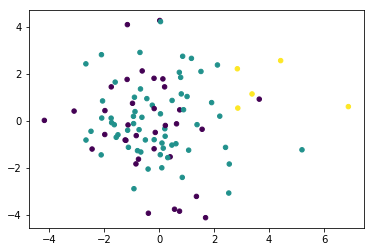

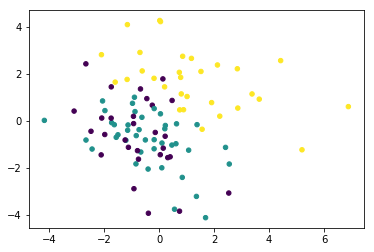

In [16]:
data_to_cluster = annotators_pca.copy() #annotators_pca
std = StandardScaler()
data_to_cluster = std.fit_transform(data_to_cluster)

kmeans = KMeans(n_clusters=3, random_state=0,init='k-means++',n_jobs=-1)
kmeans.fit(data_to_cluster)

#proyect
if scenario != 3:
    plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot,s=20)
else:
    plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot.argmax(axis=1),s=20)

plt.show()
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= kmeans.labels_, s=20)
plt.show()

### Red Base (real)

In [12]:
#PENDIENTES POR AGREGAR---revisar en base a experimentacion con datos simulados
# 1-BatchNormalization en todas las capas
# 2-Dropout

def bloque_convolucional(layer1,units,kernel_size,stride,activation,BN=False):
    """As a ssuper-layer = followed layers"""
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(layer1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(f1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = MaxPool2D(pool_size=stride)(f1)
    return f1
        
def create_network(Kl,input_dim,tipo,info_net,infoextractor_network=None,embedding_info=None):
    #add batch norma y dropa..
    try:
        len(input_dim)
    except:
        input_dim = (input_dim,)
    input_tensor = Input(shape=input_dim,name="data")
    #arquitectura
    if tipo == "CNN": #classic convolutional: deep-CCP
        start_unit,kernel_size,stride,deep,activation = infoextractor_network
        units = start_unit 
        f1 = bloque_convolucional(input_tensor,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        for i in range(deep-1): #profundidad
            units = units*2
            f1 = bloque_convolucional(f1,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        f1 = Flatten()(f1)
            
    elif tipo == "RNN": #recurrent 
        units,deep =infoextractor_network
        #embedding for text datasets
        if embedding_info!=None:
            input_dim,output_dim =embedding_info
            emb = Embedding(input_dim,output_dim)(input_tensor)
            f1 = CuDNNGRU(units,return_sequences=True)(emb)
        else:
            f1 = CuDNNGRU(units,return_sequences=True)(input_tensor)
        for i in range(deep-1): #profundidad
            f1 = CuDNNGRU(units,return_sequences=True)(f1)
        f1 = CuDNNGRU(units,return_sequences=False)(f1) #alias to flatten in convolutional
        #f1 = GlobalMaxPool1D()(f1)
    
    ### classify with extracted features
    units,ff_deep,ff_activation =info_net
    if tipo == "FF": #classic Feed Forward
        d1 = Dense(units,activation=ff_activation)(input_tensor) #comes from input
    else:
        d1 = Dense(units,activation=ff_activation)(f1)
    for i in range(ff_deep-1): #all the deep layers
        units = units/2
        d1 = Dense(units,activation=ff_activation)(d1)
        
    output_soft = Dense(Kl,activation='softmax',name="output_soft")(d1) #softmax to probability p(z|xi)
    
    model = Model(inputs=input_tensor,outputs=output_soft)
    model.summary()
    return model

In [13]:
### Ejemplo CNN
start_units,kernel,strides,deep,activation = 32, 3, 2, 3, 'relu'
info_cnn = [start_units,kernel,strides,deep,activation] 

start_units,deep, activation = 512 , 2, 'relu' 
info = [start_units,deep,activation]  #feed forwad info
clases = 3
dimensiones_input = [50,50,3]
a = create_network(clases,dimensiones_input,"CNN",info,info_cnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [15]:
### Ejemplo RNN
start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [5,50]
a = create_network(clases,dimensiones_input,"RNN",info,info_rnn)

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 5, 50)             0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 5, 128)            69120     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 5, 128)            99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
out

In [16]:
### Ejemplo RNN con embedding
input_dim,output_dim = 1000,64
info_embedding = [input_dim,output_dim]

start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [10] #largo
a = create_network(clases,dimensiones_input,"RNN",info,infoextractor_network=info_rnn,embedding_info=info_embedding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            64000     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 10, 128)           74496     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 10, 128)           99072     
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
__________

<a id="sindato"></a>
### Training module  1
---
Here we implement the iteration between **E** and **M** steps of our formulation with group annotations $r_{ij}$.

In [11]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.MixtureofGroups import GroupMixtureOpt

In [39]:
M_itj = set_representation(y_obs,'onehot')
mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
mask_nan2 = M_itj.sum(axis=1) == 0

mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
M_itj[mask_nan] = 1
M_itj_norm = M_itj/np.sum(M_itj,axis=1)[:,None,:]
M_itj_norm = M_itj_norm.astype(DTYPE_OP)
        
alphas_init = np.tensordot(M_itj_norm,groups_annot, axes=[[1],[0]]) 
#alphas_init[mask_nan2] = 1/alphas_init.shape[-1]
alphas_init

array([[[0.        , 0.5       , 0.5       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.33333334, 0.6666667 , 0.        ]],

       [[0.        , 0.6666667 , 0.33333334],
        [0.6       , 0.4       , 0.        ],
        [0.        , 0.6666667 , 0.33333334]],

       [[0.5       , 0.        , 0.5       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.25      , 0.5       , 0.25      ]],

       ...,

       [[0.        , 1.        , 0.        ],
        [0.21999997, 0.57      , 0.20999998],
        [0.        , 0.8333334 , 0.16666667]],

       [[0.25      , 0.625     , 0.125     ],
        [0.21999997, 0.57      , 0.20999998],
        [0.        , 1.        , 0.        ]],

       [[0.1       , 0.5       , 0.4       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.25      , 0.75      , 0.        ]]], dtype=float32)

In [60]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=0,dtype_op=DTYPE_OP) 
#gMixture.define_model("keras_shallow")
gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
#gMixture.define_model("default cnn")
gMixture.lambda_random=False

gMixture.set_alpha(alphas_c5)

gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=1,tolerance=TOL*2
                           ,relative=True)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/1
M step: done,  E step: done //  (in 1.11 sec)	logL: -25871.749	
Finished training!


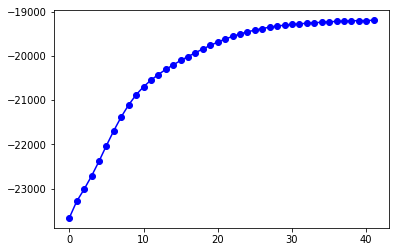

In [97]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

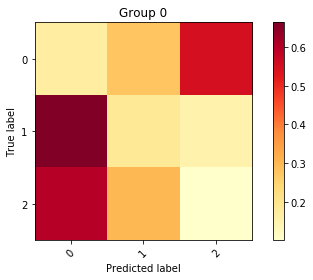

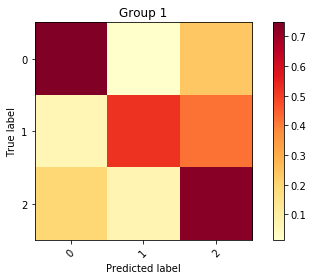

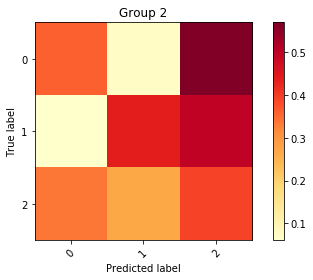

Inertia: 0.12659172527492046
A result
 ====  ========  =========  =========  ===========  =========  =============  =========
  ..    Groups       Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  =========  ===========  =========  =============  =========
   0         0  0.0668789   0.918062     0.152304   1.91645        0.321522  -0.18103
   1         1  0.583417    0.743075     0.666589   0.418815       0.80537    0.333255
   2         2  0.349704    0.946193     0.397353   0.9263         0.601097   0.06402
====  ========  =========  =========  ===========  =========  =============  =========
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.35409       0.35409
====  ======  ==========  ============


In [48]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

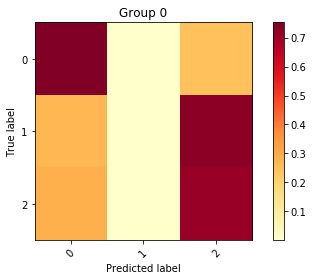

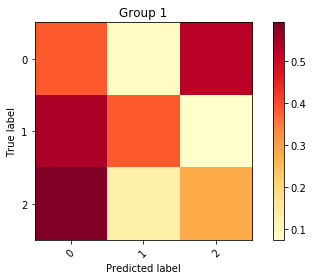

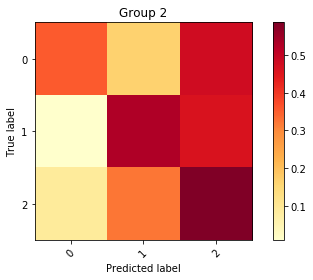

Inertia: 0.16098025565346083
A result
 ====  ========  ========  =========  ===========  =========  =============  =========
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  =========  ===========  =========  =============  =========
   0         0  0.415495   0.586713     0.489071   2.2235         0.57143   0.155738
   1         1  0.21514    0.913499     0.350059   1.06012        0.555461  0.0167254
   2         2  0.369365   0.880749     0.490813   0.734128       0.676285  0.157479
====  ========  ========  =========  ===========  =========  =============  =========
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global   0.0903541     0.0903541
====  ======  ==========  ============


In [61]:
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

In [27]:
GenerateData.prob_groups

array([0.25, 0.55, 0.2 ])

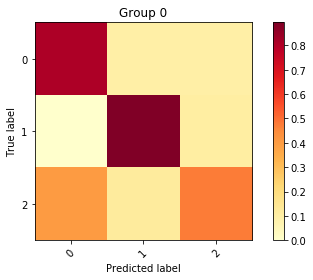

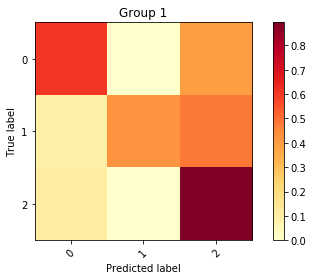

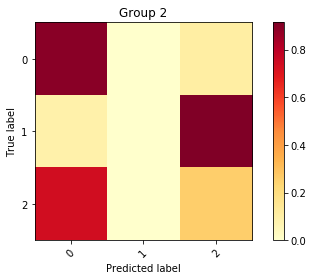

Inertia: 0.16202351067377893
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.189472   0.643653     0.72667    0.355134            0.83733
   1         1  0.588126   0.646593     0.641943   0.489447            0.779772
   2         2  0.222402   0.400478     0.384487   5.86044             0.468836
====  ========  ========  =========  ===========  =========  ==================


In [24]:
evaluate = Evaluation_metrics(gMixture,'our1') 
results = evaluate.calculate_metrics(conf_pred=real_conf_matrix)

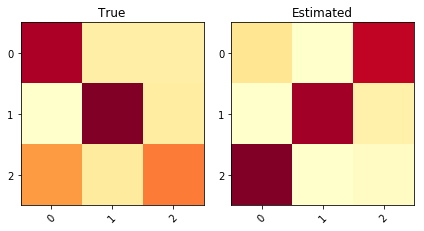

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


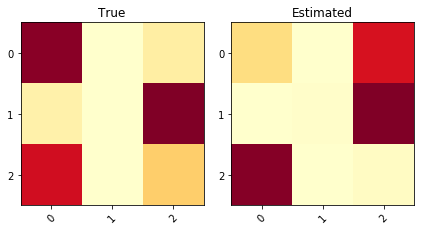

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


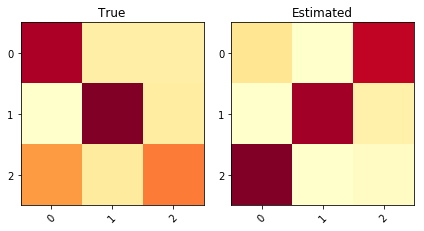

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


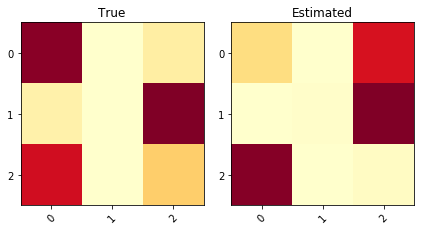

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


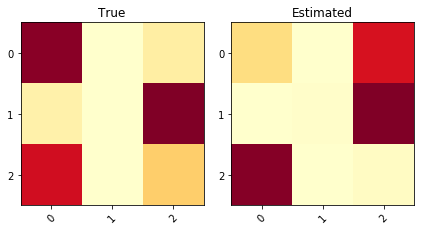

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


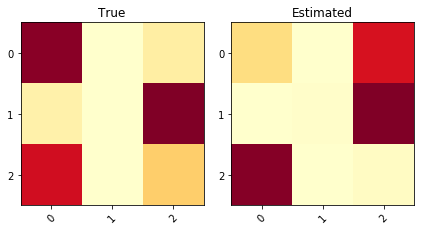

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


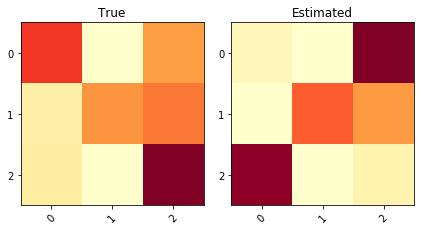

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


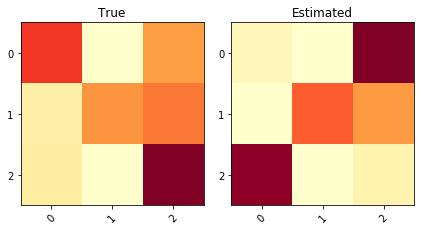

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


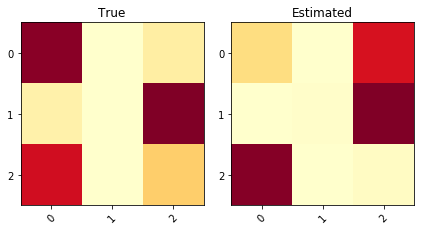

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


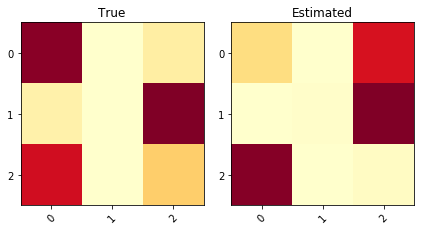

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


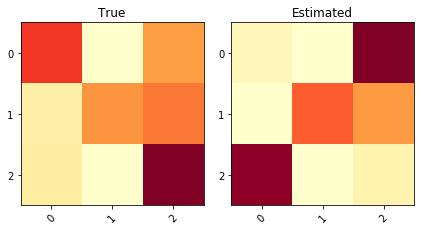

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


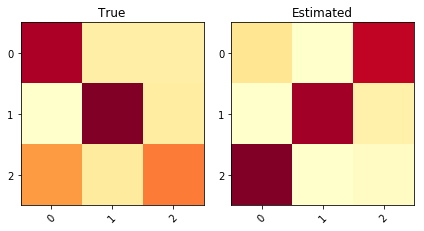

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


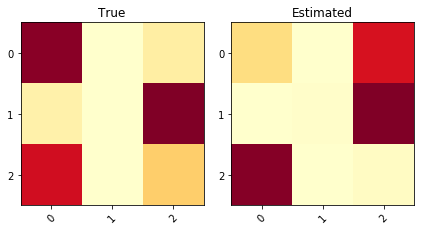

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


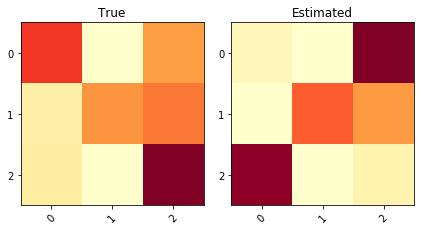

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


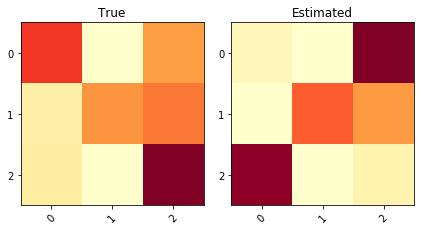

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.400488      0.400488      0.896207               0.234166
====  ======  ==========  ============  ============  =====================


In [17]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [14]:
from code.evaluation import Evaluation_metrics
from tabulate import tabulate
def get_mean_dataframes(df_values):
    if df_values[0].iloc[:,0].dtype == object:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns[1:], index= df_values[0].index)
    else:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns, index= df_values[0].index)
        
    data = []
    for df_value in df_values:
        if df_value.iloc[:,0].dtype == object:
            data.append( df_value.iloc[:,1:].values )
        else:
            data.append(df_value.values)
    RT[:] = np.mean(data,axis=0)
    
    if df_values[0].iloc[:,0].dtype == object:
        RT.insert(0, "", df_values[0].iloc[:,0].values )
    return RT

def run_experiment(pre_init_value):
    aux_test = []
    aux_testA = []
    aux_train = []
    for _ in range(10):
        gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
        gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
        gMixture.lambda_random=False
        gMixture.set_alpha(alphas_clusterized1)
        gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
        logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,relative=True)
        evaluate = Evaluation_metrics(gMixture,'our1',plot=False) 
        c_M = gMixture.get_confusionM()
        Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
        results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)
        aux_test.append(results[1])
        aux_testA.append(results[0])

        aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

        #Usuall train
        Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
        results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
        aux_train += results
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    logL_hists,i = gMixture.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                       ,cluster=True,bulk_annotators=[y_obs,annotators_pca])
    print("**********************************MULTIPLES RUNS**********************************")
    evaluate = Evaluation_metrics(gMixture,'our1',plot=True) 
    c_M = gMixture.get_confusionM()
    Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
    results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

    aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
    predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

    #Usuall train
    Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
    results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
    
    print("**********************************Average Normal**********************************")
    print("A result\n",tabulate(get_mean_dataframes(aux_testA), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_test), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_train), headers='keys', tablefmt='rst'))

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.21 sec)	logL: -24947.248	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24347.524	Tol1: 0.02404	Tol2: 0.22948	Tol3: 0.01297	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23871.028	Tol1: 0.01957	Tol2: 0.16716	Tol3: 0.00513	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23401.530	Tol1: 0.01967	Tol2: 0.14905	Tol3: 0.00239	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22928.640	Tol1: 0.02021	Tol2: 0.14212	Tol3: 0.00308	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22449.100	Tol1: 0.02091	Tol2: 0.13703	Tol3: 0.00433	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21997.239	Tol1: 0.02013	Tol2: 0.13144	Tol3: 0.00571	
Iter 8/50
M step: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -19994.520	Tol1: 0.00085	Tol2: 0.02701	Tol3: 0.00275	
Iter 29/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19978.249	Tol1: 0.00081	Tol2: 0.02902	Tol3: 0.00348	
Iter 30/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19965.565	Tol1: 0.00063	Tol2: 0.02643	Tol3: 0.00328	
Iter 31/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19953.132	Tol1: 0.00062	Tol2: 0.02426	Tol3: 0.00283	
Iter 32/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19935.037	Tol1: 0.00091	Tol2: 0.02663	Tol3: 0.00313	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19922.504	Tol1: 0.00063	Tol2: 0.02860	Tol3: 0.00326	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19910.417	Tol1: 0.00061	Tol2: 0.02543	Tol3: 0.00347	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19898.313	Tol1: 0.00061	Tol2: 0.02626	Tol3: 0.00342	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19891.633	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -25288.589	Tol1: 0.00602	Tol2: 0.07014	Tol3: 0.00258	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25142.411	Tol1: 0.00578	Tol2: 0.05746	Tol3: 0.00231	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24997.523	Tol1: 0.00576	Tol2: 0.04909	Tol3: 0.00218	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24856.563	Tol1: 0.00564	Tol2: 0.04429	Tol3: 0.00248	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24719.119	Tol1: 0.00553	Tol2: 0.04247	Tol3: 0.00283	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24581.176	Tol1: 0.00558	Tol2: 0.04139	Tol3: 0.00289	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24443.444	Tol1: 0.00560	Tol2: 0.04445	Tol3: 0.00298	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24304.316	Tol1: 0.00569	Tol2: 0.04744	Tol3: 0.00320	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24164.034	Tol1:

M step: done,  E step: done //  (in 0.16 sec)	logL: -20732.683	Tol1: 0.00609	Tol2: 0.05682	Tol3: 0.00080	
Iter 17/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20621.982	Tol1: 0.00534	Tol2: 0.04526	Tol3: 0.00097	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20525.969	Tol1: 0.00466	Tol2: 0.03654	Tol3: 0.00069	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20443.068	Tol1: 0.00404	Tol2: 0.02923	Tol3: 0.00099	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20375.719	Tol1: 0.00329	Tol2: 0.02471	Tol3: 0.00096	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20317.004	Tol1: 0.00288	Tol2: 0.02448	Tol3: 0.00041	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20271.557	Tol1: 0.00224	Tol2: 0.02412	Tol3: 0.00078	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20231.006	Tol1: 0.00200	Tol2: 0.02583	Tol3: 0.00068	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20200.022	T

M step: done,  E step: done //  (in 10.01 sec)	logL: -23692.505	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23203.799	Tol1: 0.02063	Tol2: 0.21931	Tol3: 0.01062	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22757.079	Tol1: 0.01925	Tol2: 0.17583	Tol3: 0.00559	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22325.034	Tol1: 0.01899	Tol2: 0.15999	Tol3: 0.00680	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21927.355	Tol1: 0.01781	Tol2: 0.15075	Tol3: 0.00692	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21573.786	Tol1: 0.01612	Tol2: 0.14135	Tol3: 0.00633	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21270.906	Tol1: 0.01404	Tol2: 0.13137	Tol3: 0.00651	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21006.048	Tol1: 0.01245	Tol2: 0.11771	Tol3: 0.00600	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20793.993	Tol1: 0.01009	Tol2: 0.10151	Tol3: 0.00516	
Iter 10

M step: done,  E step: done //  (in 0.13 sec)	logL: -22718.751	Tol1: 0.01667	Tol2: 0.10862	Tol3: 0.00098	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22377.834	Tol1: 0.01501	Tol2: 0.11010	Tol3: 0.00141	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22082.325	Tol1: 0.01321	Tol2: 0.10744	Tol3: 0.00200	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21828.443	Tol1: 0.01150	Tol2: 0.10054	Tol3: 0.00247	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21617.221	Tol1: 0.00968	Tol2: 0.09139	Tol3: 0.00312	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21437.823	Tol1: 0.00830	Tol2: 0.08075	Tol3: 0.00348	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21273.994	Tol1: 0.00764	Tol2: 0.07118	Tol3: 0.00383	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21126.484	Tol1: 0.00693	Tol2: 0.06350	Tol3: 0.00402	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20990.089	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20310.780	Tol1: 0.00221	Tol2: 0.03326	Tol3: 0.00169	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20267.393	Tol1: 0.00214	Tol2: 0.03013	Tol3: 0.00181	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20228.837	Tol1: 0.00190	Tol2: 0.02807	Tol3: 0.00179	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20192.316	Tol1: 0.00181	Tol2: 0.02567	Tol3: 0.00192	
Iter 33/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20163.798	Tol1: 0.00141	Tol2: 0.02367	Tol3: 0.00175	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20136.198	Tol1: 0.00137	Tol2: 0.02176	Tol3: 0.00186	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20111.547	Tol1: 0.00122	Tol2: 0.02056	Tol3: 0.00192	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20091.256	Tol1: 0.00101	Tol2: 0.01934	Tol3: 0.00189	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.14 sec)	logL: -20241.246	Tol1: 0.00160	Tol2: 0.02807	Tol3: 0.00161	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20215.436	Tol1: 0.00128	Tol2: 0.02961	Tol3: 0.00136	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20191.085	Tol1: 0.00120	Tol2: 0.03000	Tol3: 0.00149	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20175.734	Tol1: 0.00076	Tol2: 0.02961	Tol3: 0.00145	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20154.066	Tol1: 0.00107	Tol2: 0.02948	Tol3: 0.00131	
Iter 34/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20132.701	Tol1: 0.00106	Tol2: 0.03008	Tol3: 0.00069	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20112.143	Tol1: 0.00102	Tol2: 0.03146	Tol3: 0.00079	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20094.272	Tol1: 0.00089	Tol2: 0.03216	Tol3: 0.00119	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20077.860	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -24416.516	Tol1: 0.01010	Tol2: 0.07352	Tol3: 0.00045	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24129.567	Tol1: 0.01175	Tol2: 0.07360	Tol3: 0.00045	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23807.450	Tol1: 0.01335	Tol2: 0.07643	Tol3: 0.00055	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23471.451	Tol1: 0.01411	Tol2: 0.08302	Tol3: 0.00070	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23128.147	Tol1: 0.01463	Tol2: 0.08853	Tol3: 0.00071	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22791.511	Tol1: 0.01456	Tol2: 0.09389	Tol3: 0.00104	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22480.603	Tol1: 0.01364	Tol2: 0.09640	Tol3: 0.00182	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22201.112	Tol1: 0.01243	Tol2: 0.09666	Tol3: 0.00310	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21950.066	Tol1:

M step: done,  E step: done //  (in 0.17 sec)	logL: -24907.032	Tol1: 0.02998	Tol2: 0.19140	Tol3: 0.01109	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24256.592	Tol1: 0.02611	Tol2: 0.14811	Tol3: 0.00969	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23670.997	Tol1: 0.02414	Tol2: 0.12640	Tol3: 0.00944	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23121.968	Tol1: 0.02319	Tol2: 0.11511	Tol3: 0.00826	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22637.364	Tol1: 0.02096	Tol2: 0.10872	Tol3: 0.00684	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22227.517	Tol1: 0.01810	Tol2: 0.10664	Tol3: 0.00551	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21917.950	Tol1: 0.01393	Tol2: 0.10322	Tol3: 0.00420	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21697.134	Tol1: 0.01007	Tol2: 0.09652	Tol3: 0.00337	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21542.963	Tol1: 0

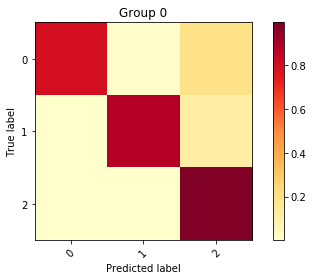

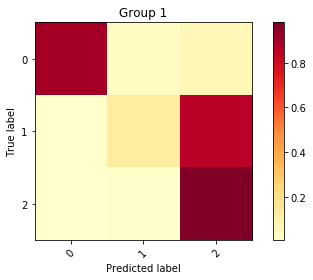

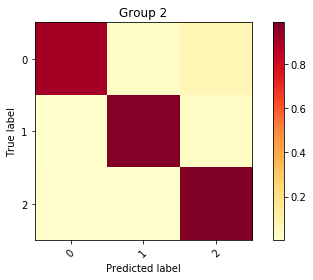

Inertia: 0.09038775088265538
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.531394   0.319756     0.891463  0.11895              0.942105
   1         1  0.155205   0.302014     0.672257  0.71769              0.744472
   2         2  0.313401   0.182315     0.958286  0.0431727            0.978625
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.904762      0.904762
====  ======  ==========  ============


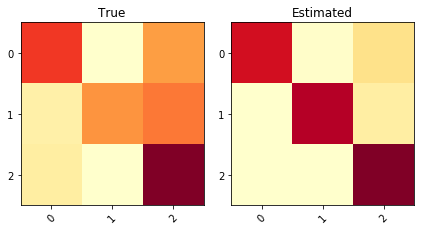

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


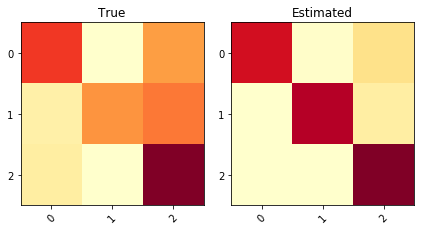

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


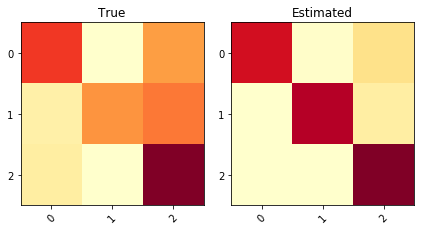

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


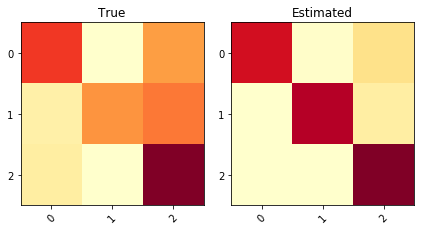

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


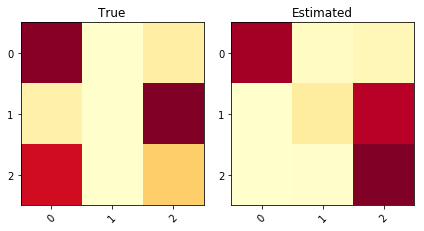

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


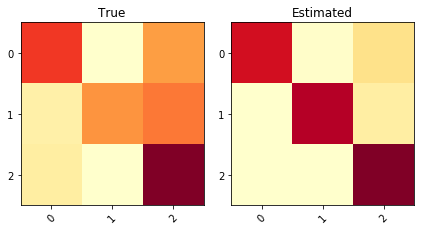

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


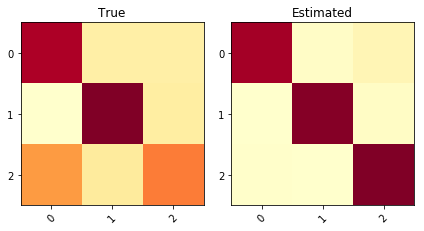

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


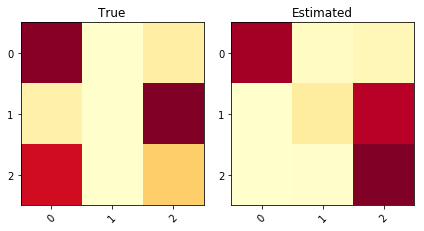

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


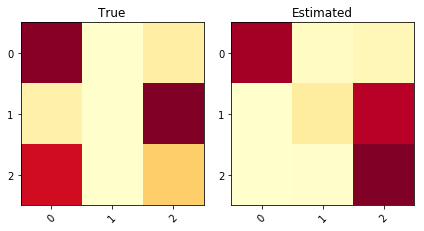

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


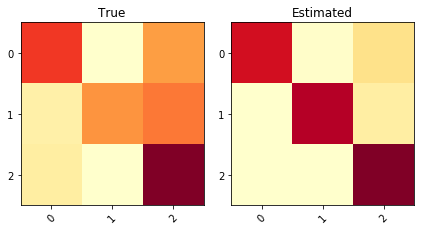

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


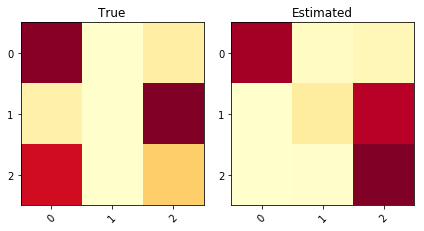

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


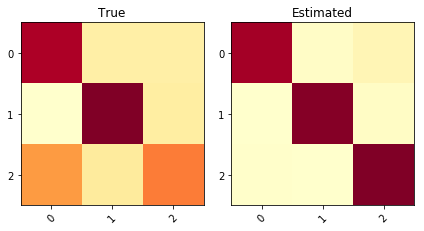

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


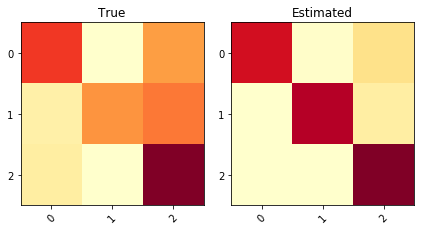

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


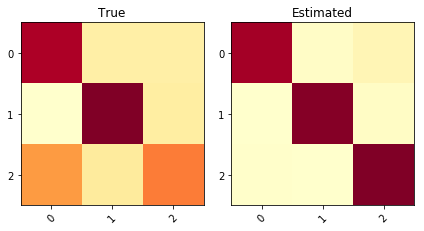

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


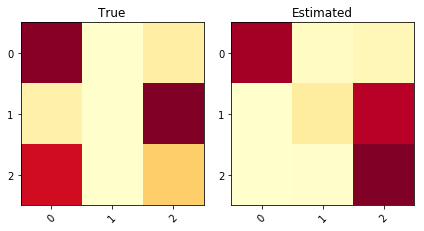

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.895808      0.895808         0.601               0.328088
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.520156   0.402706     0.734198   0.768079            0.807866
   1         1  0.183374   0.302159     0.610063   1.22721             0.669592
   2         2  0.29647    0.275537     0.801024 

In [19]:
#con pre-entrenar 0
run_experiment(0) #funca bien con multiples runs (deja explorar mejor) -- escoje el peor con un bad MV

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.19 sec)	logL: -25369.074	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25024.044	Tol1: 0.01360	Tol2: 0.15578	Tol3: 0.02598	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24784.224	Tol1: 0.00958	Tol2: 0.08865	Tol3: 0.00301	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24489.580	Tol1: 0.01189	Tol2: 0.08265	Tol3: 0.00517	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24129.274	Tol1: 0.01471	Tol2: 0.08693	Tol3: 0.00672	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23701.072	Tol1: 0.01775	Tol2: 0.09491	Tol3: 0.00742	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23220.884	Tol1: 0.02026	Tol2: 0.10750	Tol3: 0.00772	
Iter 8/50
M step:

M step: done,  E step: done //  (in 0.15 sec)	logL: -19969.948	Tol1: 0.00039	Tol2: 0.02577	Tol3: 0.00192	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19960.031	Tol1: 0.00050	Tol2: 0.02511	Tol3: 0.00252	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19956.487	Tol1: 0.00018	Tol2: 0.02366	Tol3: 0.00190	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19951.946	Tol1: 0.00023	Tol2: 0.02167	Tol3: 0.00151	
Iter 38/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19945.052	Tol1: 0.00035	Tol2: 0.02179	Tol3: 0.00217	
Iter 39/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19938.950	Tol1: 0.00031	Tol2: 0.02107	Tol3: 0.00234	
Iter 40/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19939.147	Tol1: 0.00001	Tol2: 0.01966	Tol3: 0.00197	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  

M step: done,  E step: done //  (in 0.16 sec)	logL: -20654.965	Tol1: 0.00524	Tol2: 0.05992	Tol3: 0.00630	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20560.035	Tol1: 0.00460	Tol2: 0.06274	Tol3: 0.00605	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20474.967	Tol1: 0.00414	Tol2: 0.06383	Tol3: 0.00615	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20393.822	Tol1: 0.00396	Tol2: 0.06336	Tol3: 0.00582	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20322.361	Tol1: 0.00350	Tol2: 0.06214	Tol3: 0.00555	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20264.353	Tol1: 0.00285	Tol2: 0.06009	Tol3: 0.00538	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20212.165	Tol1: 0.00258	Tol2: 0.05608	Tol3: 0.00500	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20169.606	Tol1: 0.00211	Tol2: 0.05270	Tol3: 0.00472	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20132.568	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -24570.338	Tol1: 0.00826	Tol2: 0.05908	Tol3: 0.00247	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24359.010	Tol1: 0.00860	Tol2: 0.05791	Tol3: 0.00216	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24131.600	Tol1: 0.00934	Tol2: 0.06118	Tol3: 0.00232	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23887.695	Tol1: 0.01011	Tol2: 0.06844	Tol3: 0.00239	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23630.080	Tol1: 0.01078	Tol2: 0.07540	Tol3: 0.00226	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23348.594	Tol1: 0.01191	Tol2: 0.08202	Tol3: 0.00273	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23065.425	Tol1: 0.01213	Tol2: 0.08805	Tol3: 0.00291	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22769.361	Tol1: 0.01284	Tol2: 0.09235	Tol3: 0.00294	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22478.503	Tol

M step: done,  E step: done //  (in 0.19 sec)	logL: -26203.669	Tol1: 0.03637	Tol2: 0.29928	Tol3: 0.06947	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25944.927	Tol1: 0.00987	Tol2: 0.13361	Tol3: 0.01370	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25758.591	Tol1: 0.00718	Tol2: 0.11111	Tol3: 0.00468	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25593.346	Tol1: 0.00642	Tol2: 0.09004	Tol3: 0.00334	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25427.468	Tol1: 0.00648	Tol2: 0.07620	Tol3: 0.00346	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25246.441	Tol1: 0.00712	Tol2: 0.06809	Tol3: 0.00383	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25037.422	Tol1: 0.00828	Tol2: 0.06336	Tol3: 0.00428	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24785.244	Tol1: 0.01007	Tol2: 0.06661	Tol3: 0.00495	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24470.902	Tol1: 0.

M step: done,  E step: done //  (in 0.17 sec)	logL: -23784.434	Tol1: 0.01513	Tol2: 0.12920	Tol3: 0.00301	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23411.633	Tol1: 0.01567	Tol2: 0.11626	Tol3: 0.00280	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23037.398	Tol1: 0.01598	Tol2: 0.11202	Tol3: 0.00255	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22686.408	Tol1: 0.01524	Tol2: 0.11127	Tol3: 0.00248	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22374.992	Tol1: 0.01373	Tol2: 0.10977	Tol3: 0.00225	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22120.155	Tol1: 0.01139	Tol2: 0.10558	Tol3: 0.00203	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21907.759	Tol1: 0.00960	Tol2: 0.09814	Tol3: 0.00149	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21745.161	Tol1: 0.00742	Tol2: 0.08786	Tol3: 0.00123	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21619.972	Tol1: 0

M step: done,  E step: done //  (in 0.20 sec)	logL: -20246.707	Tol1: 0.00447	Tol2: 0.04516	Tol3: 0.00525	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20169.482	Tol1: 0.00381	Tol2: 0.04468	Tol3: 0.00491	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20108.477	Tol1: 0.00302	Tol2: 0.04385	Tol3: 0.00449	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20064.670	Tol1: 0.00218	Tol2: 0.03920	Tol3: 0.00380	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20028.923	Tol1: 0.00178	Tol2: 0.03714	Tol3: 0.00349	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20001.455	Tol1: 0.00137	Tol2: 0.03592	Tol3: 0.00277	
Iter 30/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19984.824	Tol1: 0.00083	Tol2: 0.03374	Tol3: 0.00185	
Iter 31/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19967.152	Tol1: 0.00088	Tol2: 0.03453	Tol3: 0.00278	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19957.503	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -23187.070	Tol1: 0.01540	Tol2: 0.11393	Tol3: 0.00481	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22798.239	Tol1: 0.01677	Tol2: 0.11917	Tol3: 0.00546	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22388.331	Tol1: 0.01798	Tol2: 0.12298	Tol3: 0.00642	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21986.730	Tol1: 0.01794	Tol2: 0.12378	Tol3: 0.00692	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21613.108	Tol1: 0.01699	Tol2: 0.12065	Tol3: 0.00733	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21296.438	Tol1: 0.01465	Tol2: 0.11277	Tol3: 0.00720	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21023.177	Tol1: 0.01283	Tol2: 0.10251	Tol3: 0.00698	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20808.420	Tol1: 0.01022	Tol2: 0.08905	Tol3: 0.00596	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20641.409	Tol1

M step: done,  E step: done //  (in 0.16 sec)	logL: -20593.301	Tol1: 0.00310	Tol2: 0.02460	Tol3: 0.00026	
Iter 18/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20539.980	Tol1: 0.00259	Tol2: 0.02165	Tol3: 0.00072	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20484.120	Tol1: 0.00272	Tol2: 0.01960	Tol3: 0.00110	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.51 sec)	logL: -26638.971	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25885.647	Tol1: 0.02828	Tol2: 0.26041	Tol3: 0.03626	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25450.252	Tol1: 0.01682	Tol2: 0.17119	Tol3: 0.01090	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25104.292	Tol1: 0.01359	Tol2: 0.13902	Tol3: 0.00889	
Iter 5/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.17 sec)	logL: -20205.936	Tol1: 0.00188	Tol2: 0.04254	Tol3: 0.00311	
Iter 37/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20178.747	Tol1: 0.00135	Tol2: 0.03933	Tol3: 0.00324	
Iter 38/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20153.447	Tol1: 0.00125	Tol2: 0.03577	Tol3: 0.00301	
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20126.227	Tol1: 0.00135	Tol2: 0.03309	Tol3: 0.00346	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20095.706	Tol1: 0.00152	Tol2: 0.03005	Tol3: 0.00325	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20070.265	Tol1: 0.00127	Tol2: 0.02754	Tol3: 0.00323	
Iter 42/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20048.334	Tol1: 0.00109	Tol2: 0.02500	Tol3: 0.00322	
Iter 43/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20032.313	Tol1: 0.00080	Tol2: 0.02239	Tol3: 0.00271	
Iter 44/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20015.631	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -19996.398	Tol1: 0.00086	Tol2: 0.02294	Tol3: 0.00143	
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19981.455	Tol1: 0.00075	Tol2: 0.02250	Tol3: 0.00118	
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19969.723	Tol1: 0.00059	Tol2: 0.02230	Tol3: 0.00136	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19960.252	Tol1: 0.00047	Tol2: 0.02089	Tol3: 0.00068	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19946.166	Tol1: 0.00071	Tol2: 0.02042	Tol3: 0.00123	
Iter 42/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19937.382	Tol1: 0.00044	Tol2: 0.02091	Tol3: 0.00115	
Iter 43/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19932.962	Tol1: 0.00022	Tol2: 0.01914	Tol3: 0.00049	
Finished training!
**********************************MULTIPLES RUNS**********************************


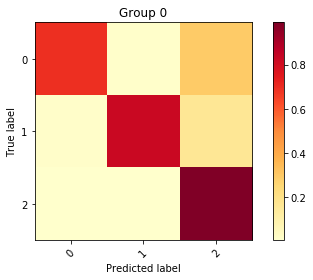

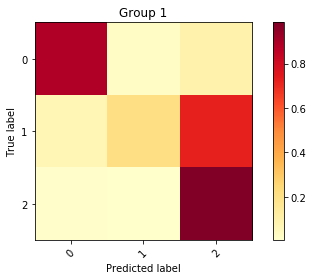

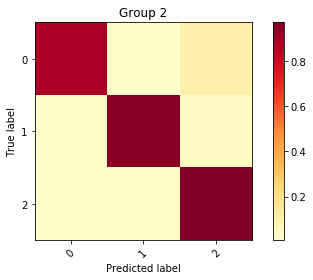

Inertia: 0.0704279625788331
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.533927   0.408676     0.837077  0.188519             0.909823
   1         1  0.177578   0.417015     0.69248   0.569308             0.777471
   2         2  0.288496   0.270643     0.932194  0.0710499            0.96495
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.813187      0.813187
====  ======  ==========  ============


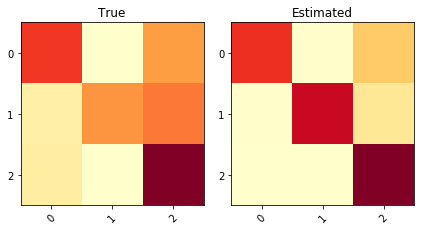

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


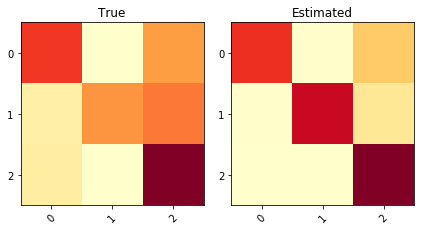

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


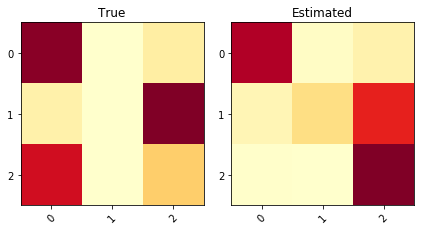

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


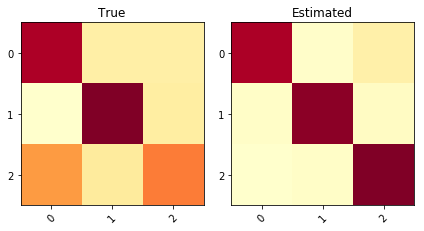

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


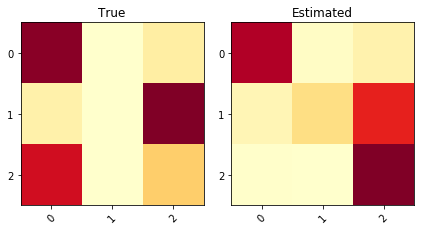

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


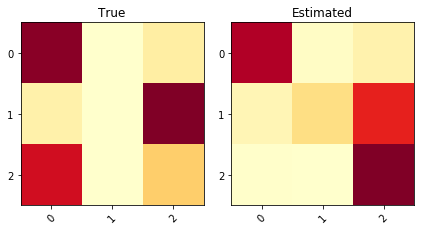

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


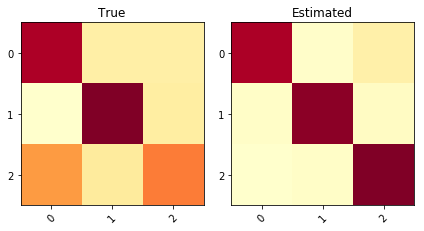

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


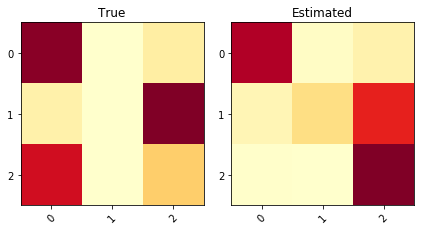

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


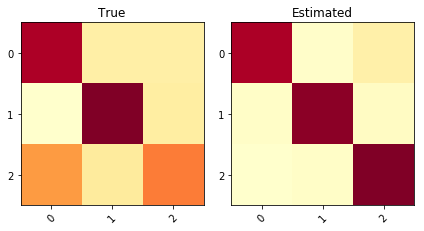

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


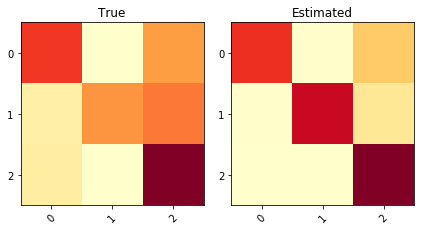

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


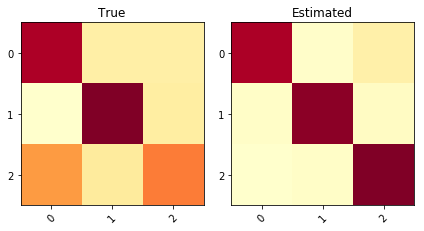

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


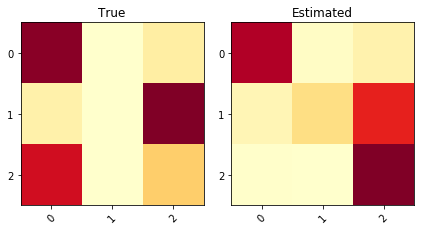

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


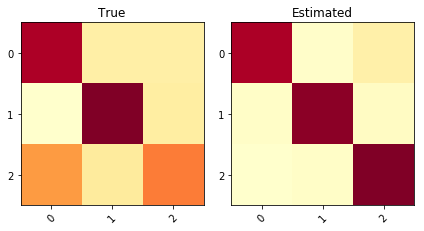

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


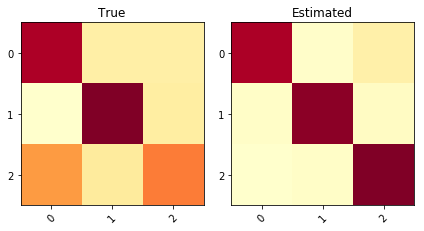

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


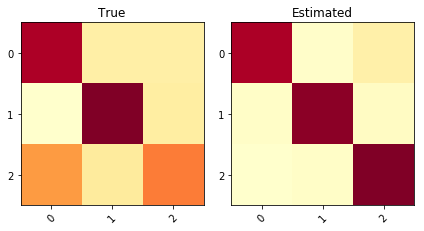

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.800163      0.800163      0.499979               0.298458
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.520388   0.416704     0.76526    0.638699            0.838222
   1         1  0.181608   0.316919     0.643385   1.10452             0.701371
   2         2  0.298004   0.295113     0.817652

In [20]:
#con pre-entrenar 1
run_experiment(1) #escoje el peor con un bad MV-- escoge bien en multiples runs

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 13.52 sec)	logL: -23978.464	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23540.115	Tol1: 0.01828	Tol2: 0.19418	Tol3: 0.00884	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23151.531	Tol1: 0.01651	Tol2: 0.16373	Tol3: 0.00442	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22769.132	Tol1: 0.01652	Tol2: 0.14960	Tol3: 0.00600	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22401.836	Tol1: 0.01613	Tol2: 0.14217	Tol3: 0.00654	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22055.937	Tol1: 0.01544	Tol2: 0.13588	Tol3: 0.00620	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21743.598	Tol1: 0.01416	Tol2: 0.13028	Tol3: 0.00609	
Iter 8/50
M step:

M step: done,  E step: done //  (in 0.17 sec)	logL: -20096.081	Tol1: 0.00051	Tol2: 0.04648	Tol3: 0.00201	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20082.867	Tol1: 0.00066	Tol2: 0.04324	Tol3: 0.00167	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20069.154	Tol1: 0.00068	Tol2: 0.04235	Tol3: 0.00240	
Iter 25/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20060.502	Tol1: 0.00043	Tol2: 0.04026	Tol3: 0.00221	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20053.407	Tol1: 0.00035	Tol2: 0.03710	Tol3: 0.00216	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20043.329	Tol1: 0.00050	Tol2: 0.03535	Tol3: 0.00206	
Iter 28/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20038.924	Tol1: 0.00022	Tol2: 0.03407	Tol3: 0.00247	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20031.928	Tol1: 0.00035	Tol2: 0.03144	Tol3: 0.00253	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20028.801	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -20404.433	Tol1: 0.00455	Tol2: 0.04794	Tol3: 0.00189	
Iter 17/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20331.600	Tol1: 0.00357	Tol2: 0.04608	Tol3: 0.00147	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20271.073	Tol1: 0.00298	Tol2: 0.04728	Tol3: 0.00158	
Iter 19/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20219.112	Tol1: 0.00256	Tol2: 0.04759	Tol3: 0.00107	
Iter 20/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20174.608	Tol1: 0.00220	Tol2: 0.04756	Tol3: 0.00153	
Iter 21/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20140.778	Tol1: 0.00168	Tol2: 0.04670	Tol3: 0.00139	
Iter 22/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20113.550	Tol1: 0.00135	Tol2: 0.04451	Tol3: 0.00129	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20090.146	Tol1: 0.00116	Tol2: 0.04227	Tol3: 0.00068	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20073.161	T

Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.04 sec)	logL: -25573.488	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25088.909	Tol1: 0.01895	Tol2: 0.20012	Tol3: 0.04158	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24791.258	Tol1: 0.01186	Tol2: 0.11051	Tol3: 0.00841	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24468.345	Tol1: 0.01303	Tol2: 0.08728	Tol3: 0.00316	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24108.677	Tol1: 0.01470	Tol2: 0.08333	Tol3: 0.00162	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23703.824	Tol1: 0.01679	Tol2: 0.08860	Tol3: 0.00074	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23284.987	Tol1: 0.01767	Tol2: 0.09794	Tol3: 0.00088	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22872.505	Tol1: 0

M step: done,  E step: done //  (in 0.17 sec)	logL: -20357.343	Tol1: 0.00409	Tol2: 0.05485	Tol3: 0.00418	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20286.111	Tol1: 0.00350	Tol2: 0.05642	Tol3: 0.00379	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20235.968	Tol1: 0.00247	Tol2: 0.05779	Tol3: 0.00336	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20191.304	Tol1: 0.00221	Tol2: 0.05756	Tol3: 0.00305	
Iter 23/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20153.798	Tol1: 0.00186	Tol2: 0.05547	Tol3: 0.00289	
Iter 24/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20117.401	Tol1: 0.00181	Tol2: 0.05281	Tol3: 0.00273	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20083.383	Tol1: 0.00169	Tol2: 0.05082	Tol3: 0.00307	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20057.383	Tol1: 0.00129	Tol2: 0.04690	Tol3: 0.00256	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20036.511	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -23562.403	Tol1: 0.01709	Tol2: 0.09747	Tol3: 0.00178	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23127.330	Tol1: 0.01846	Tol2: 0.10369	Tol3: 0.00156	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22695.728	Tol1: 0.01866	Tol2: 0.11080	Tol3: 0.00150	
Iter 8/50
M step: done,  E step: done //  (in 0.42 sec)	logL: -22289.551	Tol1: 0.01790	Tol2: 0.11476	Tol3: 0.00149	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21907.359	Tol1: 0.01715	Tol2: 0.11431	Tol3: 0.00157	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21579.789	Tol1: 0.01495	Tol2: 0.11019	Tol3: 0.00164	
Iter 11/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21308.227	Tol1: 0.01258	Tol2: 0.10091	Tol3: 0.00171	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21090.212	Tol1: 0.01023	Tol2: 0.08790	Tol3: 0.00170	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20925.364	Tol1:

M step: done,  E step: done //  (in 0.17 sec)	logL: -20004.903	Tol1: 0.00058	Tol2: 0.03033	Tol3: 0.00314	
Iter 31/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19996.604	Tol1: 0.00041	Tol2: 0.02918	Tol3: 0.00396	
Iter 32/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19992.138	Tol1: 0.00022	Tol2: 0.02639	Tol3: 0.00321	
Iter 33/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19983.588	Tol1: 0.00043	Tol2: 0.02517	Tol3: 0.00324	
Iter 34/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19977.123	Tol1: 0.00032	Tol2: 0.02281	Tol3: 0.00245	
Iter 35/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19973.422	Tol1: 0.00019	Tol2: 0.02215	Tol3: 0.00195	
Iter 36/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19969.630	Tol1: 0.00019	Tol2: 0.02138	Tol3: 0.00198	
Iter 37/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19963.299	Tol1: 0.00032	Tol2: 0.02217	Tol3: 0.00304	
Iter 38/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19951.931	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -19924.196	Tol1: 0.00034	Tol2: 0.02704	Tol3: 0.00031	
Iter 34/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19920.923	Tol1: 0.00016	Tol2: 0.02522	Tol3: 0.00043	
Iter 35/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19920.540	Tol1: 0.00002	Tol2: 0.02232	Tol3: 0.00034	
Iter 36/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19918.606	Tol1: 0.00010	Tol2: 0.02092	Tol3: 0.00028	
Iter 37/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19915.935	Tol1: 0.00013	Tol2: 0.01970	Tol3: 0.00065	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 17.05 sec)	logL: -23416.086	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22879.423	Tol1: 0.02292	Tol2: 0.21589	Tol3: 0.01347	
Iter 3/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.17 sec)	logL: -20120.570	Tol1: 0.00135	Tol2: 0.03560	Tol3: 0.00191	
Iter 20/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20100.806	Tol1: 0.00098	Tol2: 0.03536	Tol3: 0.00275	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20079.289	Tol1: 0.00107	Tol2: 0.03448	Tol3: 0.00332	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20066.843	Tol1: 0.00062	Tol2: 0.03360	Tol3: 0.00359	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20056.029	Tol1: 0.00054	Tol2: 0.03242	Tol3: 0.00494	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20040.214	Tol1: 0.00079	Tol2: 0.03166	Tol3: 0.00409	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20027.835	Tol1: 0.00062	Tol2: 0.02948	Tol3: 0.00365	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20016.199	Tol1: 0.00058	Tol2: 0.02874	Tol3: 0.00389	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20009.008	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -20297.929	Tol1: 0.00289	Tol2: 0.04108	Tol3: 0.00433	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20254.487	Tol1: 0.00214	Tol2: 0.03869	Tol3: 0.00433	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20220.091	Tol1: 0.00170	Tol2: 0.03622	Tol3: 0.00431	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20186.398	Tol1: 0.00167	Tol2: 0.03467	Tol3: 0.00487	
Iter 20/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20152.778	Tol1: 0.00167	Tol2: 0.03315	Tol3: 0.00424	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20128.731	Tol1: 0.00119	Tol2: 0.03314	Tol3: 0.00381	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20107.154	Tol1: 0.00107	Tol2: 0.03275	Tol3: 0.00419	
Iter 23/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20085.981	Tol1: 0.00105	Tol2: 0.03024	Tol3: 0.00425	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20071.831	T

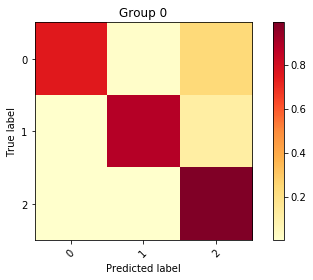

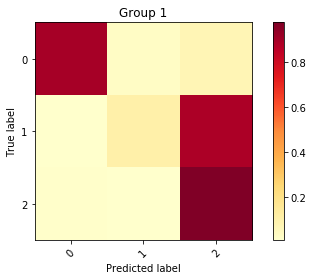

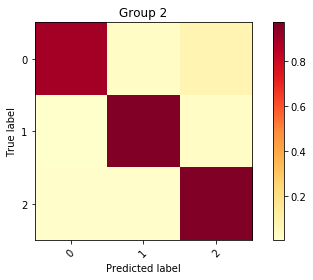

Inertia: 0.09854878578335047
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.538675   0.344538     0.874593  0.140489             0.932098
   1         1  0.163136   0.293304     0.660476  0.800262             0.728018
   2         2  0.298189   0.216458     0.94904   0.0529356            0.973819
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.888889      0.888889
====  ======  ==========  ============


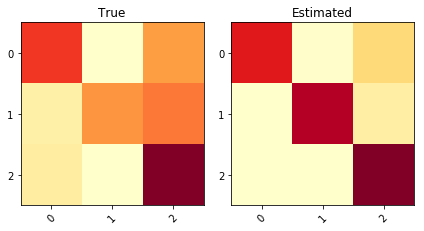

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


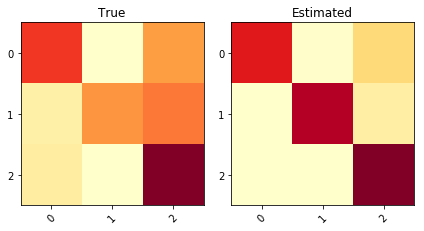

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


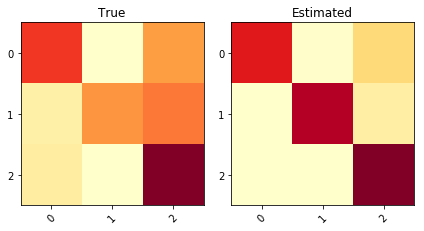

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


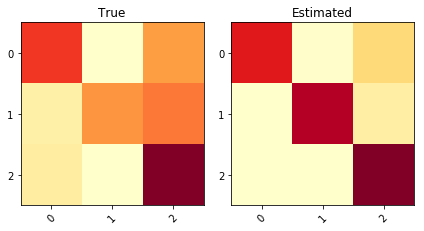

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


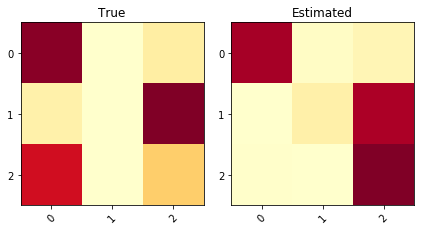

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


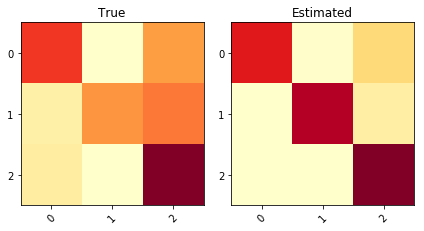

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


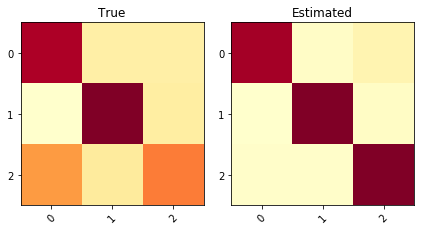

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


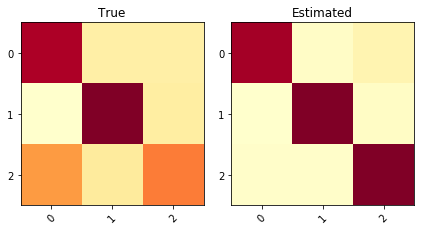

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


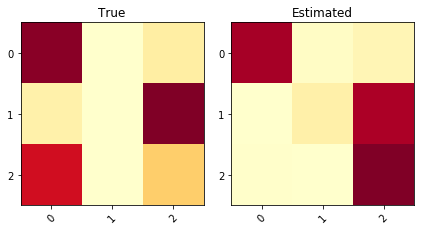

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


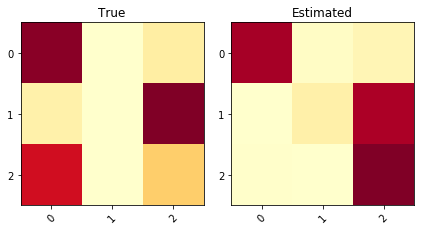

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


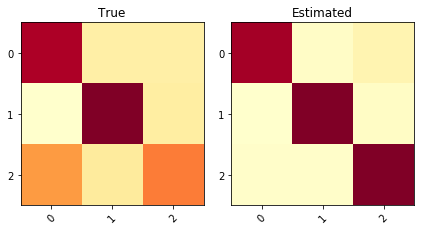

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


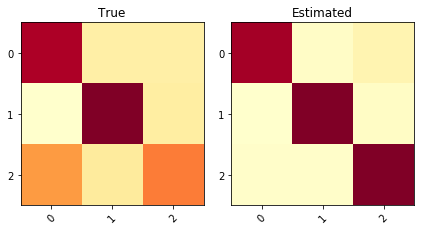

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


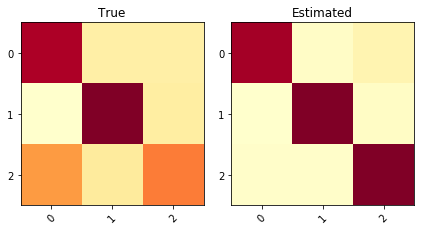

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


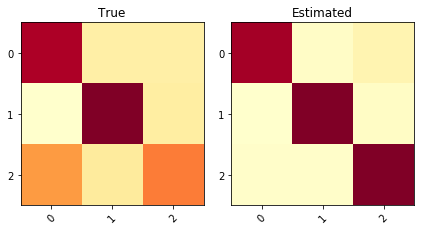

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


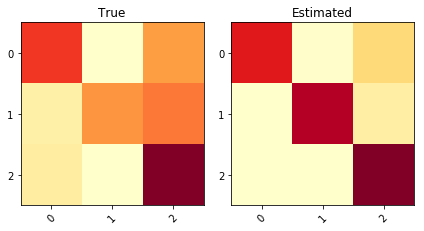

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.883598      0.883598      0.515672               0.319719
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.529088   0.341108     0.866868  0.159141             0.92495
   1         1  0.175087   0.298373     0.658474  0.921669             0.718301
   2         2  0.295825   0.234557     0.940665  

In [21]:
#con pre-entrenar 5
run_experiment(5) #funca relativamente bien en average normal. en multiples runs anda parecido

Conclu de mini experimento:
* Si se ejecuta normal necesario un buen init (pre entrenar 5)
* Si se ejecuta con multiples runs no es tann necesario un buen init (pre entrenar con 1 para que explore m√°s)

In [40]:
%%time
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.41 sec)	logL: -85843.819	F1: 0.7442
Iter 2/25
M step: done	E step: done, (in 2.47 sec)	logL: -83639.140	Tol: 0.02568	F1: 0.7286
Iter 3/25
M step: done	E step: done, (in 2.33 sec)	logL: -82040.527	Tol: 0.01911	F1: 0.7178
Iter 4/25
M step: done	E step: done, (in 2.31 sec)	logL: -81027.269	Tol: 0.01235	F1: 0.7117
Iter 5/25
M step: done	E step: done, (in 2.37 sec)	logL: -80444.867	Tol: 0.00719	F1: 0.7142
Iter 6/25
M step: done	E step: done, (in 2.39 sec)	logL: -80116.539	Tol: 0.00408	F1: 0.7248
Iter 7/25
M step: done	E step: done, (in 2.43 sec)	logL: -79915.121	Tol: 0.00251	F1: 0.7397
Iter 8/25
M step: done	E step: done, (in 2.43 sec)	logL: -79781.112	Tol: 0.00168	F1: 0.7502
Iter 9/25
M step: done	E step: done, (in 2.42 sec)	logL: -79677

In [143]:
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=7,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',256,2)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.40107749624626565, 0.6643001499237149, 0.5331640955460885, 0.1617082682059309, 0.46440295869359777, 0.3517687543555905, 0.7898108127238789]
Alphas:  (2700, 7)
MV init:  (2700, 3)
Betas:  (7, 3, 3)
Q estimate:  (2700, 3, 7, 3)
Iter 1/25
M step: done	E step: done, (in 1.96 sec)	logL: -80827.414	
Iter 2/25
M step: done	E step: done, (in 1.88 sec)	logL: -80249.518	Tol: 0.00715	
Iter 3/25
M step: done	E step: done, (in 1.90 sec)	logL: -79907.925	Tol: 0.00426	
Iter 4/25
M step: done	E step: done, (in 1.90 sec)	logL: -79695.919	Tol: 0.00265	
Iter 5/25
M step: done	E step: done, (in 1.90 sec)	logL: -79573.557	Tol: 0.00154	
Iter 6/25
M step: done	E step: done, (in 1.92 sec)	logL: -79498.354	Tol: 0.00095	
Iter 7/25
M step: done	E step: done, (in 1.89 sec)	logL: -79452.646	Tol: 0.00057	
Iter 8/25
M step: done	E step: done, (in 1.90 sec)	logL: -79421.224	Tol: 0.00040	
Iter 9/25
M step: done	E step:

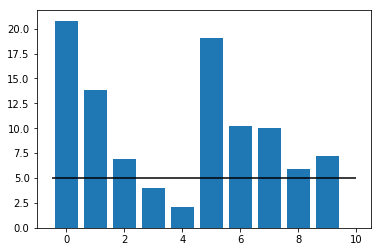

In [63]:
plt.bar(np.arange(M),gMixture.get_alpha()*100)
plt.hlines(5,-0.5,M) #treshold en Numero de anotadores x grupo--quizas no sirva...
#que pasa si hay un grupo que tiene 5 anotadores y otro que tiene 10 pero se comparte con otro que tiene 1?
#sirve para tener una idea general de cuantos anotadores x grupo hay

In [44]:
print("Stable training (global alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Stable training (global alpha)


<Table length=1>
    Acccuracy       F1 score (micro)   F1 score (macro) 
     float64            float64            float64      
------------------ ------------------ ------------------
0.9403703703703704 0.9392316242866506 0.9403703703703703

In [46]:
print("Multiples runs (global alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Multiples runs (global alpha)


<Table length=1>
Acccuracy  F1 score (micro)  F1 score (macro)
 float64       float64           float64     
--------- ------------------ ----------------
     0.96 0.9595173521330044             0.96

In [52]:
print("Multiples runs (data alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Multiples runs (data alpha)


<Table length=1>
    Acccuracy       F1 score (micro)   F1 score (macro) 
     float64            float64            float64      
------------------ ------------------ ------------------
0.9403703703703704 0.9396247669605527 0.9403703703703703

In [69]:
### comparar resultados con mas grupos o menos grupos
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.50 sec)	logL: -84431.118	F1: 0.8277
Iter 2/25
M step: done	E step: done, (in 2.49 sec)	logL: -82027.963	Tol: 0.02846	F1: 0.8218
Iter 3/25
M step: done	E step: done, (in 2.42 sec)	logL: -80732.001	Tol: 0.01580	F1: 0.8196
Iter 4/25
M step: done	E step: done, (in 2.41 sec)	logL: -80087.666	Tol: 0.00798	F1: 0.8191
Iter 5/25
M step: done	E step: done, (in 2.36 sec)	logL: -79755.607	Tol: 0.00415	F1: 0.8215
Iter 6/25
M step: done	E step: done, (in 2.40 sec)	logL: -79562.342	Tol: 0.00242	F1: 0.8249
Iter 7/25
M step: done	E step: done, (in 2.41 sec)	logL: -79413.819	Tol: 0.00187	F1: 0.8332
Iter 8/25
M step: done	E step: done, (in 2.39 sec)	logL: -79296.041	Tol: 0.00148	F1: 0.8391
Iter 9/25
M step: done	E step: done, (in 2.36 sec)	logL: -79187

In [68]:
#and multiples runs
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.00738633966784168, 0.033873725693389055]
Alphas:  (2,)
MV init:  (2700, 3)
Betas:  (2, 3, 3)
Q estimate:  (2700, 3, 2, 3)
Iter 1/25
M step: done	E step: done, (in 1.03 sec)	logL: -84088.130	
Iter 2/25
M step: done	E step: done, (in 1.23 sec)	logL: -82295.538	Tol: 0.02132	
Iter 3/25
M step: done	E step: done, (in 1.01 sec)	logL: -81493.772	Tol: 0.00974	
Iter 4/25
M step: done	E step: done, (in 1.05 sec)	logL: -81109.277	Tol: 0.00472	
Iter 5/25
M step: done	E step: done, (in 1.08 sec)	logL: -80929.009	Tol: 0.00222	
Iter 6/25
M step: done	E step: done, (in 1.05 sec)	logL: -80839.120	Tol: 0.00111	
Iter 7/25
M step: done	E step: done, (in 1.00 sec)	logL: -80784.744	Tol: 0.00067	
Iter 8/25
M step: done	E step: done, (in 0.98 sec)	logL: -80757.410	Tol: 0.00034	
Iter 9/25
M step: done	E step: done, (in 0.99 sec)	logL: -80739.910	Tol: 0.00022	
Finished training!
Initializing new EM...
Pre-train 

In [56]:
groups_annot_pred = np.argmax(prob_Gt,axis=1)
print(groups_annot_pred)
print(set(groups_annot_pred)) #revisar fast el numero de grupos utilizados...

[2 2 1 2 0 2 2 0 0 1 0 1 2 2 0 0 0 0 1 1 0 1 0 2 0 2 2 2 0 0 2 2 1 2 2 1 1
 1 0 2 1 2 0 0 1 0 1 0 1 0 0 2 1 2 2 0 0 1 1 2 1 0 1 2 2 0 2 0 2 0 0 2 2 0
 2 1 0 2 1 2 0 2 0 1 2 0 0 0 2 0 1 0 0 0 2 0 1 0 0 0]
{0, 1, 2}
CPU times: user 32.9 s, sys: 635 ms, total: 33.6 s
Wall time: 33 s


In [41]:
#obtain p(y^o|x,g=m)
gMixture.get_predictions_group(1,Xstd_train) #puedo medir acc con eso

array([[0.22092701, 0.66987641, 0.10919658],
       [0.18366501, 0.769683  , 0.04665199],
       [0.36506755, 0.28602405, 0.34890843],
       ...,
       [0.18930534, 0.75472514, 0.0559695 ],
       [0.33724762, 0.3600254 , 0.30272705],
       [0.44818453, 0.03039722, 0.5214183 ]])

In [36]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (50000, 10)
Betas:  (3, 10, 10)
Q estimate:  (50000, 10, 3, 10)
Iter 1/50
M step: done	E step: done, (in 72.82 sec)	logL: -2715965.263	F1: 0.6261
Iter 2/50
M step:

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 done	E step: done, (in 70.89 sec)	logL: -2679319.023	Tol: 0.01349	F1: 0.6246
Iter 3/50
M step: done	E step: done, (in 71.24 sec)	logL: -2637561.656	Tol: 0.01559	F1: 0.6541
Iter 4/50
M step: done	E step: done, (in 73.48 sec)	logL: -2620187.453	Tol: 0.00659	F1: 0.6679
Iter 5/50
M step: done	E step: done, (in 72.33 sec)	logL: -2608219.150	Tol: 0.00457	F1: 0.6693
Iter 6/50
M step: done	E step: done, (in 71.42 sec)	logL: -2592777.869	Tol: 0.00592	F1: 0.6812
Iter 7/50
M step: done	E step: done, (in 71.17 sec)	logL: -2581476.336	Tol: 0.00436	F1: 0.6877
Iter 8/50
M step: done	E step: done, (in 71.09 sec)	logL: -2576276.410	Tol: 0.00201	F1: 0.6841
Iter 9/50
M step: done	E step: done, (in 72.50 sec)	logL: -2566063.387	Tol: 0.00396	F1: 0.6931
Iter 10/50
M step: done	E step: done, (in 70.87 sec)	logL: -2562741.495	Tol: 0.00129	F1: 0.6959
Iter 11/50
M step: done	E step: done, (in 70.85 sec)	logL: -2559842.885	Tol: 0.00113	F1: 0.6933
Iter 12/50
M step: done	E step: done, (in 71.25 sec)	logL: -25533

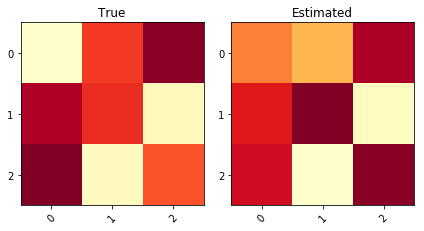

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


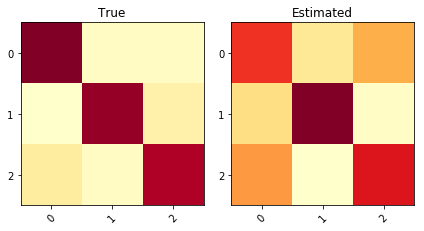

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


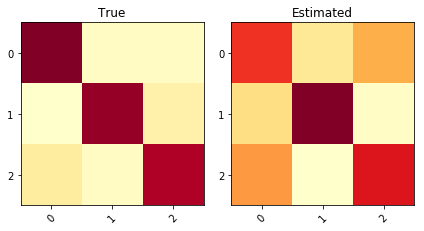

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


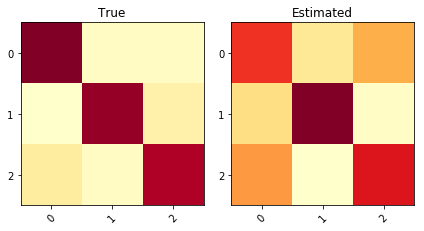

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


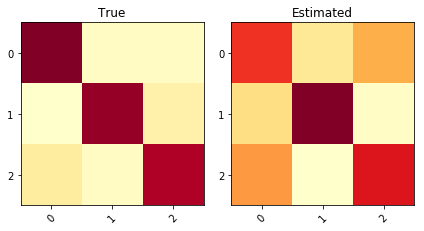

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


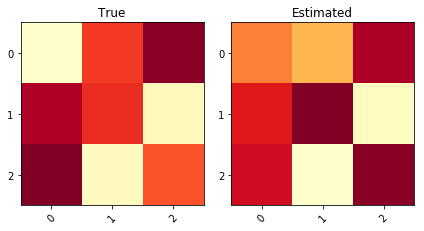

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


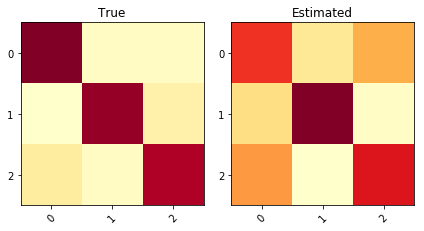

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


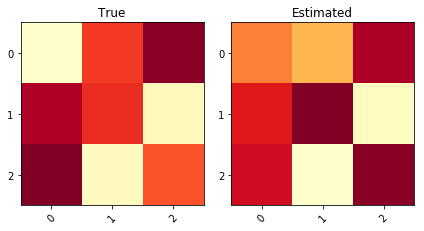

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


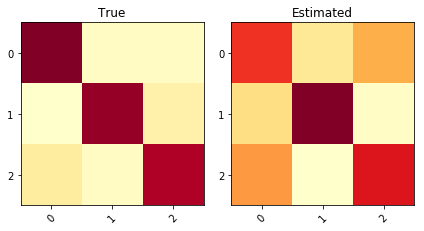

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


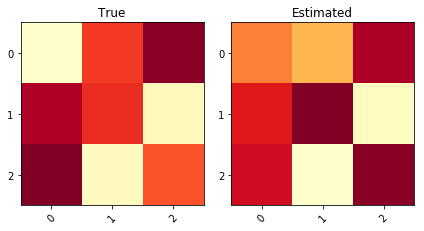

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


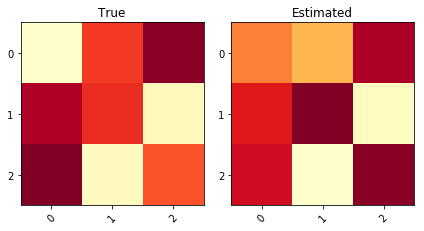

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


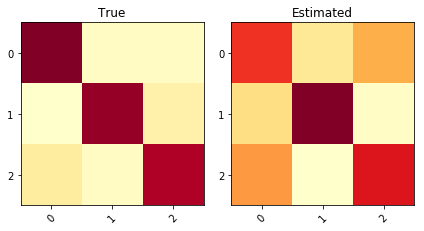

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


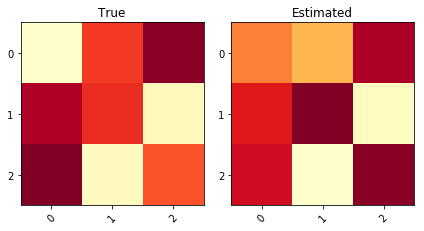

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


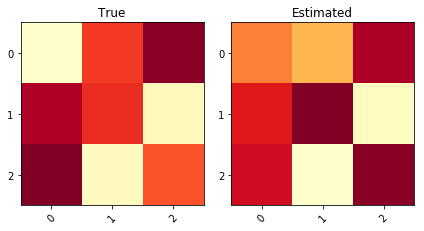

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


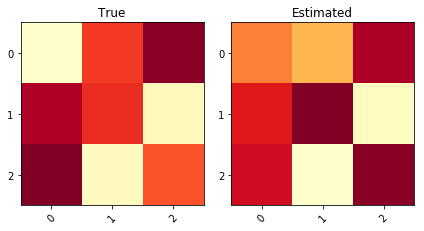

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


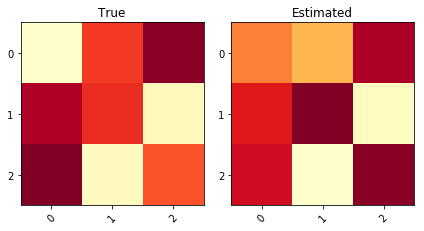

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


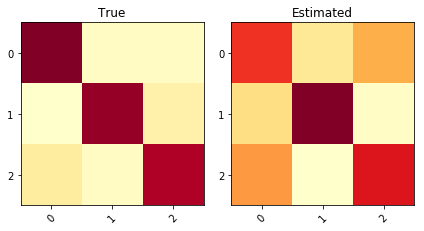

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


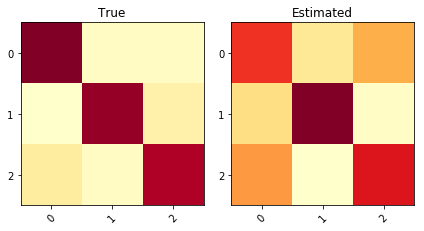

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


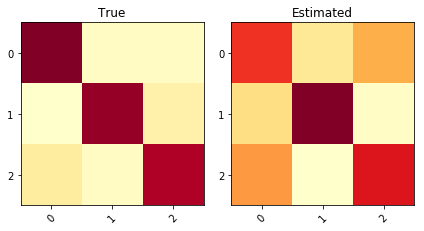

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


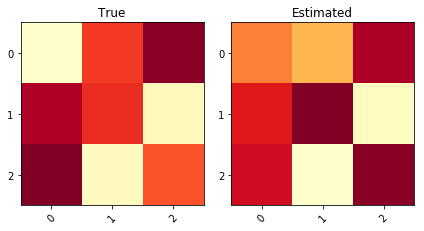

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


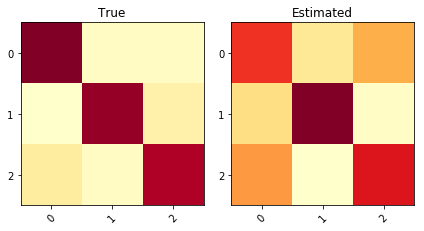

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


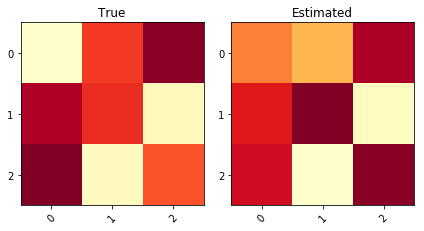

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


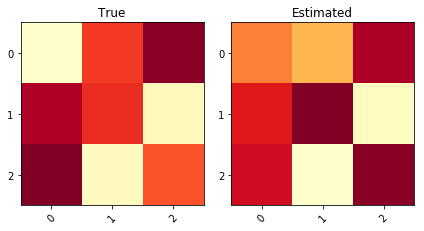

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


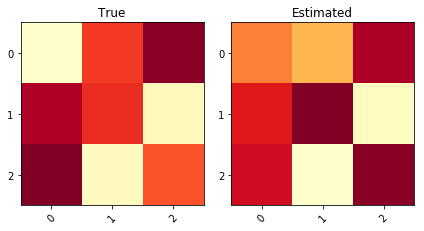

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


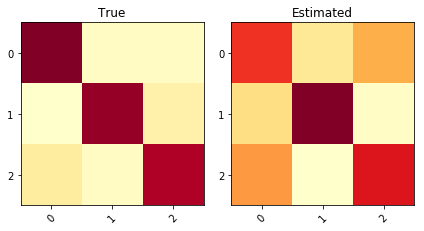

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


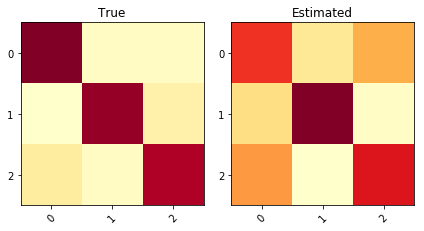

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


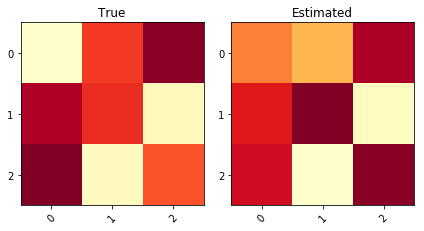

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


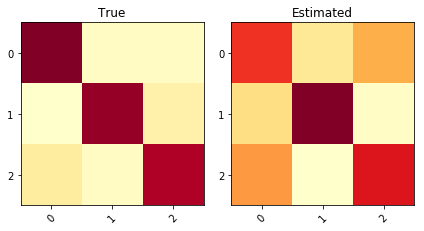

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


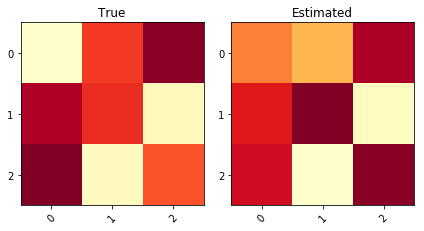

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


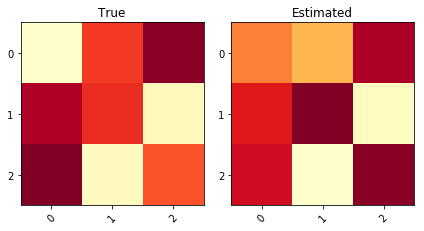

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


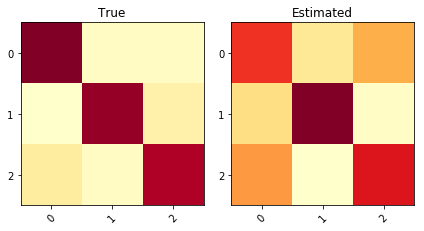

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


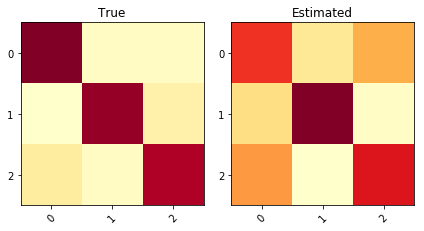

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


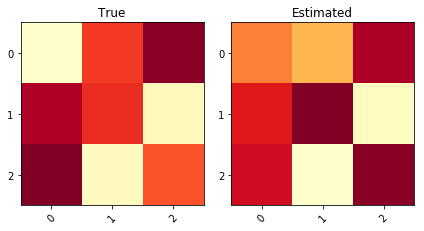

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


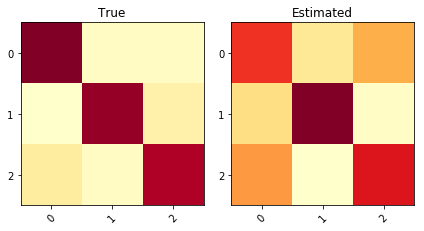

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


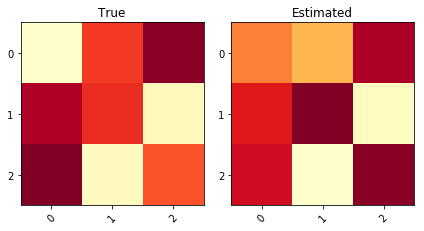

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


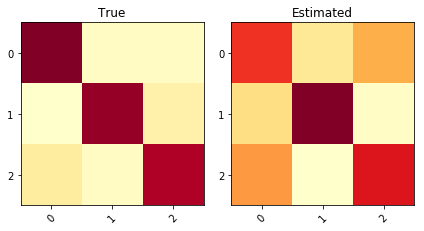

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


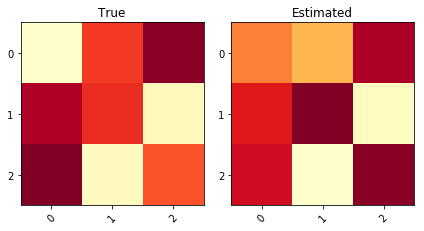

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


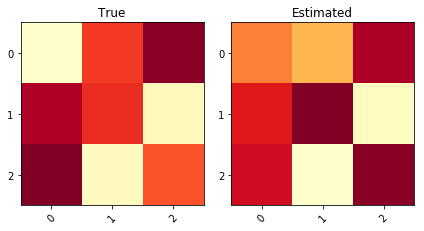

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


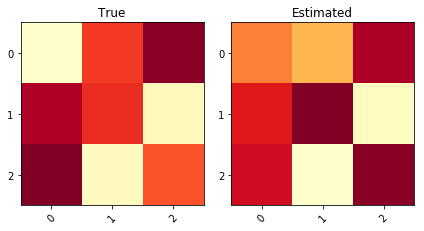

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


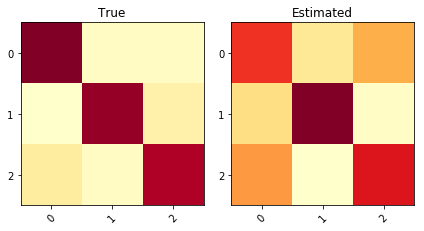

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


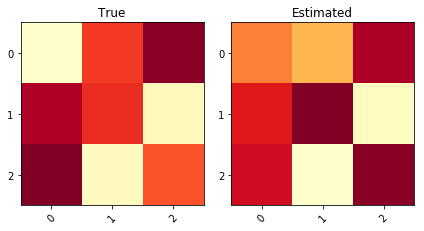

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


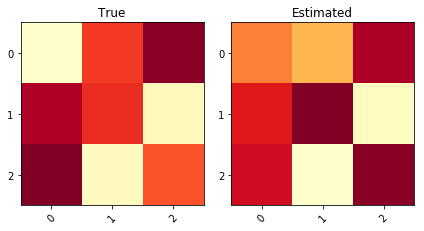

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


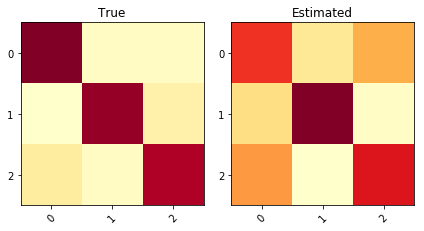

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


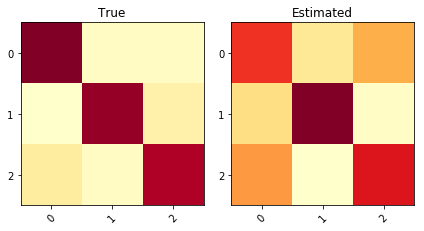

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


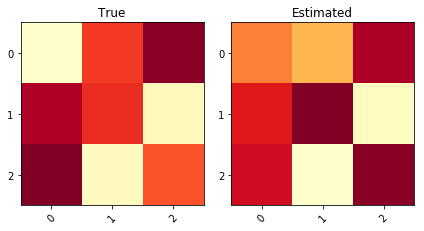

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


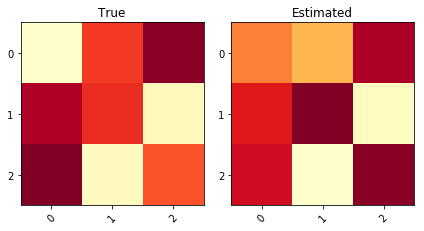

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


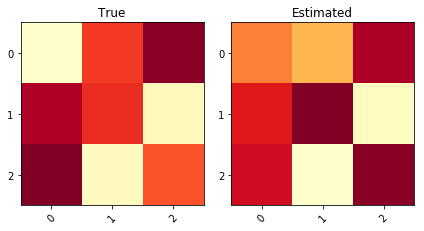

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


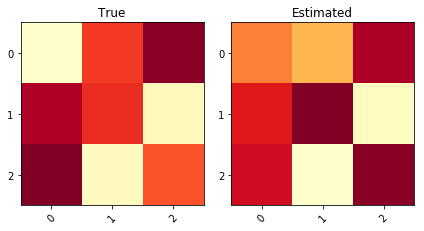

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


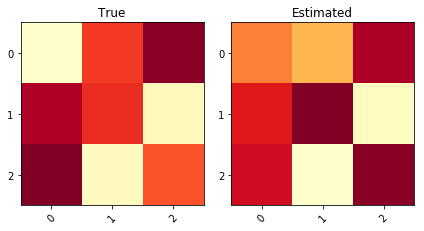

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


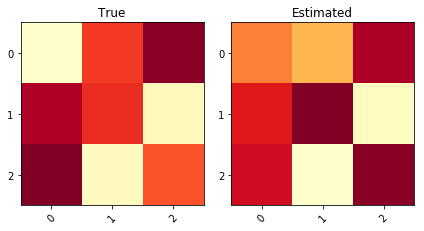

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


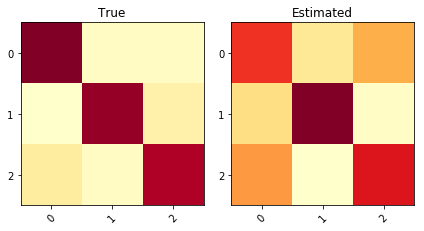

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


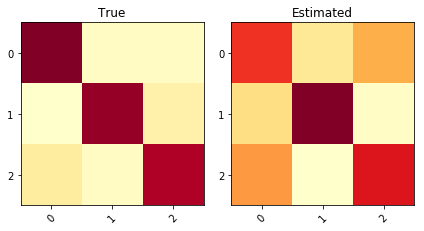

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


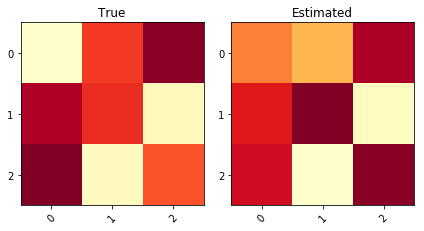

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


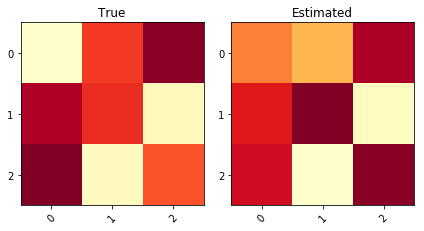

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


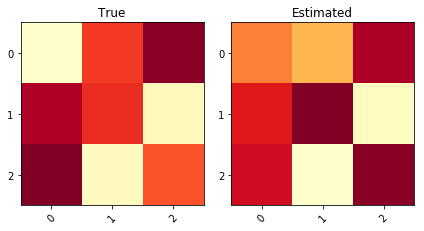

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


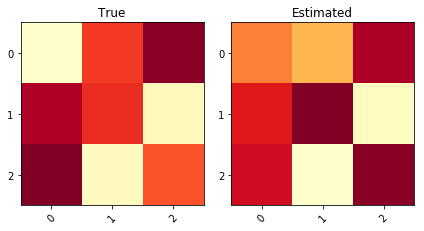

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


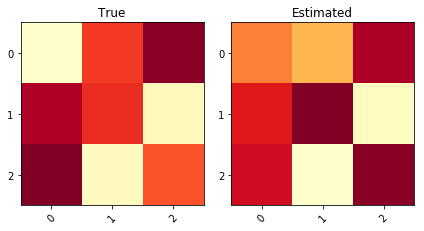

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


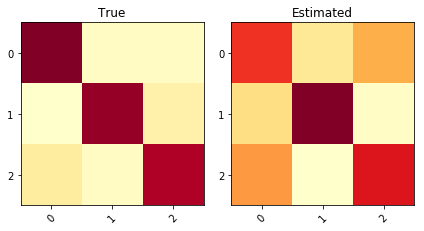

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


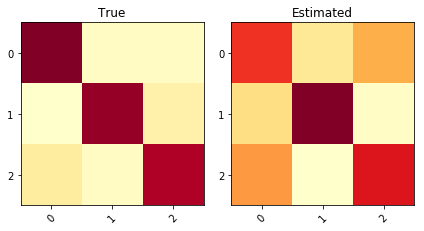

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


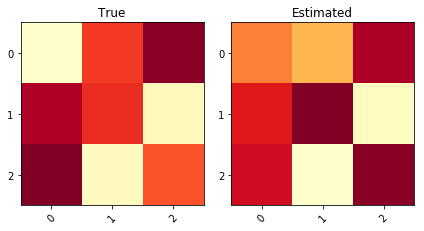

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


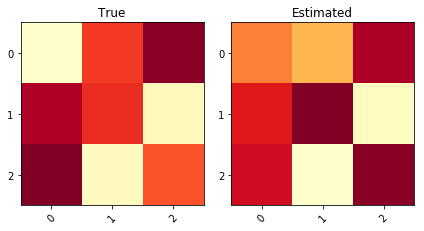

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


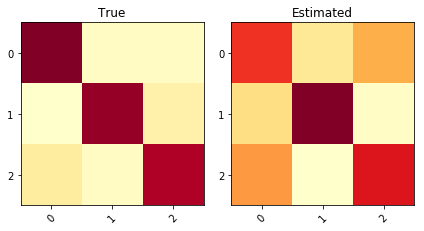

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


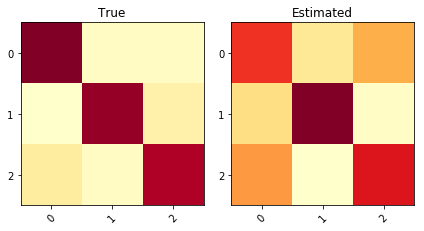

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


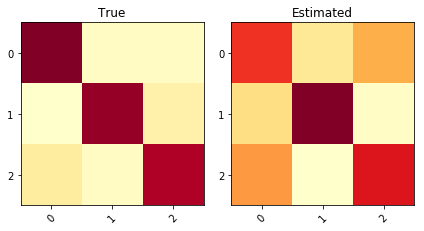

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


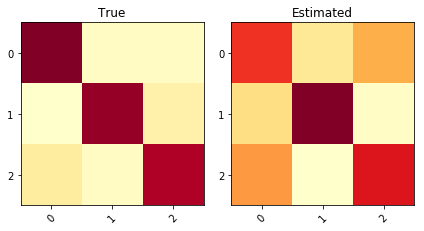

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


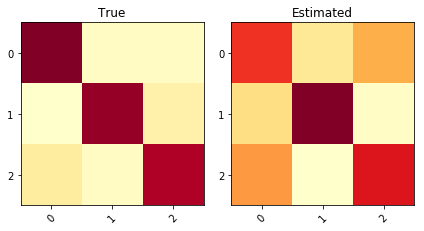

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


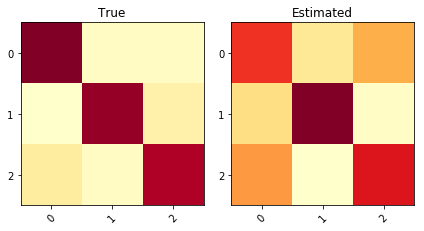

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


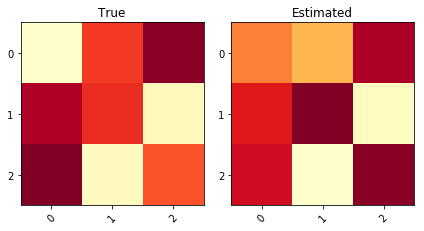

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


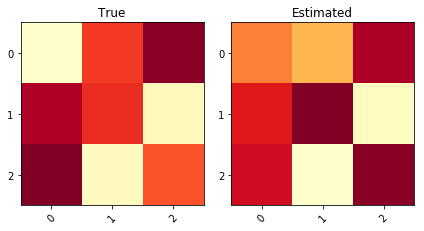

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


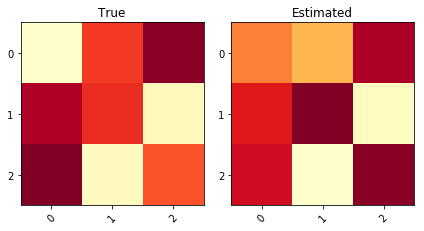

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


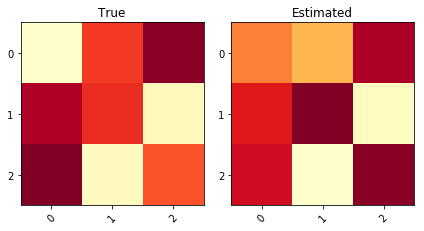

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


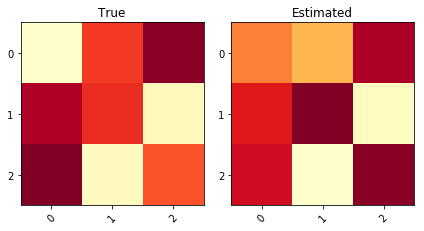

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


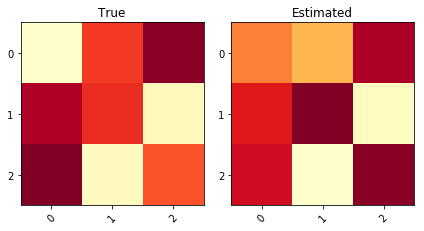

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


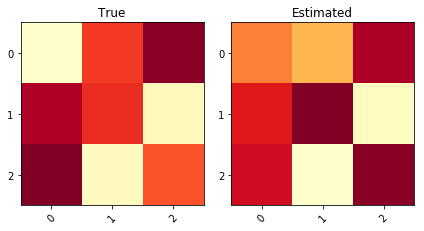

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


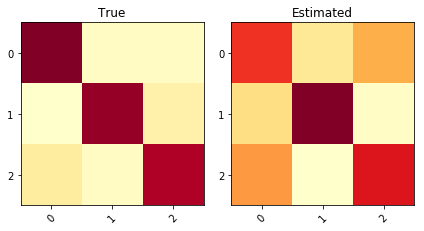

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


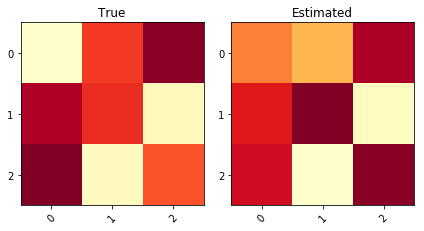

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


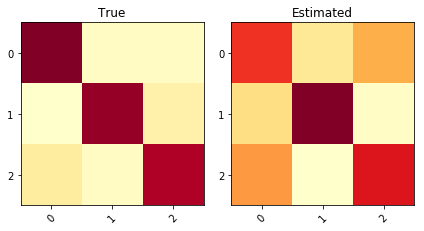

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


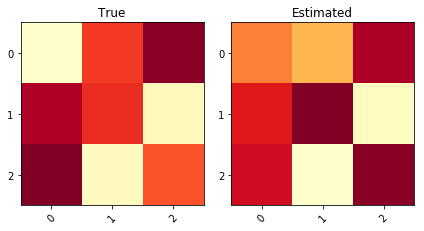

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


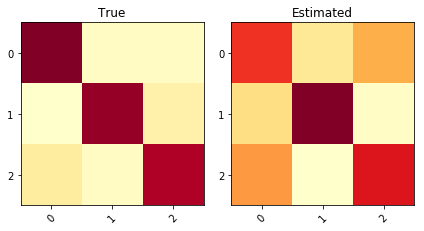

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


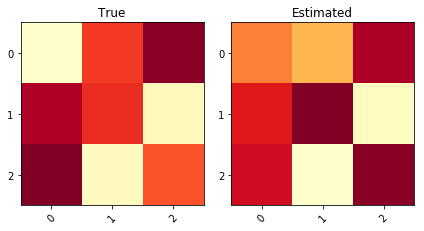

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


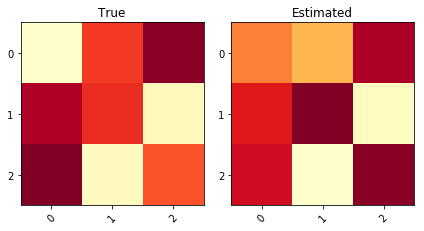

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


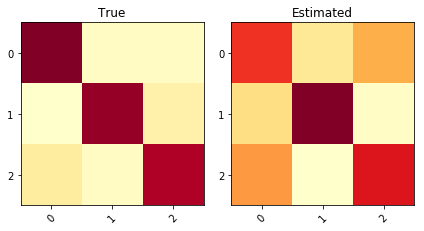

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


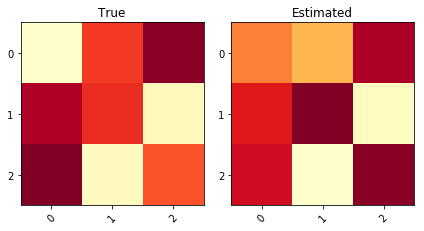

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


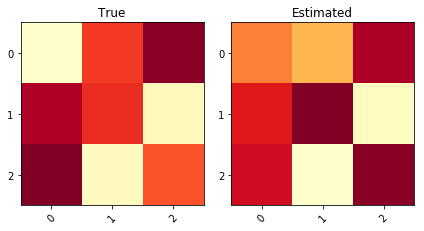

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


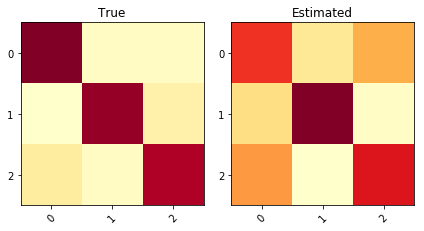

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


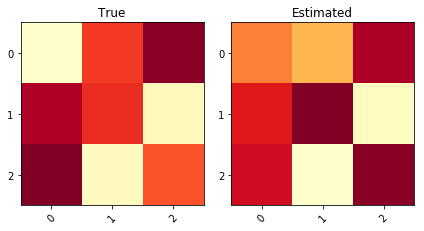

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


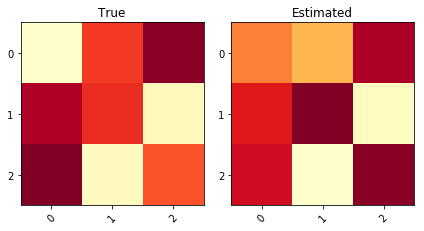

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


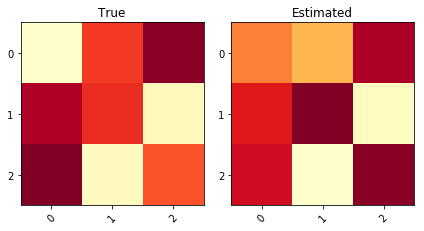

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


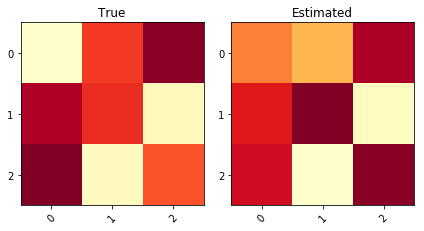

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


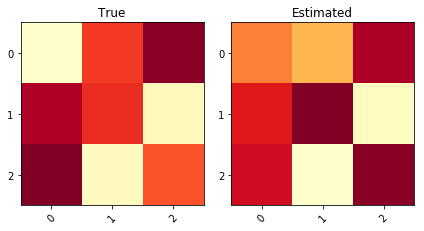

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


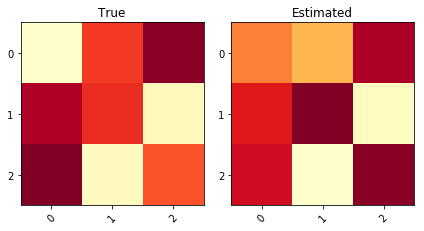

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


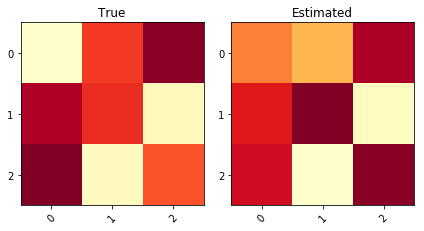

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


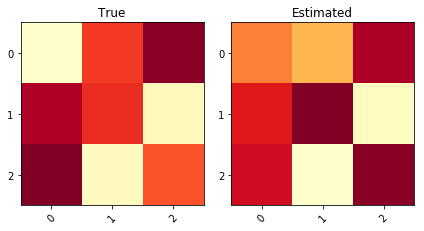

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


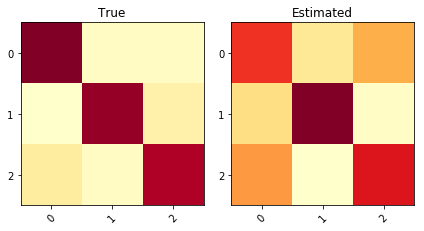

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


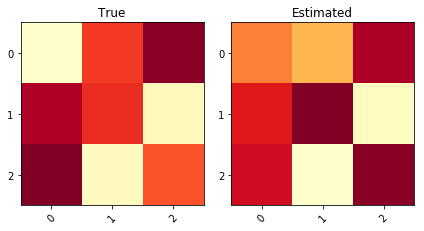

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


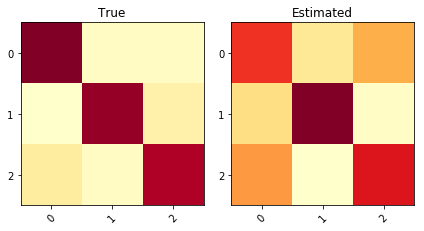

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


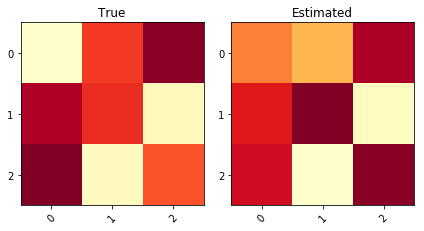

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


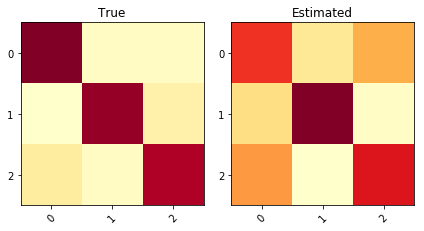

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


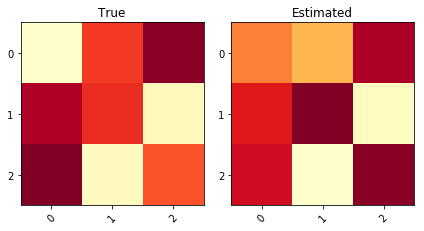

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


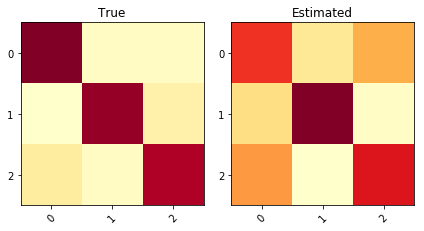

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.894444 |           0.894314 |
|  1 |       1 |   0.600741 |           0.538118 |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.891481 |           0.892084 |     0.185925 |              0.521372 |       0.143939 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.3 s, sys: 517 ms, total: 31.8 s
Wall time: 31.3 s


In [80]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


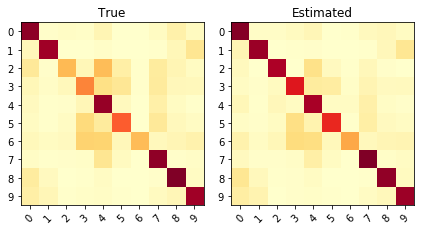

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


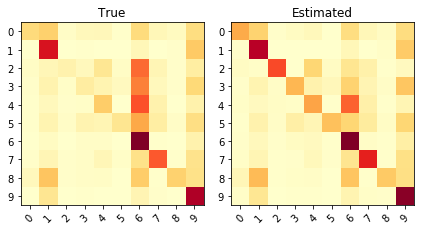

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


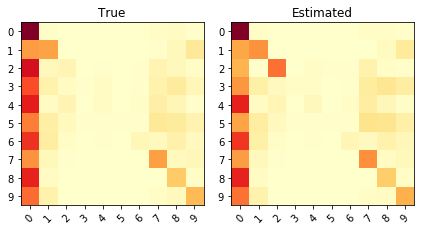

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


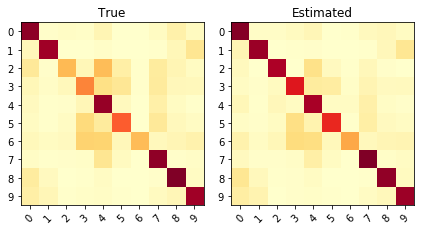

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1114	Pearson Correlation between diagonals: 0.4132


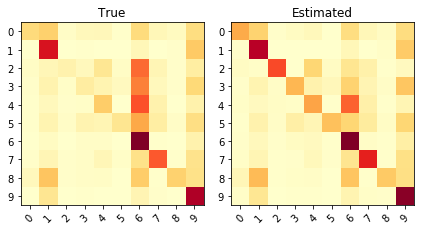

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


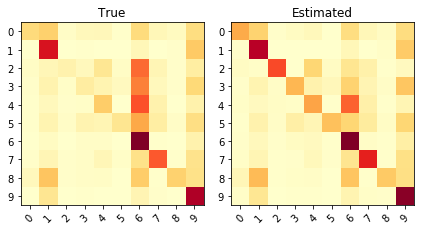

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


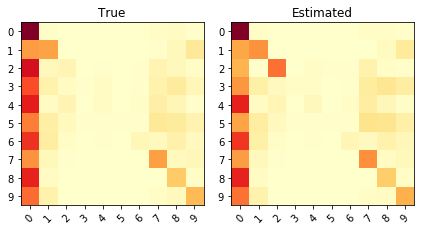

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


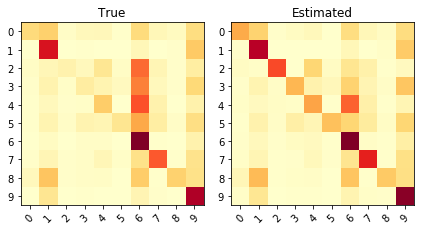

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


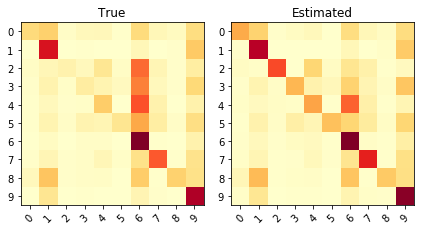

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


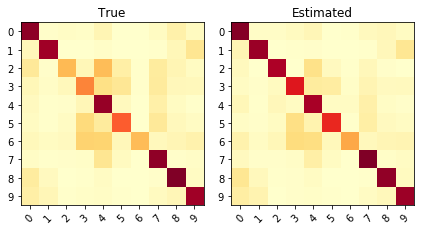

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


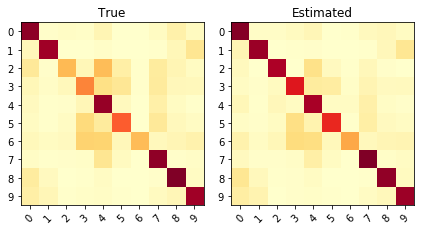

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


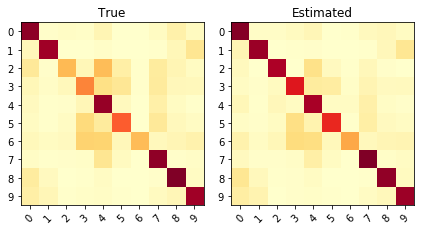

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


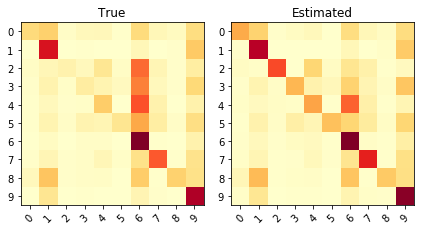

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


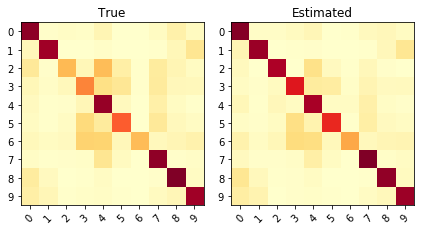

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


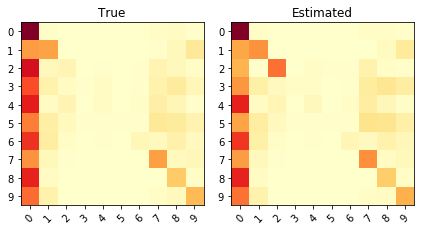

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation betwee

In [37]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [31]:
gMixture = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=4,epochs=1,optimizer=OPT,pre_init=8)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
#gMixture.define_model("simple cnn",start_units=32,deep=3,BatchN=True,drop=0.25)
logL_hist = gMixture.multiples_run(10,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca]) #more runs

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 8 epochs... Done!
Lambda by group:  [0.1378987600466675, 0.24523473249025382, 0.8920139342354865, 0.12216360576995895]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done	E step: done, (in 19.07 sec)	logL: -2638904.850	
Iter 2/50
M step: done	E step: done, (in 19.08 sec)	logL: -2610500.685	Tol: 0.01076	
Iter 3/50
M step: done	E step: done, (in 19.63 sec)	logL: -2591147.926	Tol: 0.00741	
Iter 4/50
M step: done	E step: done, (in 19.23 sec)	logL: -2583362.544	Tol: 0.00300	
Iter 5/50
M step: done	E step: done, (in 18.98 sec)	logL: -2565883.684	Tol: 0.00677	
Iter 6/50
M step: done	E step: done, (in 19.05 sec)	logL: -2578962.508	Tol: 0.00510	
Iter 7/50
M step: done	E step: done, (in 18.66 sec)	logL: -2561385.656	Tol: 0.00682	
Iter 8/50
M step: done	E step: done, (in 18.67 sec)	logL: -2549138.193	Tol: 0.00478	
Iter 9/50
M step: done	E step: done, (in 18.30 sec)	l

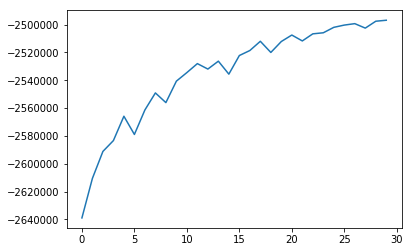

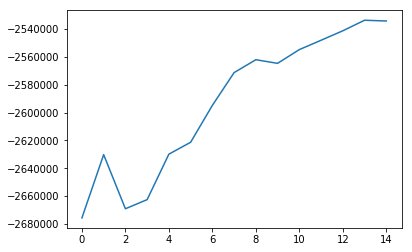

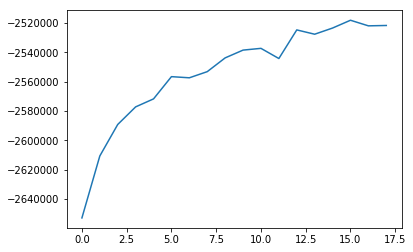

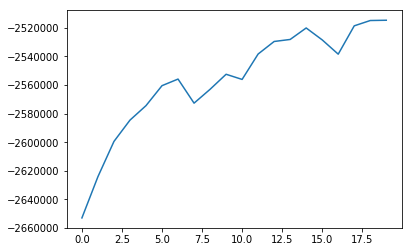

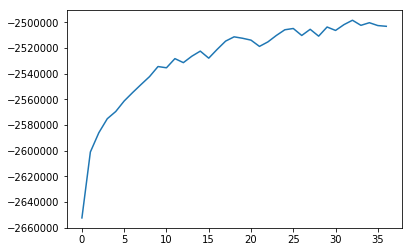

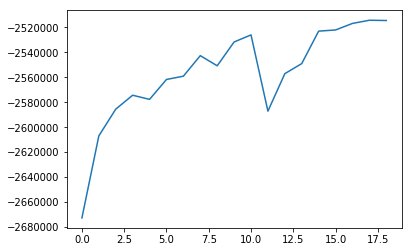

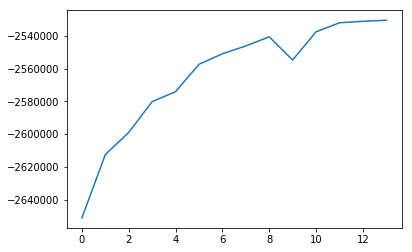

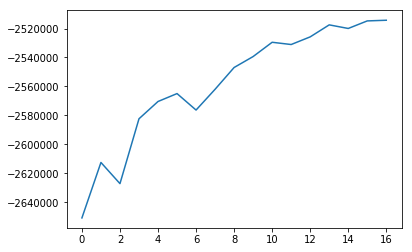

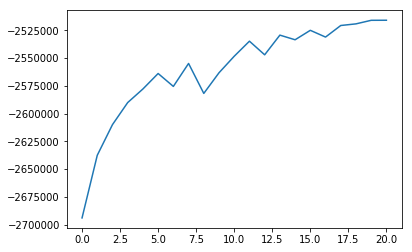

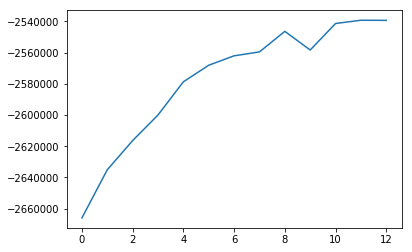

In [32]:
for value in logL_hist:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()
#plt.plot(logL_hist)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


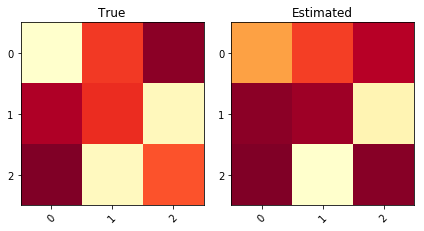

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


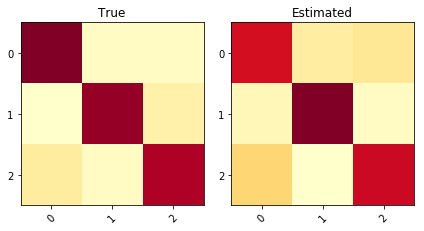

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


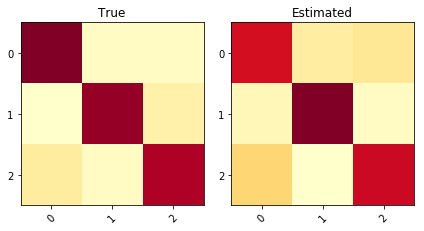

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


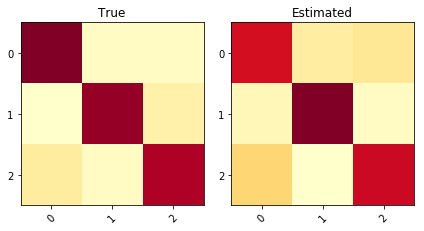

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


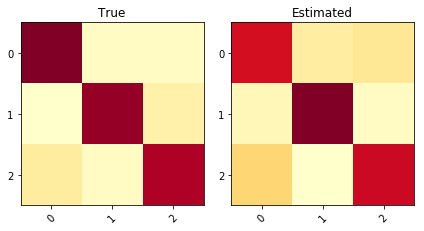

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


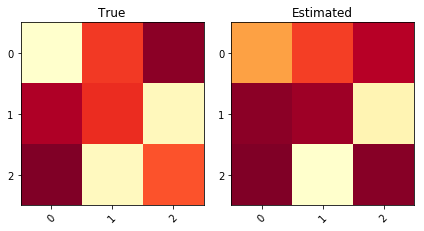

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


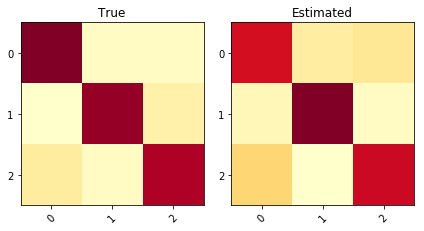

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


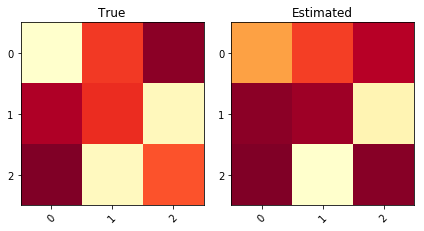

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


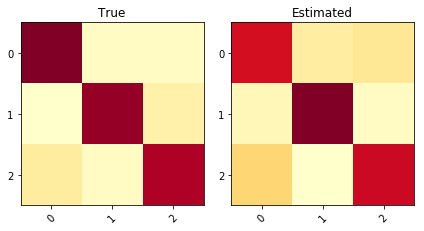

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


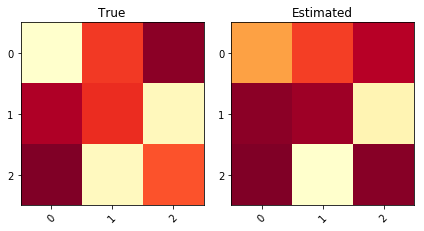

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


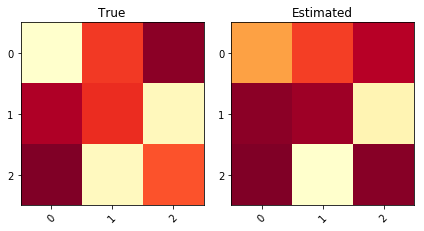

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


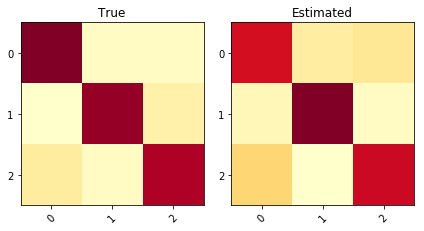

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


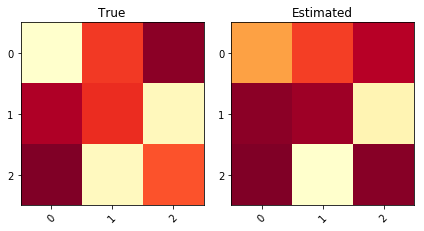

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


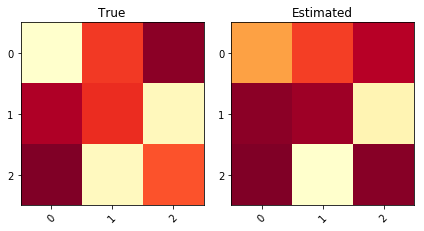

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


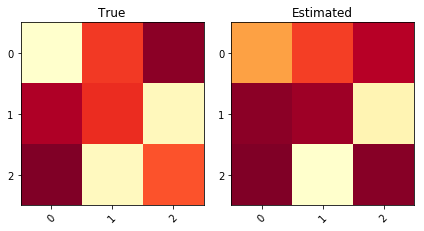

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


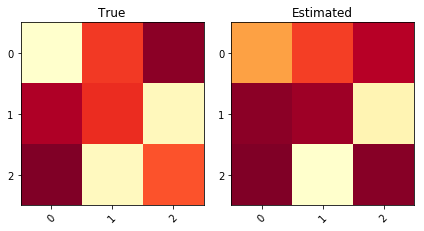

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


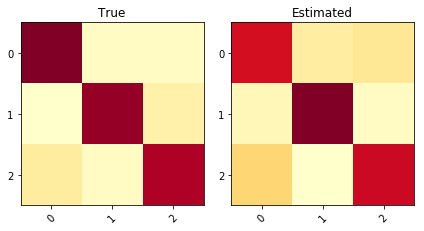

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


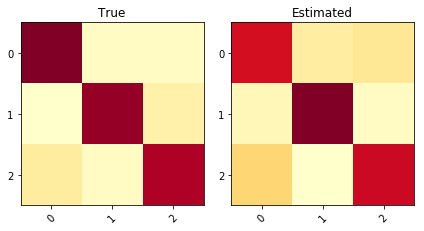

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


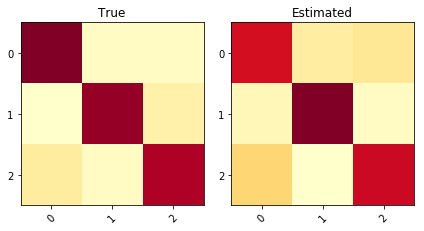

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


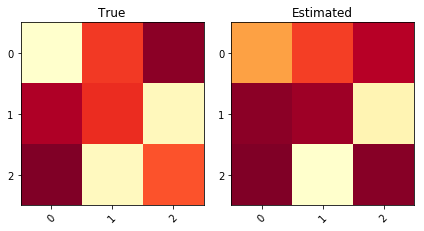

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


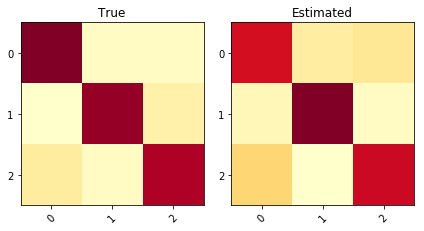

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


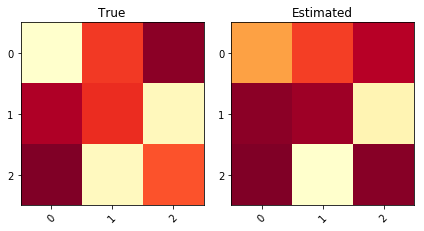

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


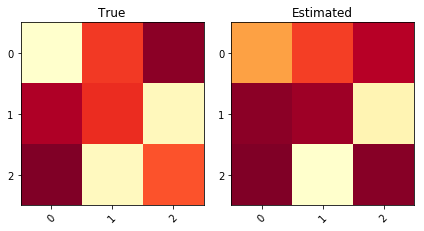

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


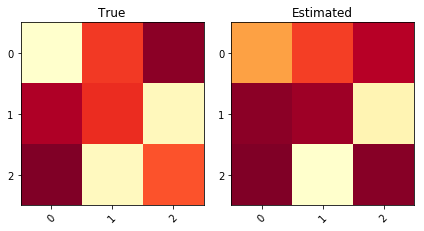

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


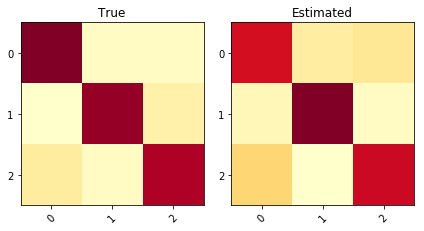

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


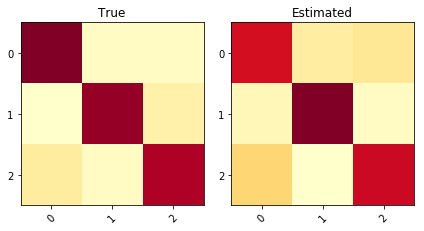

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


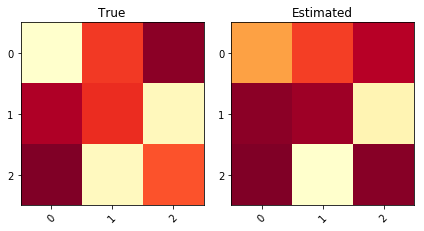

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


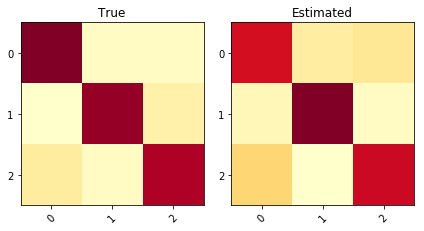

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


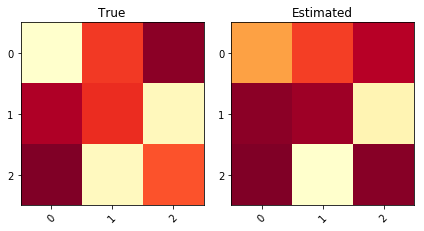

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


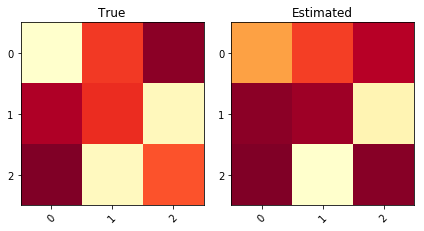

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


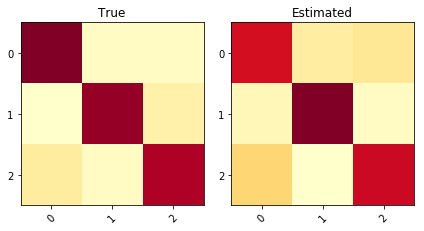

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


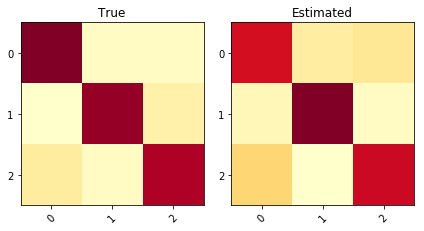

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


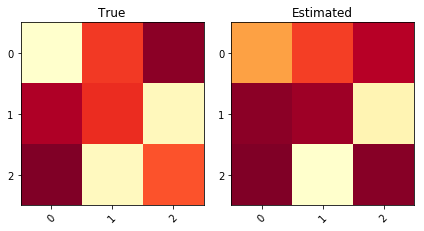

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


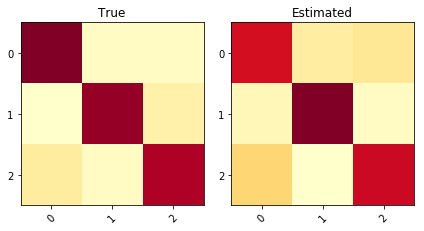

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


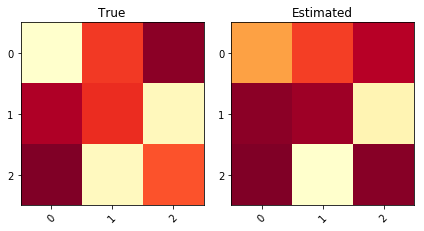

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


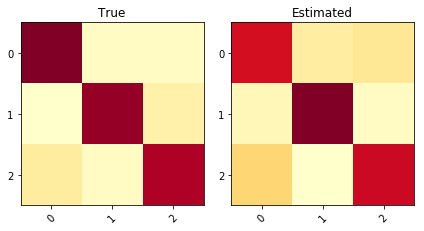

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


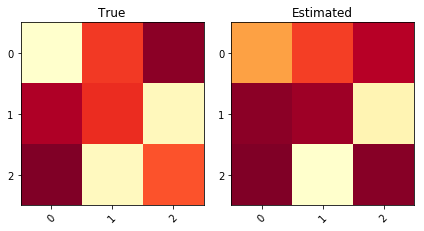

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


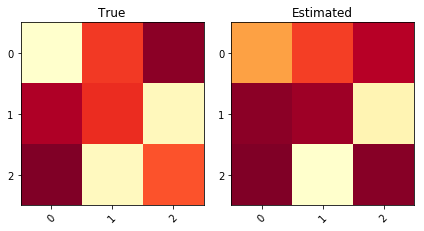

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


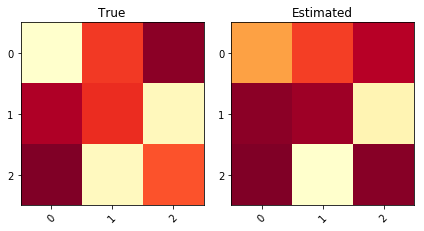

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


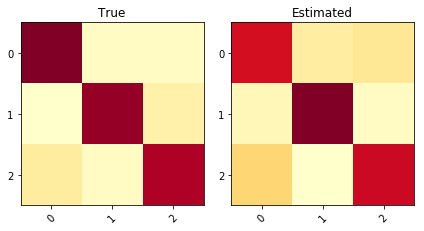

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


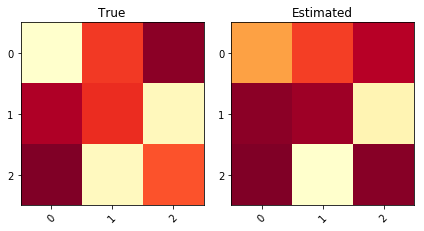

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


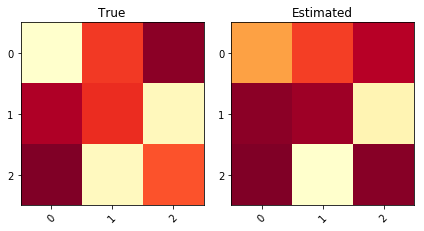

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


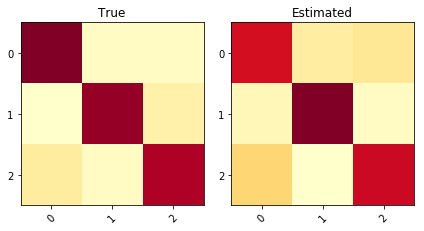

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


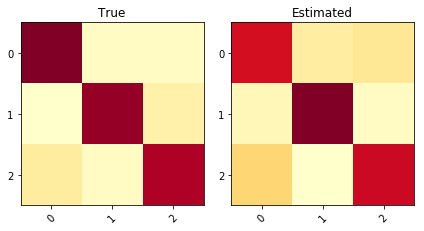

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


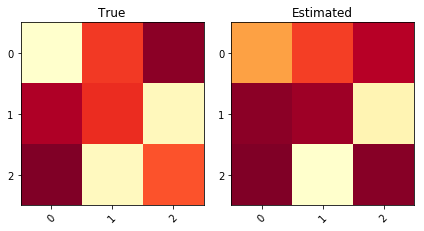

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


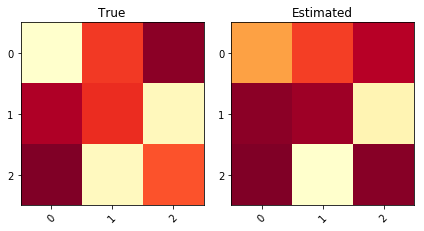

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


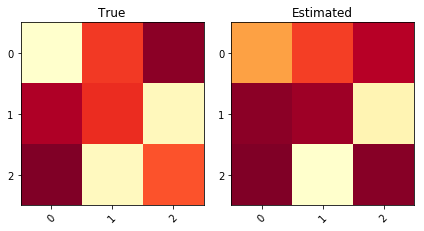

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


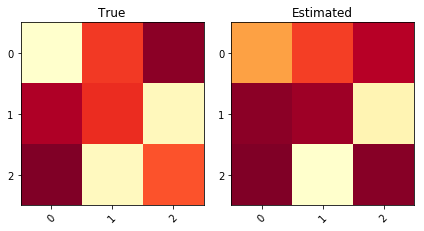

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


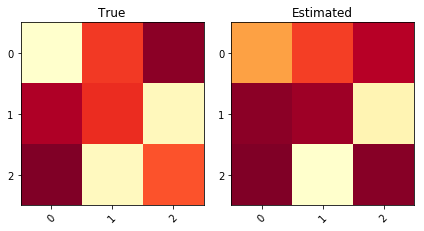

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


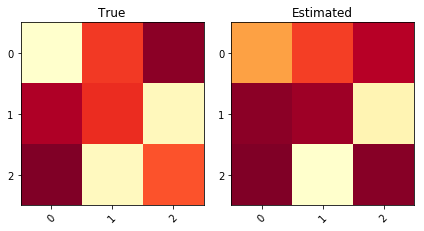

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


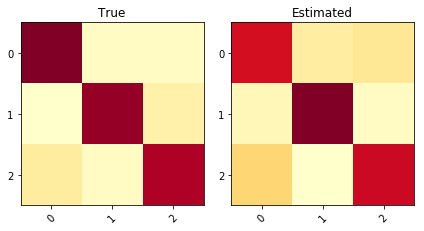

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


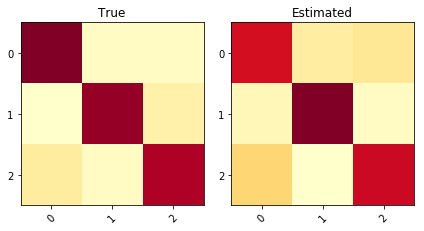

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


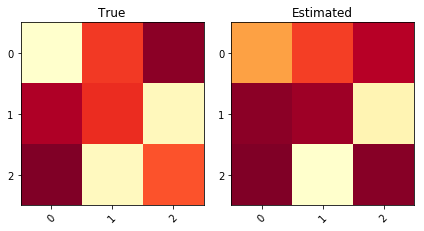

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


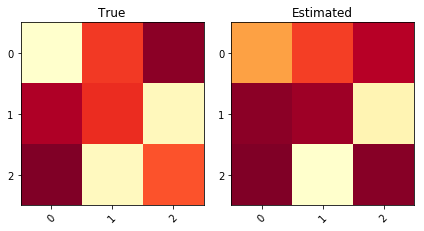

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


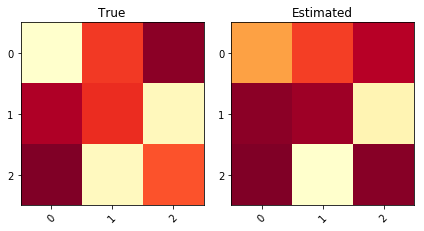

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


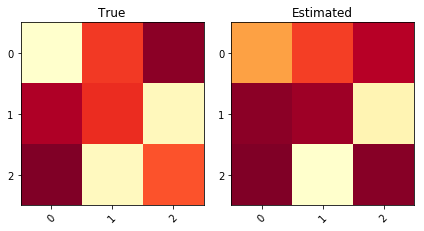

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


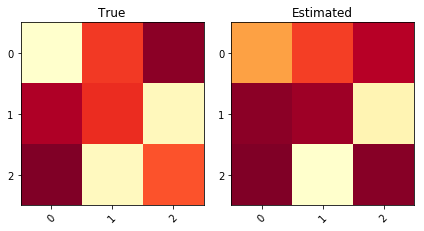

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


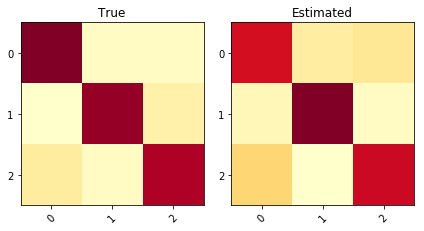

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


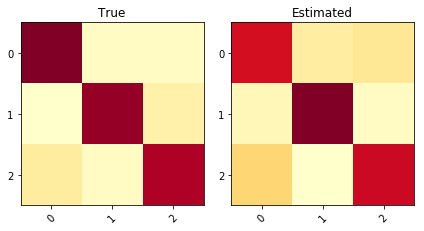

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


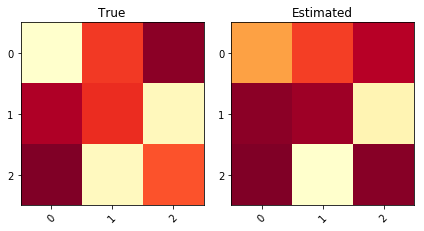

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


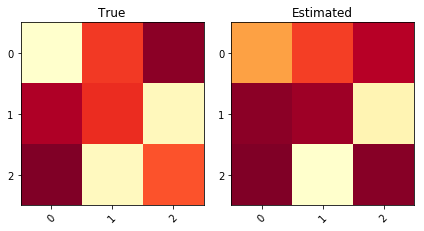

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


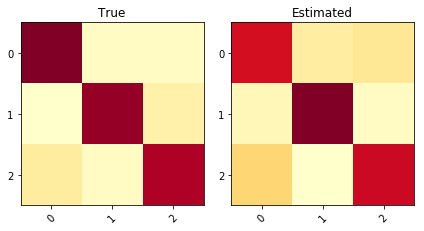

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


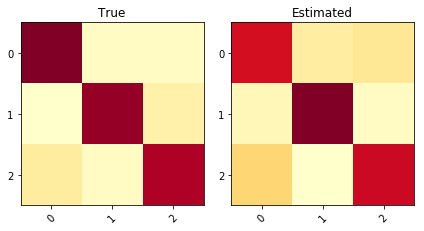

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


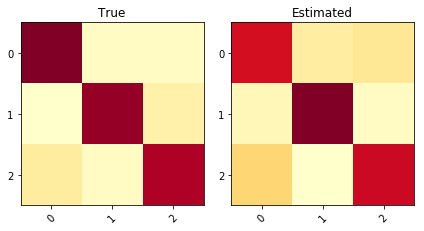

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


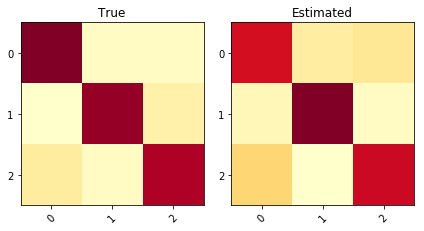

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


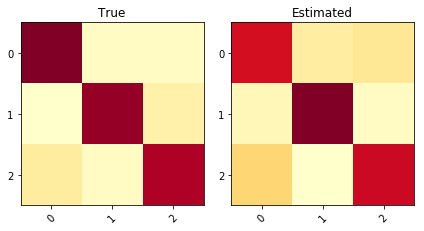

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


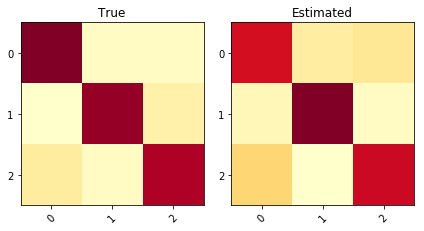

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


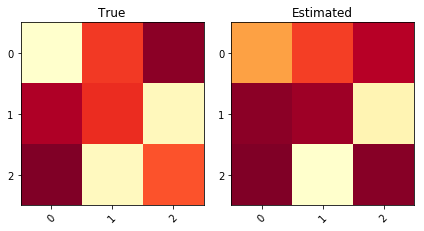

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


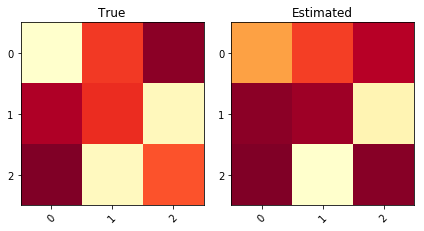

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


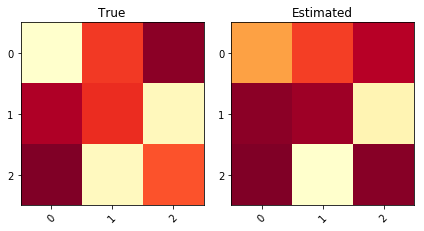

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


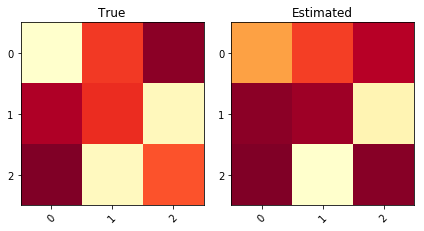

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


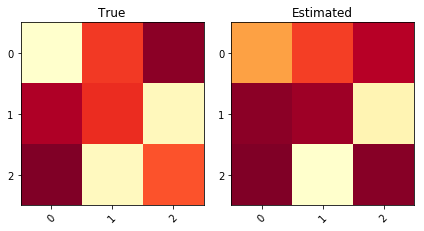

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


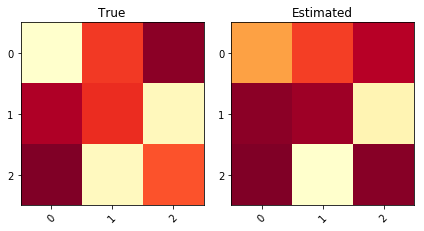

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


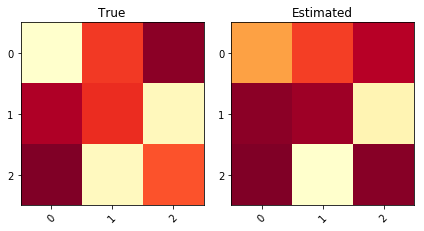

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


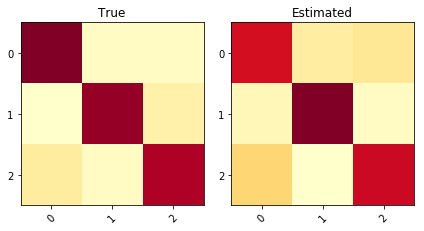

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


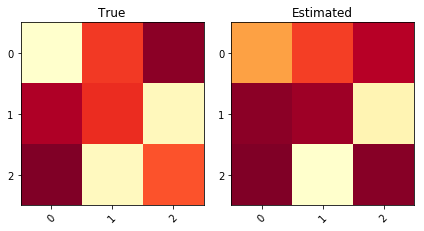

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


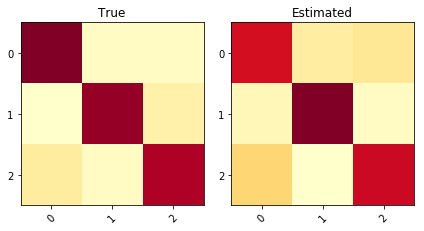

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


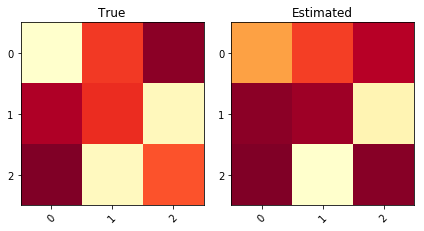

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


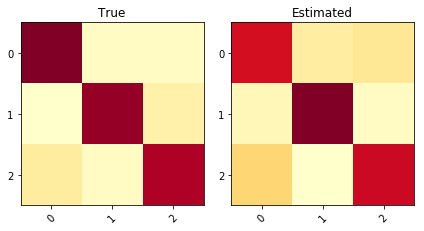

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


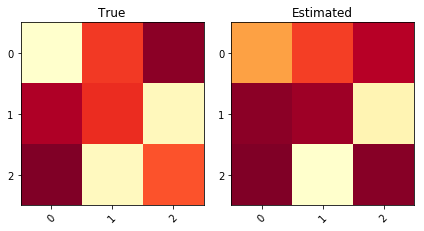

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


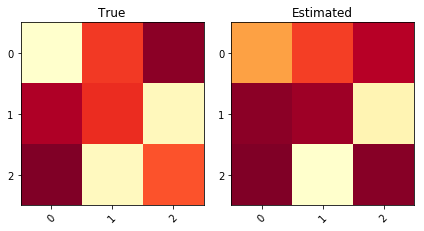

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


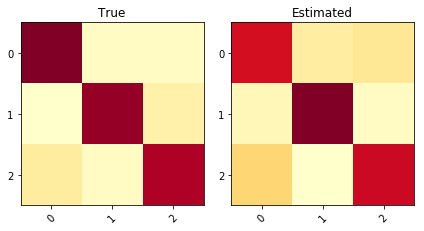

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


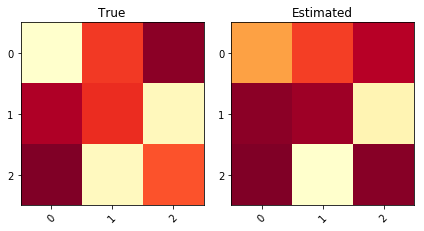

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


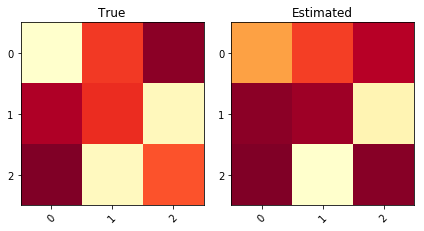

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


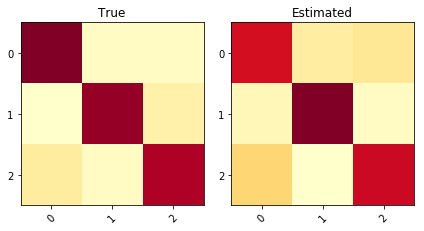

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


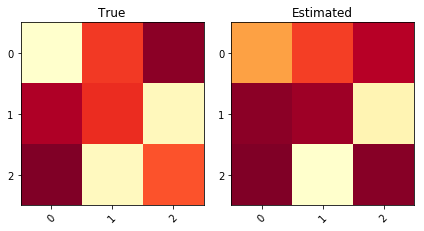

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


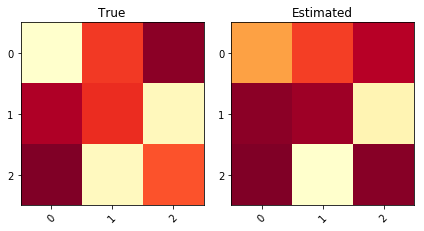

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


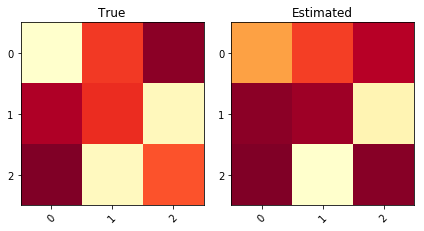

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


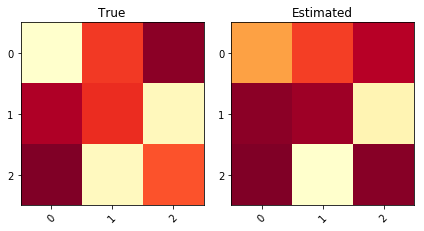

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


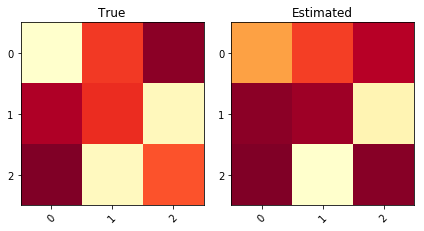

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


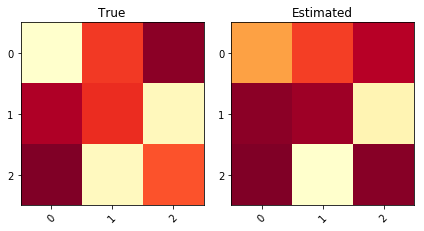

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


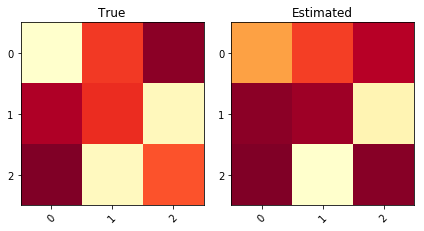

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


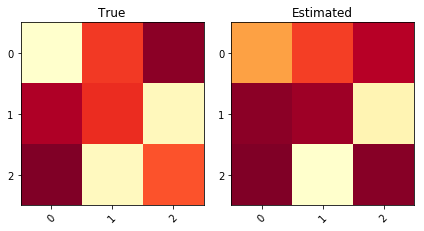

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


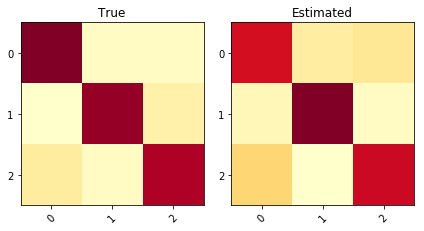

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


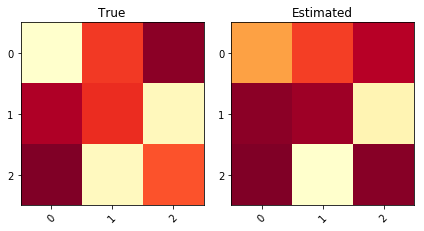

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


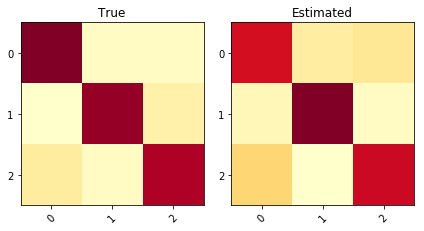

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


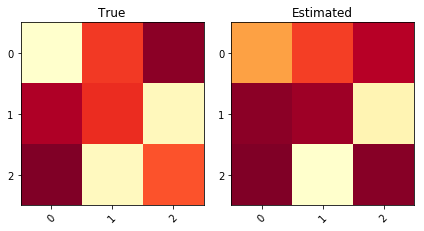

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


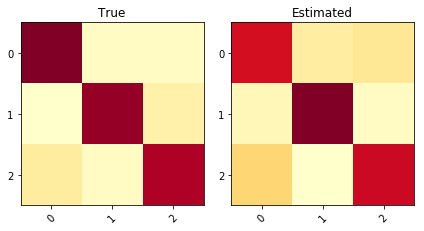

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


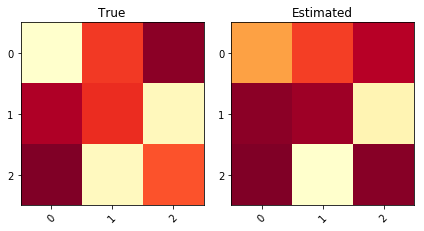

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


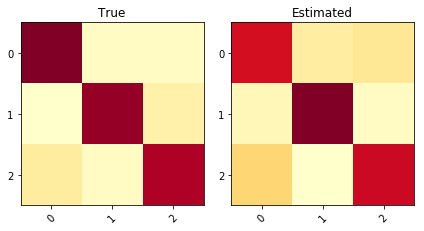

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.29963  |           0.220811 |
|  1 |       1 |   0.897037 |           0.89708  |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.894444 |           0.894994 |     0.094598 |              0.565182 |        0.16847 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.4 s, sys: 555 ms, total: 31.9 s
Wall time: 31.4 s


In [74]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

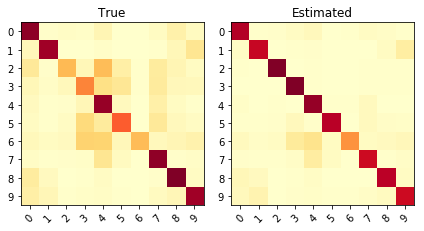

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


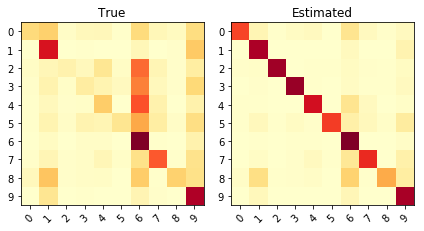

KL divergence: 0.6230	Pearson Correlation between diagonals: 0.3983


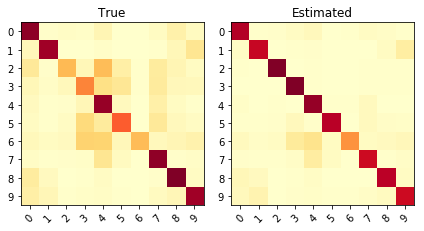

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


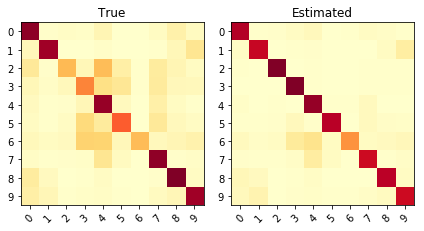

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


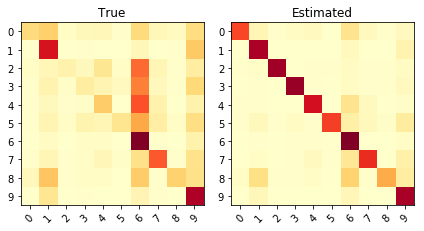

KL divergence: 0.6187	Pearson Correlation between diagonals: 0.4000


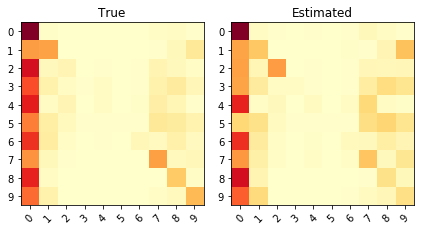

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


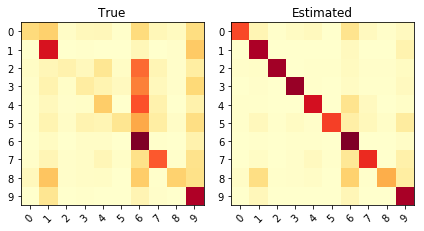

KL divergence: 0.6106	Pearson Correlation between diagonals: 0.4034


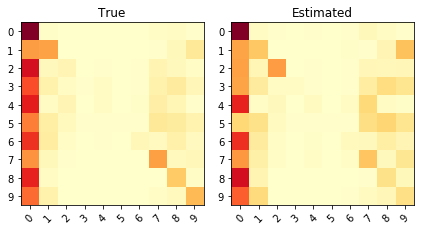

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


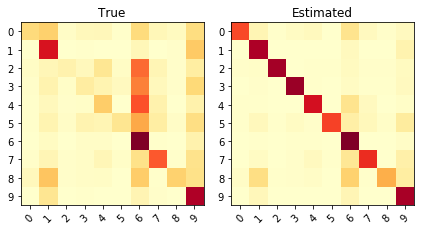

KL divergence: 0.6022	Pearson Correlation between diagonals: 0.4069


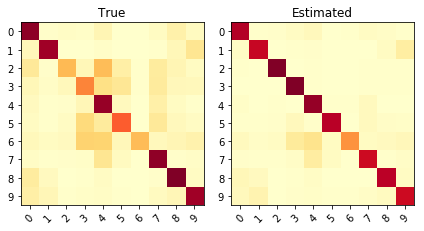

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


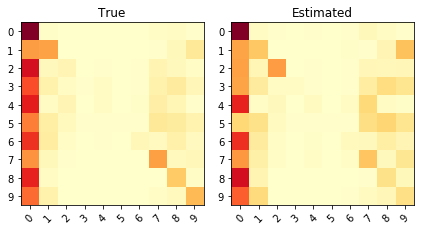

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


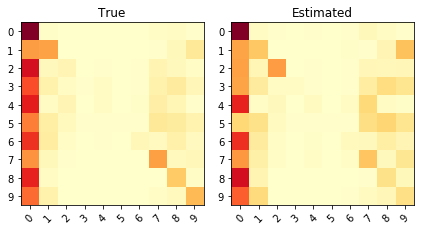

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


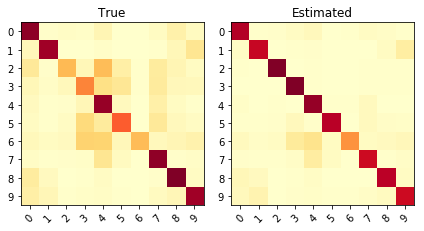

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


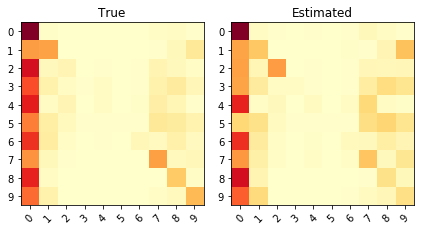

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


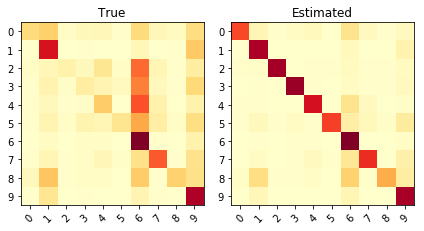

KL divergence: 0.6063	Pearson Correlation between diagonals: 0.4052
A result
 +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |    0.63382 |            0.63382 |
|  1 |       1 |    0.8407  |            0.8407  |
|  2 |       2 |    0.1     |            0.1     |
|  3 |       3 |    0.65312 |            0.65312 |
+----+---------+------------+--------------------+
A result
 +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |    0.75984 |            0.75984 |     0.429922 |              0.428081 |       0.143167 |
+----+--------+------------+--------------------+--------------+----------------

In [34]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

### Multiples runs experiment
---

In [15]:
from sklearn.metrics import accuracy_score
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for _ in range(20):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
print("Done!")

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.082216 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31109676 0.03493858 0.1967701 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.26 sec)	logL: -24953.606	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24158.538	Tol1: 0.03186	Tol2: 0.47721	Tol3: 0.08295	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23732.416	Tol1: 0.01764	Tol2: 0.18929	Tol3: 0.04638	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23402.033	Tol1: 0.01392	Tol2: 0.11233	Tol3: 0.03035	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23088.188	Tol1: 0.01341	Tol2: 0.08024	Tol3: 0.02151	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22773.406	Tol1: 0.01363	Tol2: 0.07462	Tol3: 0.01808	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.12418284 0.35010934 0.11075781]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.13 sec)	logL: -25752.769	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25085.038	Tol1: 0.02593	Tol2: 0.29027	Tol3: 0.04527	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24617.868	Tol1: 0.01862	Tol2: 0.15167	Tol3: 0.02058	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24248.547	Tol1: 0.01500	Tol2: 0.08946	Tol3: 0.01117	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23905.033	Tol1: 0.01417	Tol2: 0.07349	Tol3: 0.00743	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23581.206	Tol1: 0.01355	Tol2: 0.06532	Tol3: 0.00555	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23259.147	Tol1: 0.01366	Tol2: 0.05980	Tol3: 0.00496	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22941.399	Tol1: 0.01366	To

M step: done,  E step: done //  (in 4.11 sec)	logL: -23642.878	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23182.674	Tol1: 0.01946	Tol2: 0.18773	Tol3: 0.03919	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22936.280	Tol1: 0.01063	Tol2: 0.12586	Tol3: 0.01035	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22731.922	Tol1: 0.00891	Tol2: 0.11156	Tol3: 0.00446	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22541.425	Tol1: 0.00838	Tol2: 0.10167	Tol3: 0.00411	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22367.754	Tol1: 0.00770	Tol2: 0.09632	Tol3: 0.00411	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22206.711	Tol1: 0.00720	Tol2: 0.09311	Tol3: 0.00378	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22057.819	Tol1: 0.00670	Tol2: 0.09050	Tol3: 0.00466	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21923.754	Tol1: 0.00608	Tol2: 0.08963	Tol3: 0.00558	
Iter 10/

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97844094 0.0489267  0.1579087 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.86 sec)	logL: -24076.808	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23215.659	Tol1: 0.03577	Tol2: 0.46952	Tol3: 0.11054	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22649.111	Tol1: 0.02440	Tol2: 0.19937	Tol3: 0.06650	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22206.827	Tol1: 0.01953	Tol2: 0.11422	Tol3: 0.03920	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21816.984	Tol1: 0.01756	Tol2: 0.09504	Tol3: 0.02658	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21446.053	Tol1: 0.01700	Tol2: 0.08991	Tol3: 0.02085	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21113.537	Tol1: 0.01550	Tol2: 0.08323	Tol3: 0.01841	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	l

M step: done,  E step: done //  (in 0.12 sec)	logL: -20183.013	Tol1: 0.00168	Tol2: 0.03627	Tol3: 0.01141	
Iter 42/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20150.217	Tol1: 0.00162	Tol2: 0.03547	Tol3: 0.01078	
Iter 43/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20114.709	Tol1: 0.00176	Tol2: 0.03305	Tol3: 0.00927	
Iter 44/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20084.558	Tol1: 0.00150	Tol2: 0.03334	Tol3: 0.00960	
Iter 45/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20054.601	Tol1: 0.00149	Tol2: 0.03288	Tol3: 0.00911	
Iter 46/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20031.070	Tol1: 0.00117	Tol2: 0.03282	Tol3: 0.00844	
Iter 47/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20000.067	Tol1: 0.00155	Tol2: 0.03196	Tol3: 0.00756	
Iter 48/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19973.820	Tol1: 0.00131	Tol2: 0.03075	Tol3: 0.00587	
Iter 49/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19950.423	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -24210.752	Tol1: 0.02434	Tol2: 0.15473	Tol3: 0.01035	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23747.166	Tol1: 0.01915	Tol2: 0.10122	Tol3: 0.01451	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23320.843	Tol1: 0.01795	Tol2: 0.09174	Tol3: 0.01428	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22927.339	Tol1: 0.01687	Tol2: 0.09400	Tol3: 0.01288	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22562.702	Tol1: 0.01590	Tol2: 0.09682	Tol3: 0.01148	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22210.477	Tol1: 0.01561	Tol2: 0.09933	Tol3: 0.01025	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21905.965	Tol1: 0.01371	Tol2: 0.09632	Tol3: 0.00985	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21639.645	Tol1: 0.01216	Tol2: 0.08707	Tol3: 0.00848	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21407.884	Tol1: 0

In [13]:
colors = [cm.tab20(i) for i in range(20)] # b o c o tambn "_r"

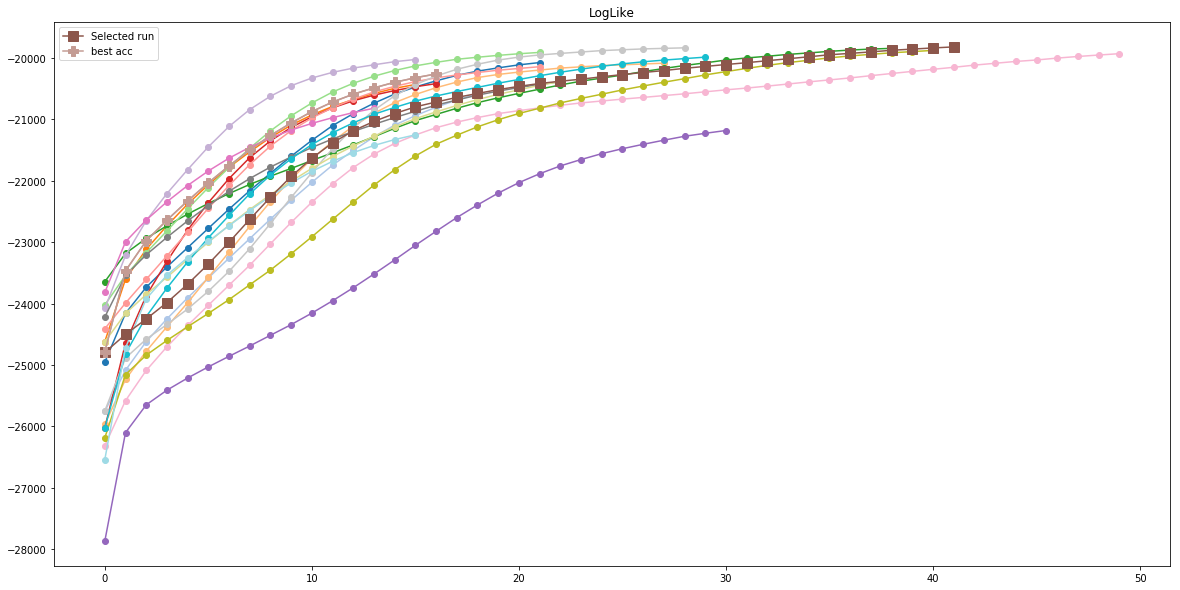

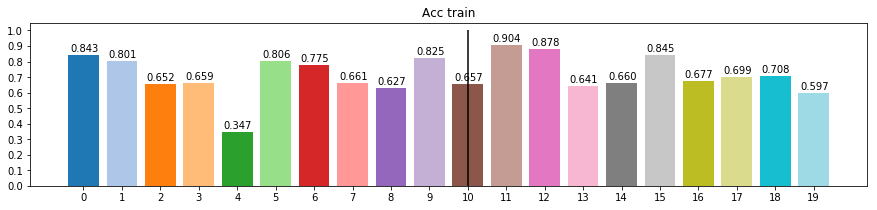

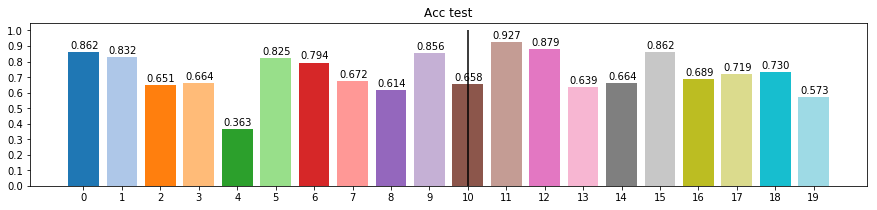

In [16]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(20,10))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

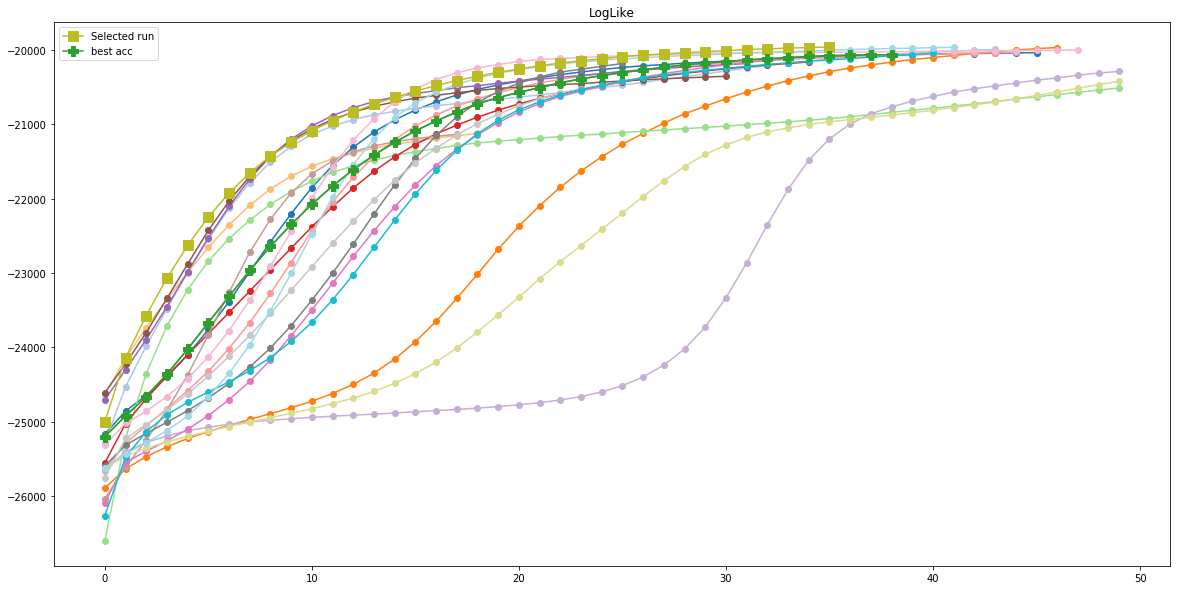

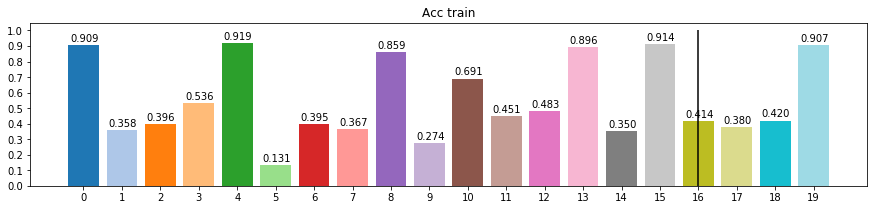

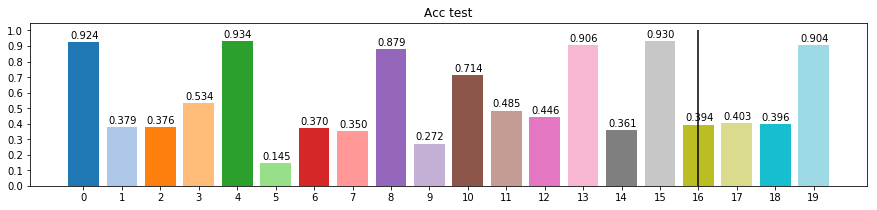

In [39]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(20,10))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

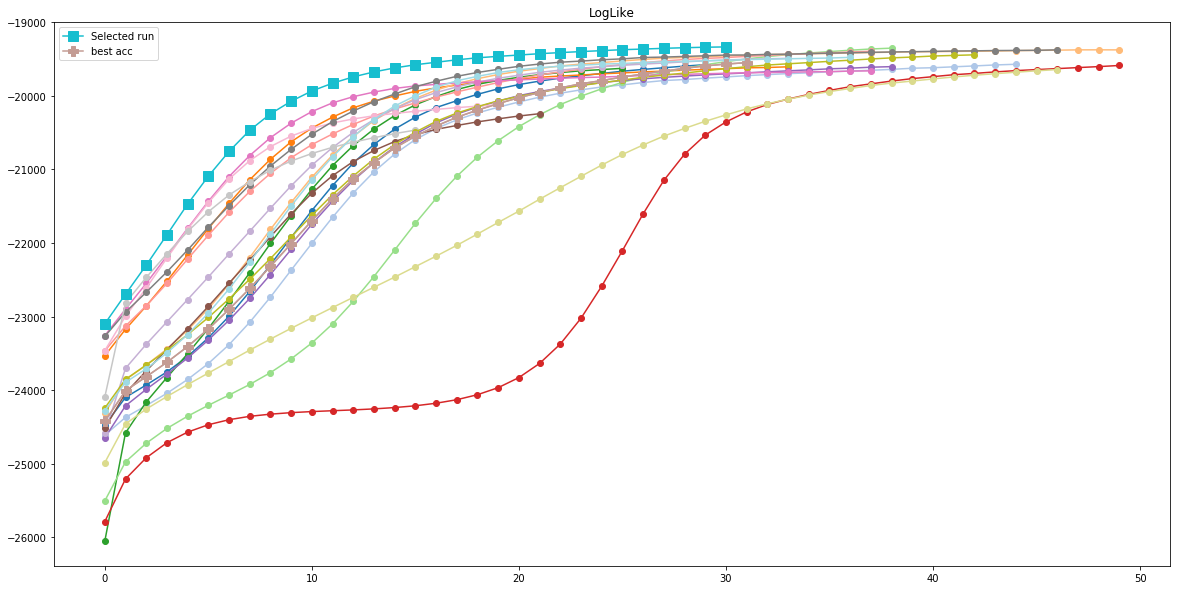

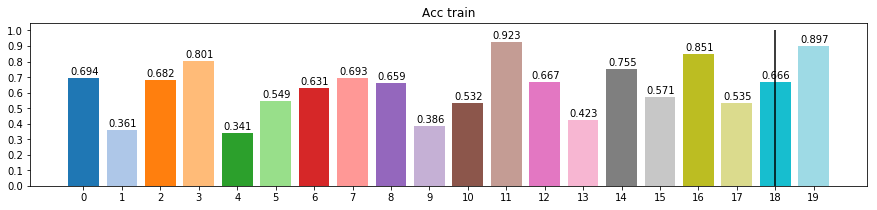

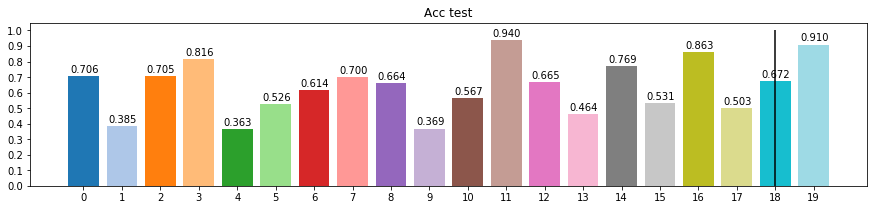

In [125]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(20,10))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    #if a != i_r:
    #plt.plot(range(len(value)),value,'o-')
    plt.bar(a,value,facecolor=colors[a])
#plt.plot(range(len(logL_encontrados[i_r])),logL_hists[i_r],'o-',label="Selected run")
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

Values over 90 acc on test:  4


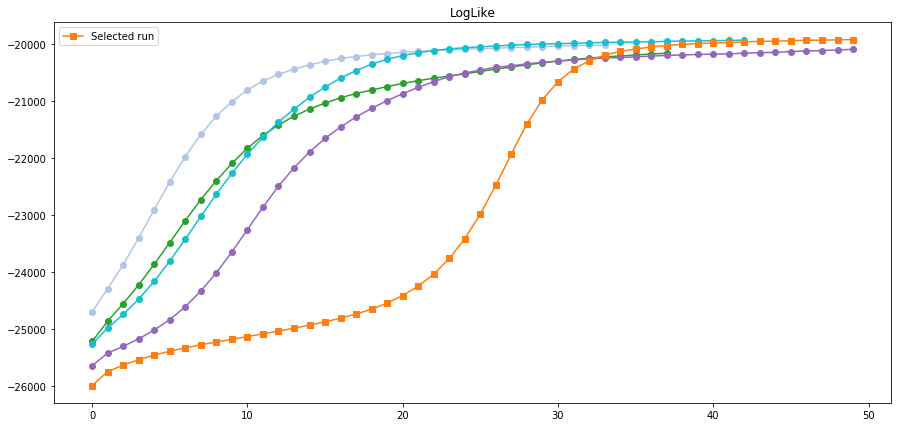

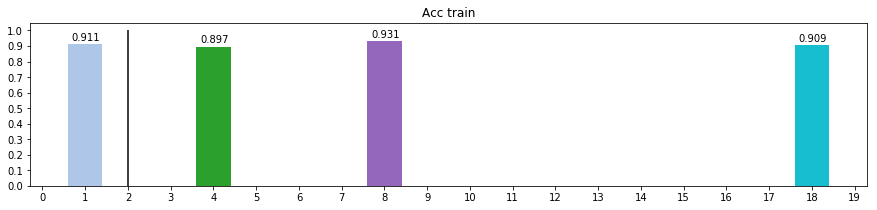

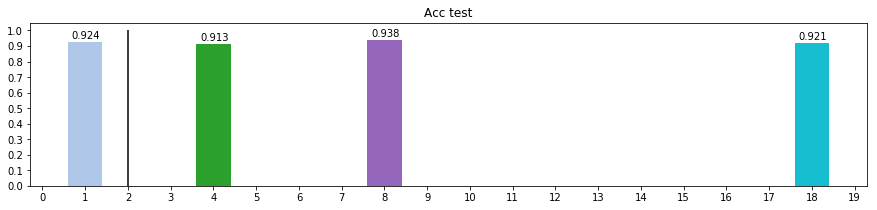

In [33]:
#just graph the high 90 acc
mask_high_values = (np.asarray(accTE_encontrados)>0.9) #and (np.asarray(accTR_encontrados>0.9))
print("Values over 90 acc on test: ",np.sum(mask_high_values))

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r and mask_high_values[a]:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
#plt.plot(range(len(logL_encontrados[i_r])),logL_hists[i_r],'o-',label="Selected run")
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

Values over 80 acc on test:  4


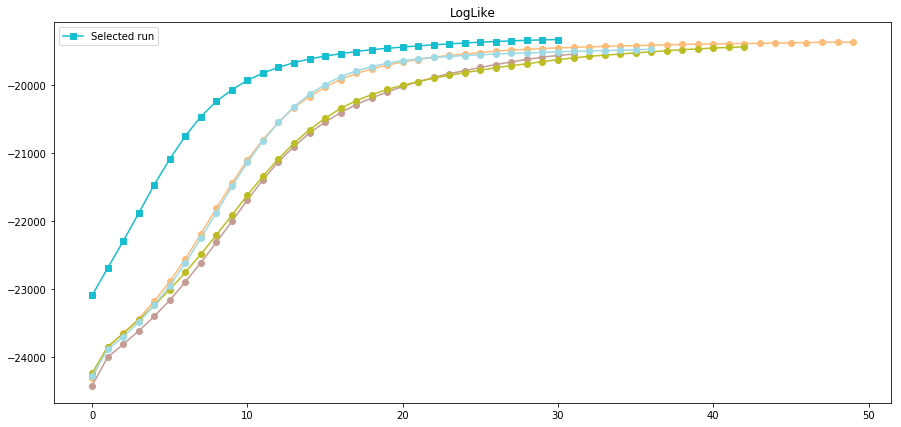

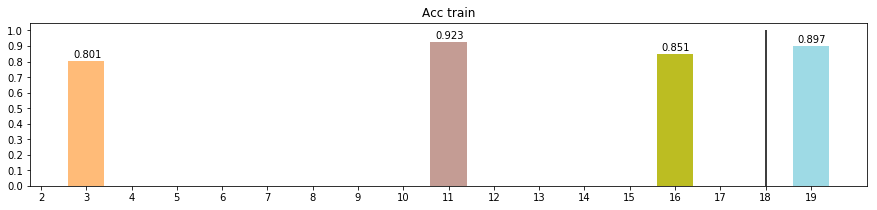

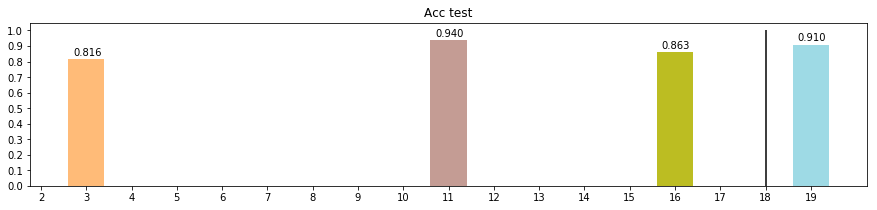

In [126]:
#just graph the high 80 acc
mask_high_values = (np.asarray(accTE_encontrados)>0.8) #and (np.asarray(accTR_encontrados>0.9))
print("Values over 80 acc on test: ",np.sum(mask_high_values))

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r and mask_high_values[a]:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

In [ ]:
what about first 3-5 iterations? #--funciona a veces :/

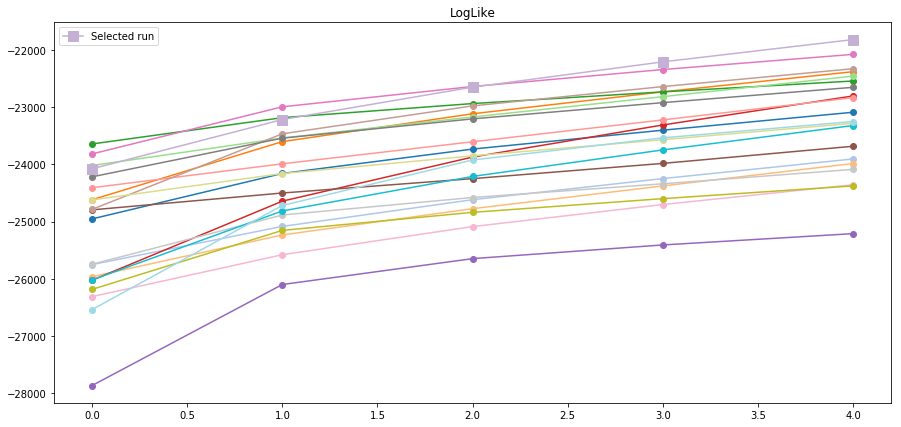

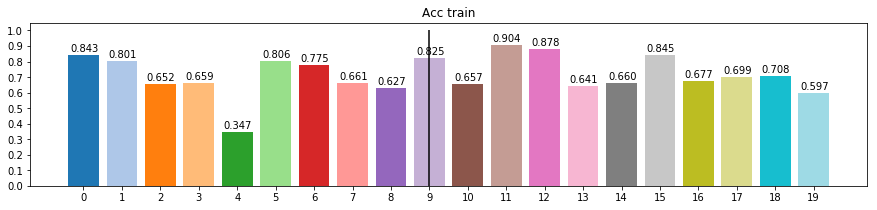

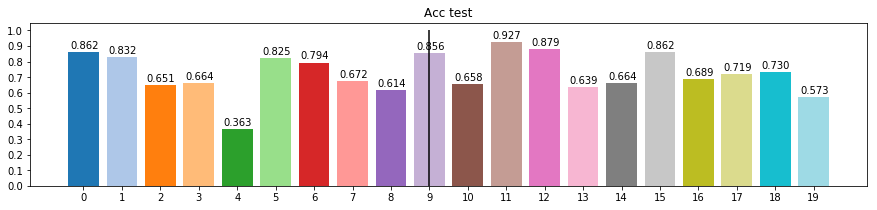

In [17]:
k_max = 5

i_r = np.argmax([value[k_max] for value in logL_encontrados])


#mask_high_values = (np.asarray(accTE_encontrados)>0.9) #and (np.asarray(accTR_encontrados>0.9))
#print("Values over 90 acc on test: ",np.sum(mask_high_values))
colors = [cm.tab20(i) for i in range(20)] # b o c o tambn "_r"

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(k_max),value[:k_max],'o-',c=colors[a])
plt.plot(range(k_max),logL_encontrados[i_r][:k_max],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

In [128]:
#what about tolerance conv -- el 2do es bueno (mismo que arriba) --- el 1ero es mejor en very bad MV
aux = np.asarray([(value[-1] - value[-2])/np.abs(value[-2]) for value in logL_encontrados])
print("Relative order: ",np.argsort(aux))
aux = np.asarray([(value[-1] - value[-2]) for value in logL_encontrados])
print("Difference order :",np.argsort(aux))
aux = np.asarray([(value[-1] - value[-2])/np.abs(value[-1]) for value in logL_encontrados])
print("Relative future order :",np.argsort(aux))

Relative order:  [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11 13  0 10 15]
Difference order : [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11  0 13 10 15]
Relative future order : [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11 13  0 10 15]


In [129]:
#what about delta conv mean -- los primeros 3 andan bien (solo el 1ero) -- en very bad MV el 2do es mejor..
aux = np.asarray([ np.mean([(value[i+1] - value[i])/np.abs(value[i]) for i in range(len(value)-1)]) for value in logL_encontrados])
print("Relative order: ",np.argsort(aux)[::-1])
aux = np.asarray([ np.mean([value[i+1] - value[i] for i in range(len(value)-1)]) for value in logL_encontrados])
print("Difference order :",np.argsort(aux)[::-1])

Relative order:  [ 4 15 10 13  0  5 11  9 19  8 18  6  2 16 17  1  7  3 12 14]
Difference order : [ 4 15 10 13  0  5 11  9 19  8  6 18  2 17  1 16  7  3 12 14]


In [18]:
#diversity -- 3ero es bueno
diversity_conf = [distance_2_centroid(matrix) for matrix in matrices_encontradas]
np.argsort(diversity_conf)[::-1]

array([ 8,  6,  2, 12, 11,  1,  7,  5,  9,  3, 14, 19,  0, 15, 17, 18, 13,
       10, 16,  4])

* seleccion de 1eras iteraciones: valor medio (ni muy bueno ni muy malo)
* el 1ero y 3ero de diversity anda bien, el 2do hace match con la seleccion de barras arriba
* el 1ero y 3ero de diversity anda en valor medio, el 1ero hace match con la seleccion de barras arriba
* difference convergence: solo 1ero anda  bien
* difference convergence: los primeros no andan nada bien (bastante mal)
* tolerance convergence: 2 priemros valors andan bien
* tolerance convergence: el primero anda bien

#manera hibrida.. diveristy con log-like

#5 mejores diveristy con mayor logL
best_div = np.argsort(diversity_conf)[::-1][:5]


best_logL =  np.argsort([value[-1] for value in np.asarray(logL_encontrados)])[::-1]

[index for index in best_logL if index in best_div] #noooooo

#log-like outside -- igual que loglike
def calculate_loglike(base_model,betas,alphas,X,r):
    predictions = base_model.predict(X)
    p_new = np.clip(predictions[:,None,None,:] , keras.backend.epsilon(),1.) #safe logarithmn
    a_new = np.clip(alphas[None,None,:,None] , keras.backend.epsilon(),1.) #safe logarithmn
    b_new = np.clip((betas[None,:,:,:]).transpose(0,3,1,2) , keras.backend.epsilon(),1.) #safe logarithmn
        
    Qij_mgamma = np.exp(np.log(p_new) + np.log(a_new) + np.log(b_new)) 
    aux_for_like = (Qij_mgamma.sum(axis=-1)).sum(axis=-1) #p(y=j|x) --marginalized
        
    return np.tensordot(r , np.log(aux_for_like+keras.backend.epsilon()))+0. #safe logarithm
loglike = [calculate_loglike(modelos_encontrados[i],matrices_encontradas[i],alphas_enc[i],Xstd_train[-5:],r_obs[-5:]) for i in range(len(matrices_encontradas))]
np.argsort(loglike)[::-1]

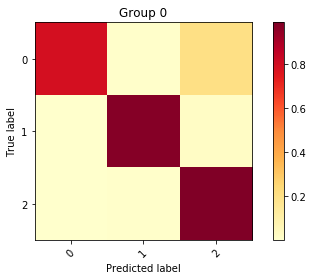

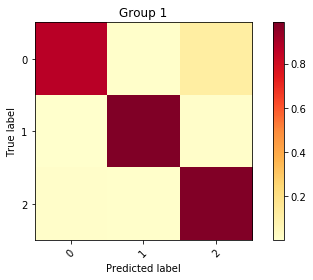

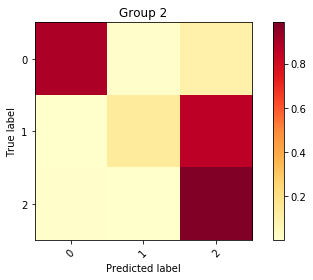

Inertia: 0.1005351134420683
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.298012      29   0.241592     0.91821   0.0905791       0.956062   0.584876
   1         1  0.183288      18   0.206137     0.944829  0.0583558       0.971293   0.611496
   2         2  0.5187        51   0.288013     0.672738  0.702782        0.746967   0.339405
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [93]:
results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[2]) #PCA

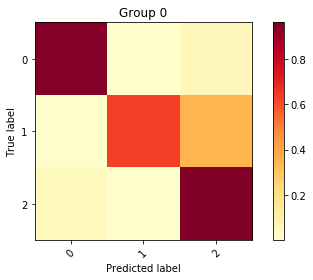

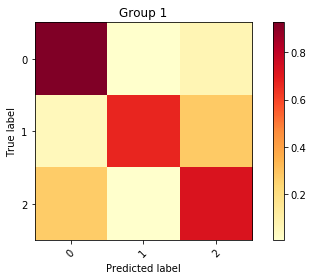

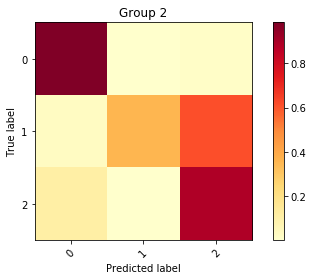

Inertia: 0.023930084891617298
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.309395      30   0.365585     0.847532   0.182466       0.913764   0.514199
   1         1  0.292265      29   0.556675     0.77324    0.267024       0.873002   0.439907
   2         2  0.39834       39   0.406265     0.74271    0.388888       0.832324   0.409377
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [25]:
results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[2]) #best acc model

In [ ]:
#measure on best

In [91]:
selected = 2
gMixture.betas = matrices_encontradas[selected].copy()
gMixture.base_model = modelos_encontrados[selected]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

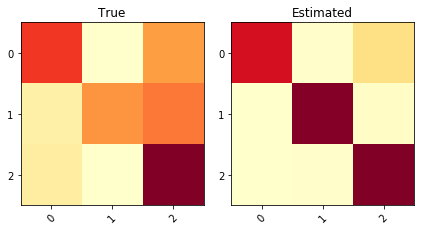

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1817


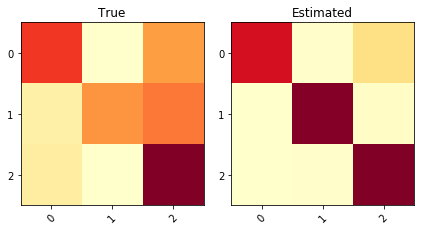

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1819


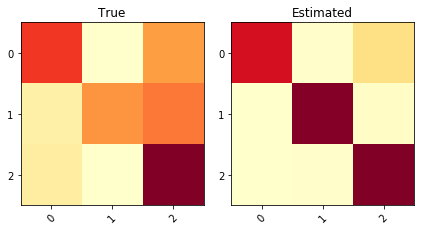

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1819


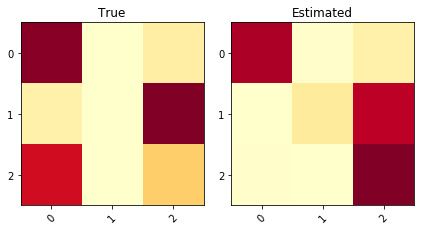

KL divergence: 1.1094	Pearson Correlation between diagonals: 0.6516


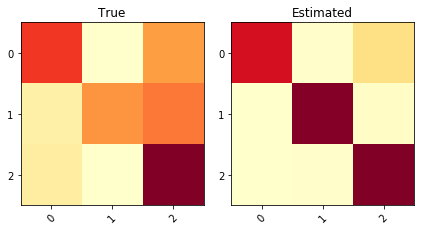

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1819


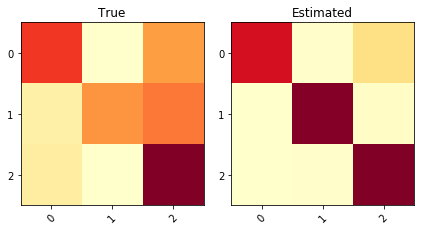

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1819


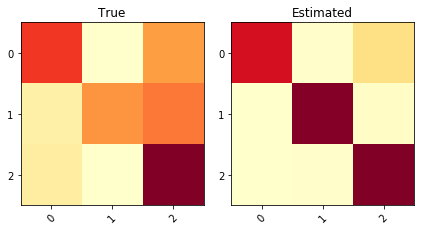

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1819


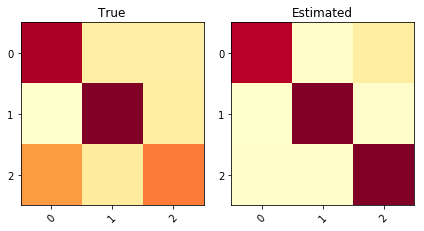

KL divergence: 0.5461	Pearson Correlation between diagonals: -0.2740


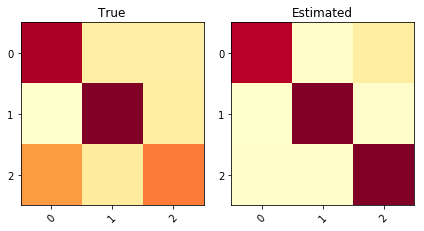

KL divergence: 0.5458	Pearson Correlation between diagonals: -0.2734


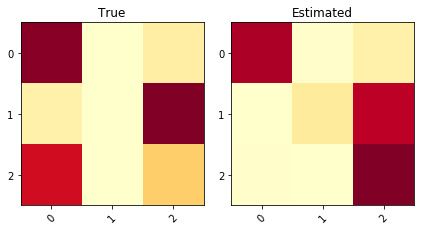

KL divergence: 1.1094	Pearson Correlation between diagonals: 0.6516


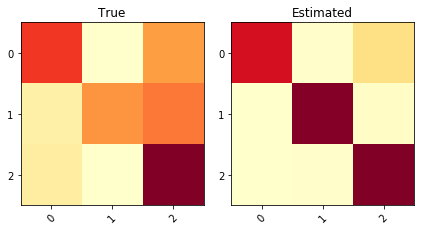

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1819


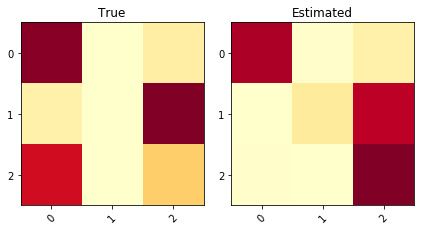

KL divergence: 1.1094	Pearson Correlation between diagonals: 0.6516


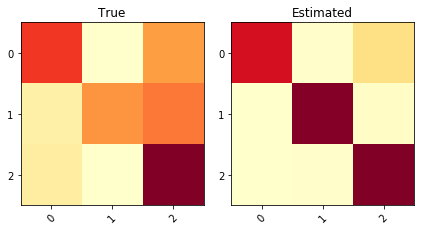

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1818


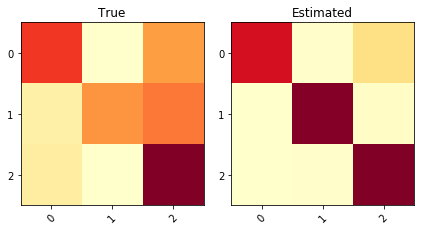

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1819


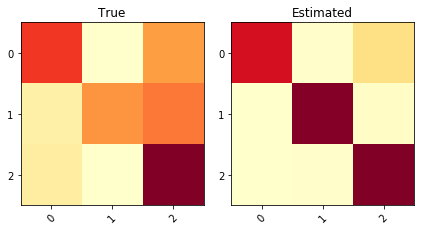

KL divergence: 0.6298	Pearson Correlation between diagonals: 0.1818
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.883191      0.883191   0.712018  0.0985909            0.180294
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.887668      0.887668
====  ======  ==========  ============


In [92]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred) #PCA

### $\lambda$ random on clean data 2

In [227]:
#1,2,9,14,15,18 ----5,8,16(aprox), 19 very aprox
#revisar log loss..
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #best is lambda close to 1

Indices:  [19  8  1 15 14 18 16  4  0  9 10  2  7 13 12  6  3 17  5 11]
F1 scores:  0.9567233308497585
F1 scores:  0.9722991947952253
F1 scores:  0.9730373373417617
F1 scores:  0.9708188472037063
F1 scores:  0.956016774823882


array([[[0.52382575, 0.21659293, 0.25958132],
        [0.11623011, 0.83725768, 0.04651221],
        [0.44169099, 0.00159129, 0.55671772]],

       [[0.21783677, 0.41721678, 0.36494644],
        [0.4749662 , 0.49408818, 0.03094562],
        [0.4142501 , 0.00183745, 0.58391245]]])

In [231]:
for ind in indexs_sort[:5]:
    print("LogLoss %f "%logL_iter[ind] )

LogLoss -74753.037878 
LogLoss -74846.558465 
LogLoss -74848.771741 
LogLoss -74881.145240 
LogLoss -75019.563584 


### $\lambda$ =1 on clean data 2

In [232]:
# 0 y 1 interesantes--3 aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [3 0 1 2 4]
F1 scores: 0.955606 y LogLoss -74719.447607 
F1 scores: 0.968179 y LogLoss -74883.187174 
F1 scores: 0.960457 y LogLoss -74920.960253 
F1 scores: 0.956374 y LogLoss -75083.774056 
F1 scores: 0.351232 y LogLoss -76185.540685 


array([[[0.50777171, 0.22507155, 0.26715675],
        [0.11185078, 0.83924488, 0.04890434],
        [0.4582481 , 0.00159581, 0.54015609]],

       [[0.22760429, 0.41990971, 0.352486  ],
        [0.47839272, 0.49042606, 0.03118121],
        [0.40264624, 0.00196233, 0.59539143]]])

In [239]:
#con alfa data dependent --> 3,2 y 0 muy buenos
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.458558 y LogLoss -73051.591996 
F1 scores: 0.962240 y LogLoss -73313.658698 
F1 scores: 0.965886 y LogLoss -73497.073680 
F1 scores: 0.974446 y LogLoss -73702.008816 
F1 scores: 0.971485 y LogLoss -73704.003644 


array([[[7.05309888e-01, 6.78381229e-03, 2.87906299e-01],
        [7.35180890e-02, 9.24724807e-01, 1.75710357e-03],
        [5.01078305e-01, 2.81658016e-01, 2.17263679e-01]],

       [[4.66742009e-01, 1.93783100e-04, 5.33064208e-01],
        [6.14267012e-01, 3.16643747e-01, 6.90892417e-02],
        [1.89225399e-01, 1.86074745e-03, 8.08913853e-01]]])

### $\lambda$ random on noise data 2

In [254]:
#9,1,16,4,17 -.- aprox : 15,7,3,8 , 13 very aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda aprox to 1

Indices:  [13  1 15  9 16  2 12  7 18  3  4 17 11 19  6 14  0  5 10  8]
F1 scores: 0.888830 y LogLoss -78001.588032 
F1 scores: 0.892016 y LogLoss -78116.591164 
F1 scores: 0.884132 y LogLoss -78137.777845 
F1 scores: 0.883747 y LogLoss -78254.586413 
F1 scores: 0.883738 y LogLoss -78314.510964 


array([[[0.27134669, 0.35397641, 0.3746769 ],
        [0.44678169, 0.51668657, 0.03653173],
        [0.4222056 , 0.00645561, 0.5713388 ]],

       [[0.50628012, 0.21383676, 0.27988311],
        [0.14782917, 0.80655601, 0.04561483],
        [0.42775275, 0.00488844, 0.56735881]]])

In [255]:
matrices_encontradas[indexs_sort[1]] #-- l_0 == 1 l_1 ==0

array([[[0.08295195, 0.40093714, 0.51611091],
        [0.48669173, 0.45809595, 0.05521232],
        [0.62825357, 0.00538692, 0.36635951]],

       [[0.94113627, 0.02508032, 0.03378341],
        [0.00918393, 0.98703061, 0.00378546],
        [0.0255219 , 0.00113546, 0.97334265]]])

In [258]:
#with data dependent: 14,8,17,18,6,7
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #

Indices:  [10 16  9  1  2 19 15  0 13  5 12  6  3 11  8  7 17 14 18  4]
F1 scores: 0.569450 y LogLoss -72703.277615 
F1 scores: 0.491469 y LogLoss -72720.581623 
F1 scores: 0.508396 y LogLoss -72767.949725 
F1 scores: 0.491615 y LogLoss -72825.122112 
F1 scores: 0.507041 y LogLoss -72896.068329 


array([[[3.79349307e-01, 6.94819793e-04, 6.19955873e-01],
        [7.77944156e-01, 8.23359122e-02, 1.39719932e-01],
        [3.06555768e-01, 2.04645067e-04, 6.93239587e-01]],

       [[4.25210560e-01, 5.09417750e-01, 6.53716909e-02],
        [6.15437909e-02, 9.38092005e-01, 3.64204100e-04],
        [5.08005925e-01, 3.63402917e-01, 1.28591157e-01]]])

### $\lambda$ =1 on noise data 2

In [262]:
#1,3 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [1 3 4 0 2]
F1 scores: 0.891017 y LogLoss -77959.391833 
F1 scores: 0.886087 y LogLoss -78123.030905 
F1 scores: 0.884353 y LogLoss -78170.862790 
F1 scores: 0.882184 y LogLoss -78190.927143 
F1 scores: 0.859548 y LogLoss -78572.408112 


array([[[0.25098253, 0.35037085, 0.39864661],
        [0.44670657, 0.51498243, 0.038311  ],
        [0.4298412 , 0.00810423, 0.56205457]],

       [[0.52964153, 0.20908235, 0.26127612],
        [0.15634487, 0.79921221, 0.04444291],
        [0.41637648, 0.00626742, 0.57735611]]])

### $\lambda$ random on clean data 1

In [280]:
#15,11,10,19,9,8 -- very aprox 1,5,6
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 1,0.3,0.9

Indices:  [ 5 15 11  8 14 10 16  1 19  4  9  6 12  0  2 18 13  3 17  7]
F1 scores: 0.954411 y LogLoss -77836.820531 
F1 scores: 0.958790 y LogLoss -77941.398320 
F1 scores: 0.940030 y LogLoss -77965.365354 
F1 scores: 0.947836 y LogLoss -78038.735143 
F1 scores: 0.910642 y LogLoss -78040.768166 


array([[[0.55499299, 0.40424585, 0.04076116],
        [0.74376586, 0.24764065, 0.00859349],
        [0.46344935, 0.36092144, 0.1756292 ]],

       [[0.82776326, 0.12548399, 0.04675276],
        [0.08155971, 0.90830062, 0.01013967],
        [0.03171331, 0.04560996, 0.92267673]],

       [[0.53795303, 0.34491255, 0.11713442],
        [0.22329621, 0.75771587, 0.01898792],
        [0.09282163, 0.195167  , 0.71201137]]])

In [284]:
matrices_encontradas[indexs_sort[1]] #lambda 1,0.75,0

array([[[0.67928817, 0.28913513, 0.0315767 ],
        [0.54120412, 0.45556271, 0.00323317],
        [0.42460938, 0.25247046, 0.32292017]],

       [[0.62701399, 0.27485157, 0.09813444],
        [0.22333284, 0.76642445, 0.01024272],
        [0.09648147, 0.14086318, 0.76265535]],

       [[0.52124351, 0.36240502, 0.11635147],
        [0.24622555, 0.74312222, 0.01065222],
        [0.09708732, 0.23612256, 0.66679012]]])

### $\lambda$ =1 on clean data 1

In [273]:
# 0 y 2 , quizas el 3
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [0 4 1 2 3]
F1 scores: 0.957691 y LogLoss -77777.045732 
F1 scores: 0.949563 y LogLoss -77822.228357 
F1 scores: 0.953599 y LogLoss -77856.778807 
F1 scores: 0.948690 y LogLoss -77872.086503 
F1 scores: 0.931905 y LogLoss -77906.054126 


array([[[0.59412547, 0.36171718, 0.04415735],
        [0.66799795, 0.32474261, 0.00725944],
        [0.52856849, 0.30642452, 0.16500699]],

       [[0.52760818, 0.33752145, 0.13487037],
        [0.31600033, 0.66175519, 0.02224447],
        [0.14146238, 0.22927853, 0.62925909]],

       [[0.56413881, 0.31949401, 0.11636717],
        [0.21524957, 0.76938829, 0.01536214],
        [0.07210637, 0.21926451, 0.70862912]]])

### $\lambda$ random on noisy data 1

In [305]:
# 4,15,18
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 0.9,0.95,0.77

Indices:  [16 15 17  2 19 12 14  5 18  1  6  4  7 13 10 11  8  3  9  0]
F1 scores: 0.869044 y LogLoss -78922.915633 
F1 scores: 0.866170 y LogLoss -78982.619162 
F1 scores: 0.861920 y LogLoss -79051.791381 
F1 scores: 0.857006 y LogLoss -79139.196237 
F1 scores: 0.847250 y LogLoss -79204.031599 


array([[[0.58607908, 0.36341081, 0.05051011],
        [0.66739828, 0.32284521, 0.00975651],
        [0.493704  , 0.30487077, 0.20142523]],

       [[0.50693243, 0.34776968, 0.14529789],
        [0.31437943, 0.65691552, 0.02870504],
        [0.12305859, 0.27650573, 0.60043568]],

       [[0.60705624, 0.26678528, 0.12615848],
        [0.18890858, 0.78930815, 0.02178327],
        [0.06595133, 0.17302841, 0.76102026]]])

In [306]:
matrices_encontradas[indexs_sort[1]] #lambda 0.9,0.15,1

array([[[0.54434378, 0.39895361, 0.05670261],
        [0.69226245, 0.29917253, 0.00856502],
        [0.48889289, 0.32543488, 0.18567223]],

       [[0.88857981, 0.07739007, 0.03403012],
        [0.04260737, 0.95177684, 0.00561578],
        [0.01874574, 0.03511641, 0.94613784]],

       [[0.46865228, 0.36090133, 0.1704464 ],
        [0.28625581, 0.6858124 , 0.02793179],
        [0.11223195, 0.26951884, 0.61824921]]])

### $\lambda$ =1 on noisy data 1

In [315]:
# 1 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.871127 y LogLoss -78805.593847 
F1 scores: 0.867015 y LogLoss -78817.192683 
F1 scores: 0.849491 y LogLoss -78854.670714 
F1 scores: 0.865092 y LogLoss -78979.309951 
F1 scores: 0.866156 y LogLoss -78985.742220 


array([[[0.58714018, 0.36795373, 0.0449061 ],
        [0.69558504, 0.29376966, 0.0106453 ],
        [0.48082751, 0.31934017, 0.19983232]],

       [[0.54569706, 0.3299119 , 0.12439103],
        [0.27193291, 0.7006825 , 0.02738459],
        [0.11665229, 0.23142926, 0.65191844]],

       [[0.57664747, 0.29595247, 0.12740006],
        [0.20585552, 0.76759455, 0.02654993],
        [0.09077485, 0.19447976, 0.71474539]]])

In [259]:
Qij_gamma = np.sum(gMixture.get_qestimation(),axis=-2) #qij(gamma)
r_estimate = np.zeros((Qij_gamma.shape[0],Qij_gamma.shape[2])) #repeat estimate
for i in range(Qij_gamma.shape[0]):
    r_estimate[i] = np.tensordot(Qij_gamma[i],r_obs[i],axes=[[0],[0]])
r_estimate

array([[ 0.20453249, 25.85263166,  2.94283584],
       [ 0.12035406, 24.94385666,  0.93578928],
       [24.07822754,  4.97867884,  1.94309361],
       ...,
       [ 0.25168615, 31.56533154,  0.18298231],
       [ 7.46407726, 17.98318088,  9.55274186],
       [ 0.91988414,  0.0756443 , 27.00447157]])

In [71]:
gMixture.get_predictions(Xstd_train)

array([[0.06842059, 0.73907024, 0.19250914],
       [0.02262934, 0.94639385, 0.03097681],
       [0.4558536 , 0.44500634, 0.09914005],
       ...,
       [0.03236194, 0.94923073, 0.01840742],
       [0.30035946, 0.30898702, 0.3906535 ],
       [0.15407403, 0.0127452 , 0.8331808 ]], dtype=float32)

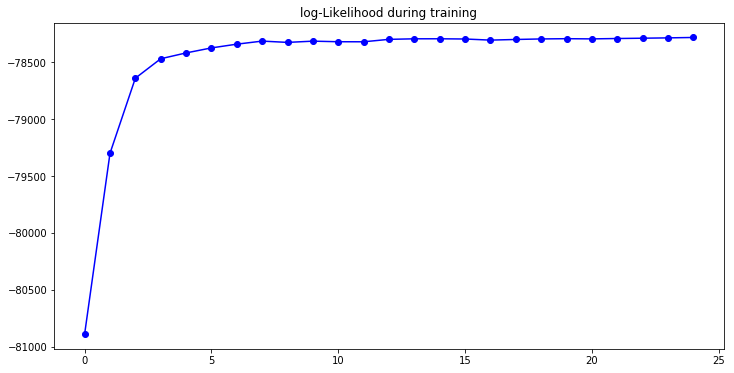

In [185]:
plt.figure(figsize=(12,6))
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.title("log-Likelihood during training")
plt.show()

In [146]:
### model over ground truth
model = clone_model(gMixture.get_basemodel())
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(Xstd_train, keras.utils.to_categorical(Z_train), batch_size=128,epochs=50)
from utils import calculate_f1_keras
print(calculate_f1_keras(model, Xstd_train, Z_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2700/2700 [==============================] - 1s 442us/step - loss: 0.7655
Epoch 2/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.7441
Epoch 3/50
2700/2700 [==============================] - 0s 34us/step - loss: 0.7239
Epoch 4/50
2700/2700 [==============================] - 0s 35us/step - loss: 0.7050
Epoch 5/50
2700/2700 [==============================] - 0s 31us/step - loss: 0.6872
Epoch 6/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.6704
Epoch 7/50
2700/2700 [==============================] - 0s 38us/step - loss: 0.6546
Epoch 8/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.6397
Epo

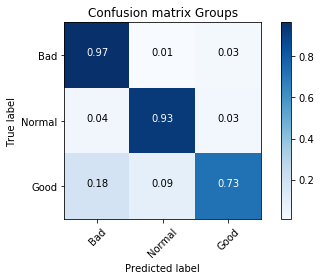

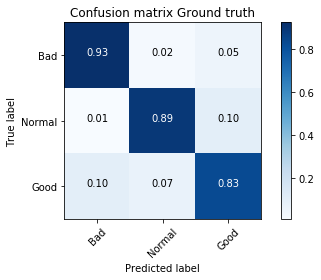

In [147]:
from utils import *
classes = ["Bad","Normal","Good"]
plot_confusion_keras(gMixture.base_model,Xstd_train,Z_train,classes,title='Confusion matrix Groups')
plot_confusion_keras(model,Xstd_train,Z_train,classes,title='Confusion matrix Ground truth')


<a id="condato"></a>
### Training module 2
---
Here we implement the iteration between **E** and **M** steps with bulks annotations $r_{itj}$.

In [ ]:
class GroupMixtureBulk(object):
    def __init__(self,input_dim,Kl=2,M=2,alpha_DD=True,epochs=1,optimizer='adam'): 
        
        
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        self.compile=False
        self.Keps = keras.backend.epsilon()
        self.priors=False #boolean of priors
        #params
        self.M = M #groups of annotators
        self.data_dependence = alpha_DD #for alpha = p(g|x) or p(g)
        self.epochs = epochs
        self.optimizer = optimizer
        
        self.seted_alphainit = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas
    def get_alpha(self):
        """Get alpha param, p(g|xi) for every data on trainig or globally p(g)"""
        return self.alphas
    def set_alpha(self,alphas_init):
        """set alpha param with a previosuly method"""
        self.alphas = alphas_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        return self.Qi_mgamma
        
    def define_model(self,tipo,*args):
        """Define the base model and other structures"""
        aux_info = None
        emb_info = None
        self.type = tipo.lower()
        if self.type =="cnn":
            info,aux_info =args
        elif self.type == "rnn":
            info,aux_info,emb_info = args            
        elif self.type == "ff" or self.type == "mlp": #classic feed forward
            start_units,deep,activation = args
            info = [start_units,deep,activation]
        elif self.type == "keras_shallow" or self.type=="keras_perceptron": 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl,self.optimizer)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        
        if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
            self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X,batch_size=None):
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=batch_size)
    
    def init_E(self,X,r):
        
        
        self.N = X.shape[0]
        #-------> init alpha
        if not self.seted_alphainit:
            self.alphas = np.random.dirichlet(np.ones(self.M),size=self.N) # random start that sum one
        
        #-------> init Majority voting
        mv_probs = majority_voting(r,repeats=True,probas=True)
        #majority voting by group...
        """
        mv_prob_groups = []
        r_sample = 0
        for l in range(self.M):
            aux_mv_probs = majority_voting(np.clip(r-r_sample,0,1e100),repeats=True,probas=True)
            r_sample = []
            for i in range(self.N):
                total_annotators = np.sum(r[i])
                ri_sample = np.random.multinomial(total_annotators/self.M, aux_mv_probs[i]) #asumming al groups have same number of annotators
                r_sample.append(ri_sample)
            r_sample = np.asarray(r_sample)
            mv_prob_groups.append(majority_voting(r_sample,repeats=True,probas=True) )
        """
        
        #-------> init q_i
        self.Qi_mgamma = np.random.rand(self.N,self.M,self.Kl) #random init
        #"""
        for i in range(self.N):            
            #for m in range(self.M):
            self.Qi_mgamma[i] = np.tensordot(self.alphas[i], mv_probs[i],axes=-1)  #a interestetnly E-step  
        
        #-------> init betas
        self.betas = np.random.rand(self.M,self.Kl,self.Kl)
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None]
        
        """
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(mv_probs[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])
            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
        """
        
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",mv_probs.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qi_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if len(priors.shape)==2:
            priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions,r): #r is data
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(predictions[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])

            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
                                                                                                                       
    def M_step(self,X,r): 
        #-------> base model
        #create the repeat "estimate"/"ground truth"
        Qi_gamma = np.sum(self.Qi_mgamma,axis=-2) #qi(gamma)
        #train to learn p(z|x)
        if "sklearn" in self.type:
            self.base_model.fit(X, np.argmax(Qi_gamma,axis=1) ) 
        else:
            history = self.base_model.fit(X,Qi_gamma,batch_size=self.batch_size,epochs=self.epochs,verbose=1) 
            
        #-------> alpha --maneja caso global y normal..
        Qi_m = np.sum(self.Qi_mgamma,axis=-1) #qi(m)
        if not self.data_dependence: #global alpha
            g_estimate = np.sum(Qi_m,axis=0)
            self.alphas[:] = g_estimate/np.sum(g_estimate,axis=-1) #p(g) 
        else:
            self.alphas = Qi_m #p(g|x)
        
        #-------> beta   # p(yo|g,z)
        for m in range(self.M):
            for j_z in range(self.Kl):
                for j_ob in range(self.Kl):
                    self.betas[m,j_z,j_ob] = np.tensordot(self.Qi_mgamma[:,m,j_z],r[:,j_ob], axes=[[0],[0]]) # ~p(yo|g,z)
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior function
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None] #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        
                                                
    def train(self,X_train,r_train,batch_size=32,iterations=250,tolerance=0.001,relative=False): #0.0001  
        
                                                  

gMixtureRaykar = GroupMixtureBulk(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=10)
###epochs=1 as Rodriges says. and batch size as default
gMixtureRaykar.Kl

In [ ]:
gMixtureRaykar = GroupMixtureBulk(X_train.shape[1:],Kl=r_obs.shape[1],M=100)

#gMixture.define_model("sklearn_logistic") #logistic necesita datos de todas la clases
gMixtureRaykar.define_model("keras_shallow")
gMixtureRaykar.set_alpha(alphas_init_Raykar)
#gMixtureRaykar.set_alpha((y_obs!=-1)*1)

#need priors!!!--lo hace mas estable
M = 100
gMixtureRaykar.define_priors(np.ones((M,r_obs.shape[1])))

logL_hist = gMixtureRaykar.train(Xstd_train,r_obs,batch_size=64,iterations=10,relative=False)